In [2]:
from google.colab import drive
drive.mount('/content/drive/Shareddrives/TP Descriptiva')

ValueError: Mountpoint must not contain a space.

# Análisis Exploratorio Inicial
# Dataset: Brazilian E-Commerce Public Dataset by Olist
[https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce]

Yasmin Ohana - legajo: 65098

Julia Sexe - legajo: 65669

Alexis Florian Rehmann - legajo: 61251

##Carga de librerías necesarias.

In [ ]:
import os, json, pathlib
import zipfile, pathlib, re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
from scipy.stats import chi2
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm

##Ingesta de los datos desde Kaggle.
Aclaración: los archivos crudos están subidos en el repositorio de GitHub pero no realizamos la ingesta desde ahí ya que el archivo "Olist_geolocation_dataset.csv" era muy pesado y no permitía ser subido al repositorio.

In [ ]:
!pip -q install kaggle

KAGGLE_USERNAME = "yasminohana1"
KAGGLE_KEY      = "4b30102e8deedd1447edf89efab04761"

os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

path = pathlib.Path("~/.kaggle").expanduser()
path.mkdir(parents=True, exist_ok=True)
with open(path / "kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
def kaggle_slug_from_url(url_or_slug: str) -> str:
    m = re.search(r"kaggle\.com/datasets/([^/?#]+/[^/?#]+)", url_or_slug)
    return m.group(1) if m else url_or_slug.strip()

def kaggle_download(url_or_slug: str, dest="/content/data"):
    slug = kaggle_slug_from_url(url_or_slug)
    dest = pathlib.Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    print(f"Descargando: {slug} → {dest}")
    !kaggle datasets download -d {slug} -p {dest} -q
    # descomprimir todos los .zip que queden en dest
    for z in dest.glob("*.zip"):
        with zipfile.ZipFile(z) as zf:
            zf.extractall(dest)
        z.unlink()
    print("Listo. Archivos en:", dest)
    return dest

In [ ]:
olist_dir = kaggle_download("https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce",
                            dest="/content/olist")
!ls -1 {olist_dir}

Descargando: olistbr/brazilian-ecommerce → /content/olist
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
Listo. Archivos en: /content/olist
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


In [ ]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

DATA = Path("/content/olist")

date_cols_orders = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]

orders   = pd.read_csv(DATA/"olist_orders_dataset.csv", parse_dates=date_cols_orders)
items    = pd.read_csv(DATA/"olist_order_items_dataset.csv", parse_dates=["shipping_limit_date"])
payments = pd.read_csv(DATA/"olist_order_payments_dataset.csv")
reviews  = pd.read_csv(DATA/"olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"])
customers= pd.read_csv(DATA/"olist_customers_dataset.csv")
sellers  = pd.read_csv(DATA/"olist_sellers_dataset.csv")
products = pd.read_csv(DATA/"olist_products_dataset.csv")
geo      = pd.read_csv(DATA/"olist_geolocation_dataset.csv")
cats_tr  = pd.read_csv(DATA/"product_category_name_translation.csv")

##Análisis exploratorio inicial de los datos.

###Forma y tamaño del dataset. Análisis de valores únicos.

In [ ]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [ ]:
print("geo – filas totales:", f"{len(geo):,}")
pref = geo['geolocation_zip_code_prefix']
print("prefijos únicos:", f"{pref.nunique():,}")
dup = geo.groupby('geolocation_zip_code_prefix').size()
print("% de prefijos con >1 fila:", round((dup > 1).mean()*100, 1), "%")

geo – filas totales: 1,000,163
prefijos únicos: 19,015
% de prefijos con >1 fila: 94.5 %


In [ ]:
orders.head()
orders.info()
orders.describe()
for i in orders.columns:
  print(i, orders[i].isnull().sum())

# aca hay nulos, vamos a imputar más adelante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
order_id 0
customer_id 0
order_status 0
order_purchase_timestamp 0
order_approved_at 160
order_delivered_carrier_date 1783
order_delivered_customer_date 2965
order

In [ ]:
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [ ]:
items.head()
items.info()
items.describe()
for i in items.columns:
  print(i, items[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
order_id 0
order_item_id 0
product_id 0
seller_id 0
shipping_limit_date 0
price 0
freight_value 0


In [ ]:
payments.info()
payments.describe()
for i in payments.columns:
  print(i, payments[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
order_id 0
payment_sequential 0
payment_type 0
payment_installments 0
payment_value 0


In [ ]:
payments['payment_installments'].value_counts()

payment_installments
1     52546
2     12413
3     10461
4      7098
10     5328
5      5239
8      4268
6      3920
7      1626
9       644
12      133
15       74
18       27
11       23
24       18
20       17
13       16
14       15
17        8
16        5
21        3
0         2
22        1
23        1
Name: count, dtype: int64

In [ ]:
payments['payment_type'].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [ ]:
payments['payment_value'].value_counts()

payment_value
50.00     324
20.00     274
100.00    255
77.57     250
35.00     165
         ... 
19.18       1
713.65      1
366.73      1
248.73      1
956.86      1
Name: count, Length: 29077, dtype: int64

In [ ]:
payments['payment_sequential'].value_counts()

payment_sequential
1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
17        6
19        6
18        6
16        6
20        4
21        4
22        3
24        2
25        2
26        2
23        2
27        1
28        1
29        1
Name: count, dtype: int64

In [ ]:
reviews.info()
reviews.describe()
for i in reviews.columns:
  print(i, reviews[i].isnull().sum())

# tenemos valores nulos en los titulos y mensajes, pero como son textos decidimos no entrar en el mundo de procesamiento de lenguaje natural.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
review_id 0
order_id 0
review_score 0
review_comment_title 87656
review_comment_message 58247
review_creation_date 0
review_answer_timestamp 0


In [ ]:
reviews['review_score'].value_counts()

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64

In [ ]:
reviews['review_answer_timestamp'].nunique()

98248

In [ ]:
reviews['review_answer_timestamp'].unique() ##todas fechas

<DatetimeArray>
['2018-01-18 21:46:59', '2018-03-11 03:05:13', '2018-02-18 14:36:24',
 '2017-04-21 22:02:06', '2018-03-02 10:26:53', '2018-04-16 00:39:37',
 '2017-07-18 19:30:34', '2018-08-14 21:36:06', '2017-05-18 12:05:37',
 '2018-05-23 16:45:47',
 ...
 '2018-05-26 21:24:06', '2018-05-20 21:51:06', '2018-05-10 14:37:03',
 '2017-12-14 11:09:36', '2018-04-30 01:18:57', '2018-07-14 17:18:30',
 '2017-12-11 20:06:42', '2018-03-23 09:10:43', '2018-07-02 12:59:13',
 '2017-07-03 21:01:49']
Length: 98248, dtype: datetime64[ns]

In [ ]:
customers.info()
customers.describe()
for i in customers.columns:
  print(i, customers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
customer_id 0
customer_unique_id 0
customer_zip_code_prefix 0
customer_city 0
customer_state 0


In [ ]:
customers['customer_unique_id'].value_counts()

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
4f83c83b7ff5b544a8c75dcb8ad66e2e     1
3fe413dde400746c53c5d0d38b266ca2     1
289e1d1ce11a14bb169775d58ad2f1c2     1
ec83d060d9a0abba4b409c544c744c2f     1
211e4234ffca5cec9b0ab183a1009256     1
Name: count, Length: 96096, dtype: int64

In [ ]:
customers.shape

(99441, 5)

In [ ]:
customers['customer_id'].nunique()

99441

In [ ]:
sellers.info()
sellers.describe()
for i in sellers.columns:
  print(i, sellers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
seller_id 0
seller_zip_code_prefix 0
seller_city 0
seller_state 0


In [ ]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [ ]:
products.info()
products.describe()
for i in products.columns:
  print(i, products[i].isnull().sum())

# aca hay valores nulos, vamos a imputar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
product_id 0
product_category_name 610
product_name_lenght 610
product_description_lenght 610
product_photos_qty 610
product_weight_g 2
product_length_cm 2
product_height_cm 2
product_width_cm 2


In [ ]:
geo.info()
geo.describe()
for i in geo.columns:
  print(i, geo[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
geolocation_zip_code_prefix 0
geolocation_lat 0
geolocation_lng 0
geolocation_city 0
geolocation_state 0


In [ ]:
product_categories = products['product_category_name'].dropna().unique()
translated_categories = cats_tr['product_category_name'].unique()
translated_count = sum(category in translated_categories for category in product_categories)

print(f"Out of {len(product_categories)} unique product categories, {translated_count} have translations available.")

Out of 73 unique product categories, 71 have translations available.


In [ ]:
cats_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
##una orden puede tener varios items, varios pagos y varias reviews. No podemos unir tdoo con todo directo
items_per_order = items.groupby("order_id").size()
pays_per_order  = payments.groupby("order_id").size()
revs_per_order  = reviews.groupby("order_id").size()

print("Items por orden  → mediana:", int(items_per_order.median()), "| máx:", int(items_per_order.max()))
print("Pagos por orden  → mediana:", int(pays_per_order.median()),  "| máx:", int(pays_per_order.max()))
print("Reviews por orden→ mediana:", int(revs_per_order.median()),   "| máx:", int(revs_per_order.max()))

Items por orden  → mediana: 1 | máx: 21
Pagos por orden  → mediana: 1 | máx: 29
Reviews por orden→ mediana: 1 | máx: 3


In [ ]:
orders_with_multiple_reviews = revs_per_order[revs_per_order > 1]

if len(orders_with_multiple_reviews) > 0:
    print(f"There are {len(orders_with_multiple_reviews)} orders with more than one review.")
else:
    print("There are no orders with more than one review.")

There are 547 orders with more than one review.


In [ ]:
##sumo monto total, tomo la mayor cant de cuotas IGUAL VER, SI ES LA MAYOR O LA SUMA y el metodo mas frecuente
def modo(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

pay_agg = (payments
           .groupby("order_id", as_index=False)
           .agg(payment_value_total=("payment_value","sum"),
                payment_installments_max=("payment_installments","max"),
                payment_type_mode=("payment_type", modo)))

In [ ]:
##con las reviews me quedo con la mas reciente

reviews_sorted = reviews.sort_values(["order_id","review_creation_date"])
rev_agg = (reviews_sorted
           .groupby("order_id", as_index=False)
           .agg(review_score=("review_score","last"),
                review_comment_title=("review_comment_title","last"),
                review_comment_message=("review_comment_message","last"),
                review_creation_date=("review_creation_date","last"),
                review_answer_timestamp=("review_answer_timestamp","last")))

In [ ]:
geo_agg = (geo.groupby("geolocation_zip_code_prefix", as_index=False)
             .agg(geolocation_lat=("geolocation_lat","mean"),
                  geolocation_lng=("geolocation_lng","mean"),
                  geolocation_city=("geolocation_city", modo),
                  geolocation_state=("geolocation_state", modo)))

In [ ]:
##clientes + geo
cust_geo = customers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"customer_zip_code_prefix",
        "geolocation_lat":"customer_lat","geolocation_lng":"customer_lng",
        "geolocation_city":"customer_geo_city","geolocation_state":"customer_geo_state"
    }),
    on="customer_zip_code_prefix", how="left"
)

In [ ]:
##vendedores + geo
sell_geo = sellers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"seller_zip_code_prefix",
        "geolocation_lat":"seller_lat","geolocation_lng":"seller_lng",
        "geolocation_city":"seller_geo_city","geolocation_state":"seller_geo_state"
    }),
    on="seller_zip_code_prefix", how="left"
)

In [ ]:
##orden con cliente y geo con pagos agg y con review agg
fact_orders = (orders
               .merge(cust_geo, on="customer_id", how="left")
               .merge(pay_agg, on="order_id",   how="left")
               .merge(rev_agg, on="order_id",   how="left"))

assert fact_orders["order_id"].is_unique
print("fact_orders:", fact_orders.shape)

fact_orders: (99441, 24)


In [ ]:
products_tr = products.merge(cats_tr, on="product_category_name", how="left")

fact_order_items = (items
    .merge(products_tr, on="product_id", how="left")
    .merge(sell_geo,     on="seller_id",  how="left")
    .merge(orders[["order_id","customer_id","order_purchase_timestamp",
                   "order_estimated_delivery_date","order_delivered_customer_date"]],
           on="order_id", how="left")
    .merge(cust_geo[["customer_id","customer_state","customer_city",
                     "customer_zip_code_prefix","customer_lat","customer_lng"]],
           on="customer_id", how="left")
    .merge(pay_agg, on="order_id", how="left")
    .merge(rev_agg, on="order_id", how="left")
)

dups = fact_order_items.duplicated(["order_id","order_item_id"]).sum()
print("fact_order_items:", fact_order_items.shape, "| duplicados clave:", dups)

fact_order_items: (112650, 40) | duplicados clave: 0


In [ ]:
# Días de entrega (si hay fechas)
fact_orders["delivery_days"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_purchase_timestamp"]
).dt.days

# % de atraso (entregado después de la fecha estimada)
fact_orders["is_late"] = (
    fact_orders["order_delivered_customer_date"] > fact_orders["order_estimated_delivery_date"]
).astype("Int8")

print("Mediana días de entrega (válidos):", fact_orders["delivery_days"].dropna().median())
print("% órdenes 'late':", round(fact_orders["is_late"].mean()*100, 2))

# % de órdenes con review
print("% órdenes con review:", round(fact_orders["review_score"].notna().mean()*100, 2))

Mediana días de entrega (válidos): 10.0
% órdenes 'late': 7.87
% órdenes con review: 99.23


In [ ]:
print("Shape of original orders dataframe:", orders.shape)
print("Shape of fact_orders dataframe:", fact_orders.shape)
print("Shape of fact_order_items dataframe:", fact_order_items.shape)

Shape of original orders dataframe: (99441, 8)
Shape of fact_orders dataframe: (99441, 26)
Shape of fact_order_items dataframe: (112650, 40)


In [ ]:
print("Shape of original items dataframe:", items.shape)
print("Shape of fact_order_items dataframe:", fact_order_items.shape)

Shape of original items dataframe: (112650, 7)
Shape of fact_order_items dataframe: (112650, 40)


###Estadísticos principales.

In [ ]:
fact_orders.describe()

order_purchase_timestamp              order_approved_at  \
count                          99441                          99281   
mean   2017-12-31 08:43:12.776581120  2017-12-31 18:35:24.098800128   
min              2016-09-04 21:15:19            2016-09-15 12:16:38   
25%              2017-09-12 14:46:19            2017-09-12 23:24:16   
50%              2018-01-18 23:04:36            2018-01-19 11:36:13   
75%              2018-05-04 15:42:16            2018-05-04 20:35:10   
max              2018-10-17 17:30:18            2018-09-03 17:40:06   
std                              NaN                            NaN   

        order_delivered_carrier_date  order_delivered_customer_date  \
count                          97658                          96476   
mean   2018-01-04 21:49:48.138278656  2018-01-14 12:09:19.035542272   
min              2016-10-08 10:34:01            2016-10-11 13:46:32   
25%    2017-09-15 22:28:50.249999872  2017-09-25 22:07:22.249999872   
50%              2018-01-24 16:10:58     2018-02-02 19:28:10.500000   
75%              2018-05-08 13:37:45  2018-05-15 22:48:52.249999872   
max              2018-09-11 19:48:28            2018-10-17 13:22:46   
std                              NaN                            NaN   

       order_estimated_delivery_date  customer_zip_code_prefix  customer_lat  \
count                          99441              99441.000000  99163.000000   
mean   2018-01-24 03:08:37.730111232              35137.474583    -21.191224   
min              2016-09-30 00:00:00               1003.000000    -33.689948   
25%              2017-10-03 00:00:00              11347.000000    -23.589378   
50%              2018-02-15 00:00:00              24416.000000    -22.924970   
75%              2018-05-25 00:00:00              58900.000000    -20.139828   
max              2018-11-12 00:00:00              99990.000000     42.184003   
std                              NaN              29797.938996      5.608637   

       customer_lng  payment_value_total  payment_installments_max  \
count  99163.000000         99440.000000              99440.000000   
mean     -46.175442           160.990267                  2.930521   
min      -72.668881             0.000000                  0.000000   
25%      -48.097950            62.010000                  1.000000   
50%      -46.630647           105.290000                  2.000000   
75%      -43.598897           176.970000                  4.000000   
max       -8.723762         13664.080000                 24.000000   
std        4.056067           221.951257                  2.715685   

       review_score           review_creation_date  \
count  98673.000000                          98673   
mean       4.086336  2018-01-13 04:44:29.763765248   
min        1.000000            2016-10-02 00:00:00   
25%        4.000000            2017-09-23 00:00:00   
50%        5.000000            2018-02-02 00:00:00   
75%        5.000000            2018-05-16 00:00:00   
max        5.000000            2018-08-31 00:00:00   
std        1.347625                            NaN   

             review_answer_timestamp  delivery_days   is_late  
count                          98673   96476.000000   99441.0  
mean   2018-01-16 08:19:54.802124032      12.094086   0.07871  
min              2016-10-07 18:32:28       0.000000       0.0  
25%              2017-09-27 14:50:01       6.000000       0.0  
50%              2018-02-05 10:51:54      10.000000       0.0  
75%              2018-05-20 13:59:01      15.000000       0.0  
max              2018-10-29 12:27:35     209.000000       1.0  
std                              NaN       9.551746  0.269287

In [ ]:
fact_order_items.describe()

order_item_id            shipping_limit_date          price  \
count  112650.000000                         112650  112650.000000   
mean        1.197834  2018-01-07 15:36:52.192685312     120.653739   
min         1.000000            2016-09-19 00:15:34       0.850000   
25%         1.000000     2017-09-20 20:57:27.500000      39.900000   
50%         1.000000            2018-01-26 13:59:35      74.990000   
75%         1.000000  2018-05-10 14:34:00.750000128     134.900000   
max        21.000000            2020-04-09 22:35:08    6735.000000   
std         0.705124                            NaN     183.633928   

       freight_value  product_name_lenght  product_description_lenght  \
count  112650.000000        111047.000000               111047.000000   
mean       19.990320            48.775978                  787.867029   
min         0.000000             5.000000                    4.000000   
25%        13.080000            42.000000                  348.000000   
50%        16.260000            52.000000                  603.000000   
75%        21.150000            57.000000                  987.000000   
max       409.680000            76.000000                 3992.000000   
std        15.806405            10.025581                  652.135608   

       product_photos_qty  product_weight_g  product_length_cm  \
count       111047.000000     112632.000000      112632.000000   
mean             2.209713       2093.672047          30.153669   
min              1.000000          0.000000           7.000000   
25%              1.000000        300.000000          18.000000   
50%              1.000000        700.000000          25.000000   
75%              3.000000       1800.000000          38.000000   
max             20.000000      40425.000000         105.000000   
std              1.721438       3751.596884          16.153449   

       product_height_cm  product_width_cm  seller_zip_code_prefix  \
count      112632.000000     112632.000000           112650.000000   
mean           16.593766         22.996546            24439.170431   
min             2.000000          6.000000             1001.000000   
25%             8.000000         15.000000             6429.000000   
50%            13.000000         20.000000            13568.000000   
75%            20.000000         30.000000            27930.000000   
max           105.000000        118.000000            99730.000000   
std            13.443483         11.707268            27596.030909   

          seller_lat     seller_lng       order_purchase_timestamp  \
count  112397.000000  112397.000000                         112650   
mean      -22.797711     -47.235518  2018-01-01 00:09:48.464376576   
min       -32.079231     -67.813284            2016-09-04 21:15:19   
25%       -23.607473     -48.829744            2017-09-13 19:17:04   
50%       -23.425556     -46.743468            2018-01-19 23:02:16   
75%       -21.757321     -46.518679  2018-05-04 17:30:36.750000128   
max        -2.501242     -34.855616            2018-09-03 09:06:57   
std         2.697457       2.339961                            NaN   

       order_estimated_delivery_date  order_delivered_customer_date  \
count                         112650                         110196   
mean   2018-01-24 20:12:15.531291392  2018-01-14 13:25:24.023939328   
min              2016-10-04 00:00:00            2016-10-11 13:46:32   
25%              2017-10-05 00:00:00     2017-09-26 20:09:44.500000   
50%              2018-02-16 00:00:00            2018-02-02 20:57:23   
75%              2018-05-28 00:00:00     2018-05-15 20:09:21.500000   
max              2018-10-25 00:00:00            2018-10-17 13:22:46   
std                              NaN                            NaN   

       customer_zip_code_prefix   customer_lat   customer_lng  \
count             112650.000000  112348.000000  112348.000000   
mean               35119.309090     -21.233540     -46.201855   
min                 1003.0

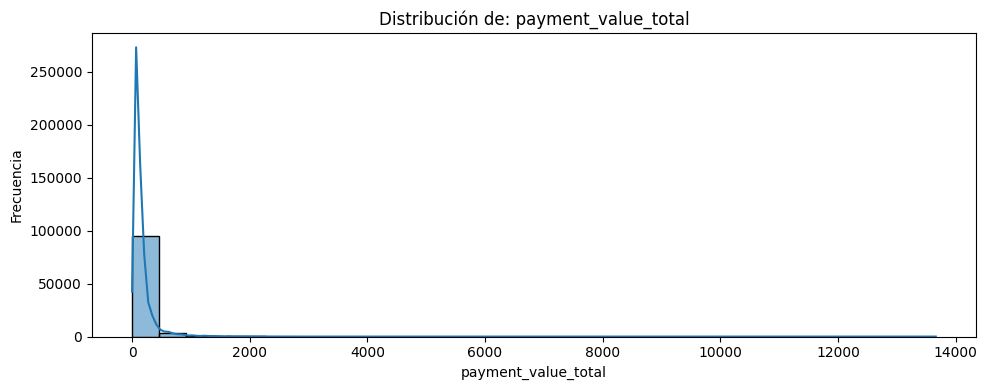

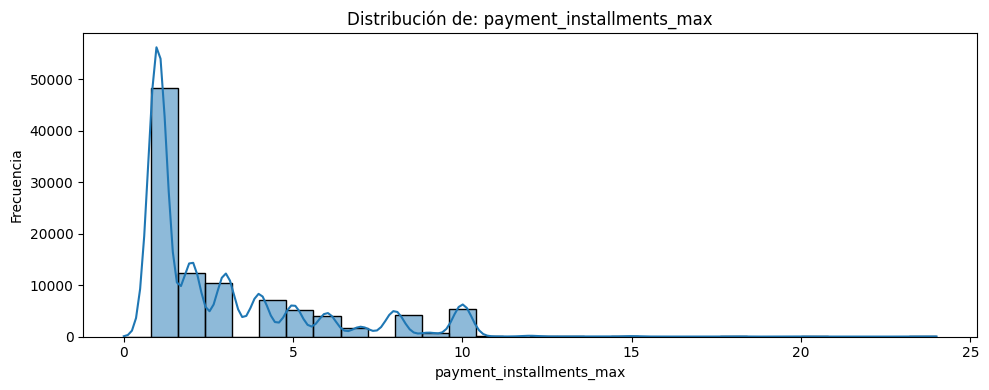

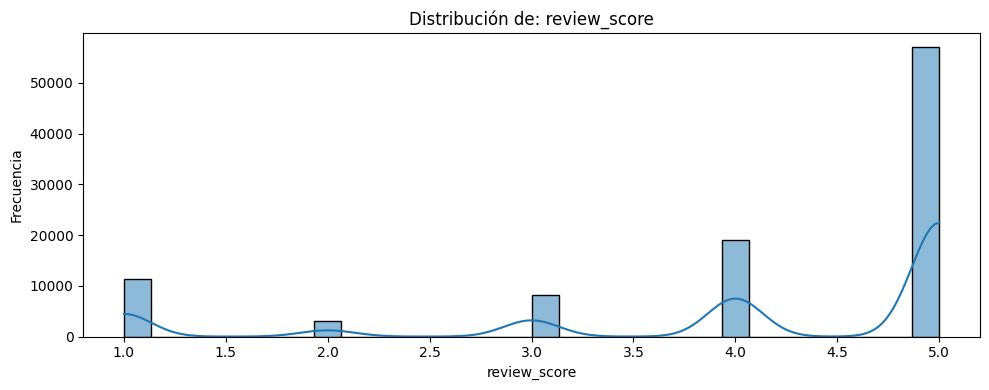

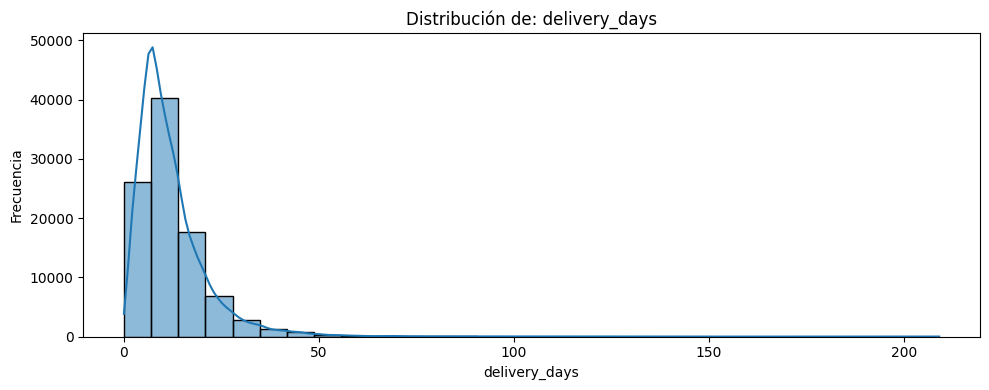

In [ ]:
# Define numerical columns for fact_orders
cols_numericas_fact_orders = fact_orders.select_dtypes(include=['number']).columns.tolist()

# Exclude ID columns, binary variables, and transformation columns from fact_orders
exclude_from_hist_orders = [
    'order_id', 'customer_id', 'customer_unique_id', 'is_late', 'customer_zip_code_prefix',
    'boxcox_payment_value_total', 'z_score_payment_value_total_boxcox', 'z_score_payment_value_total',
    'boxcox_imputed_payment_value_total', 'cleaned_payment_value_total',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'payment_value_total_orig',
    'boxcox_delivery_days', 'z_score_delivery_days_boxcox', 'z_score_delivery_days',
    'boxcox_imputed_delivery_days', 'cleaned_delivery_days',
    'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'delivery_days_orig',
    'customer_lat', 'customer_lng' # Exclude geo coordinates for general distribution plots if they are not the focus
]

# Filter for relevant numerical columns
plot_cols_orders = [col for col in cols_numericas_fact_orders if col not in exclude_from_hist_orders and not col.startswith(('boxcox_', 'yeojohnson_', 'z_score_', 'cleaned_', 'delivery_days_'))]

# histograma de variables numericas
for col in plot_cols_orders:
    plt.figure(figsize=(10,4))
    sns.histplot(fact_orders[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Bar charts for discrete numerical variables in fact_orders:


/tmp/ipython-input-2506043125.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')


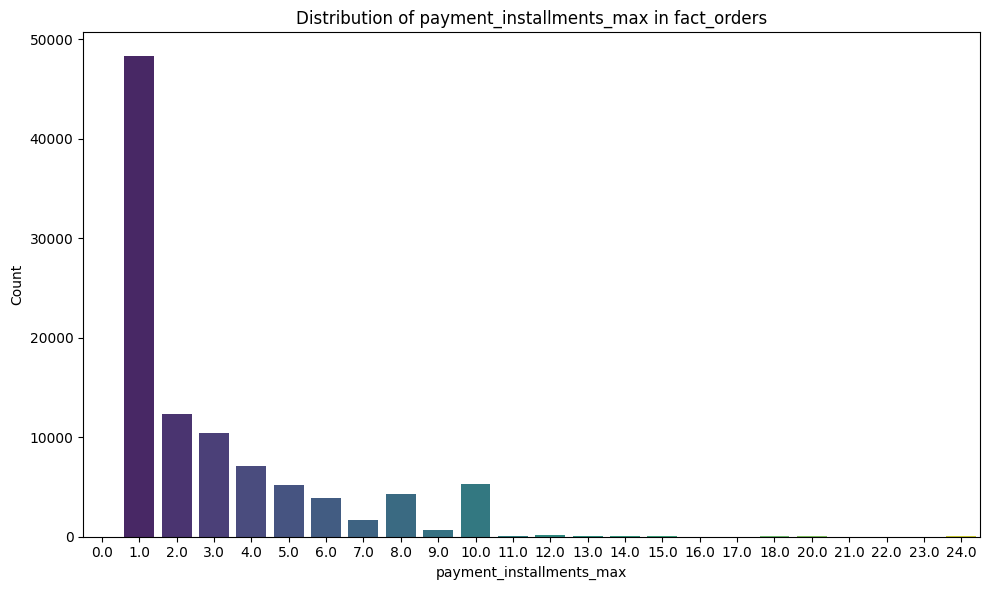

/tmp/ipython-input-2506043125.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')


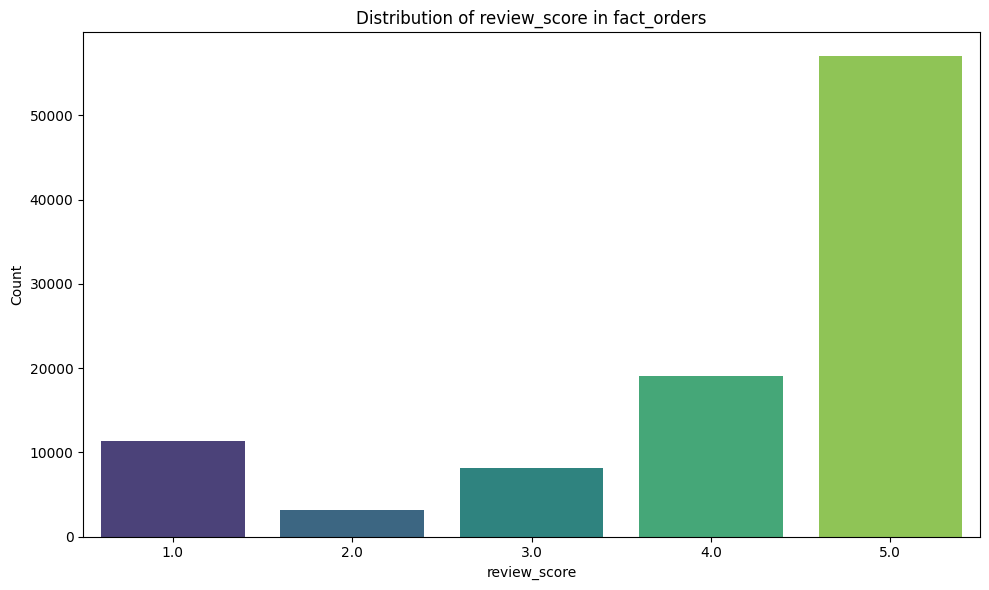

In [ ]:
discrete_for_bar_chart_orders = ['payment_installments_max', 'review_score']

print("Bar charts for discrete numerical variables in fact_orders:")
for col in discrete_for_bar_chart_orders:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')
    plt.title(f'Distribution of {col} in fact_orders')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

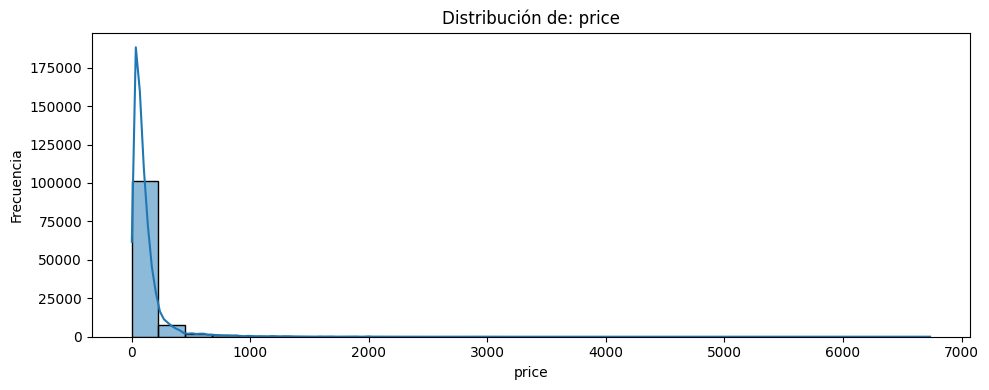

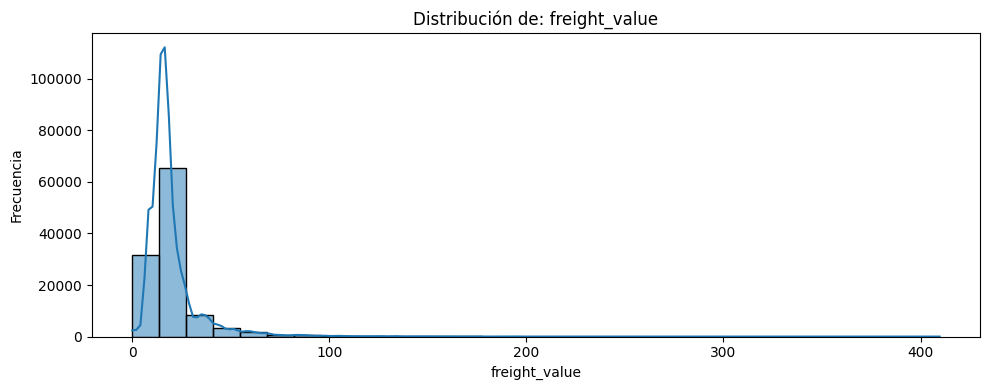

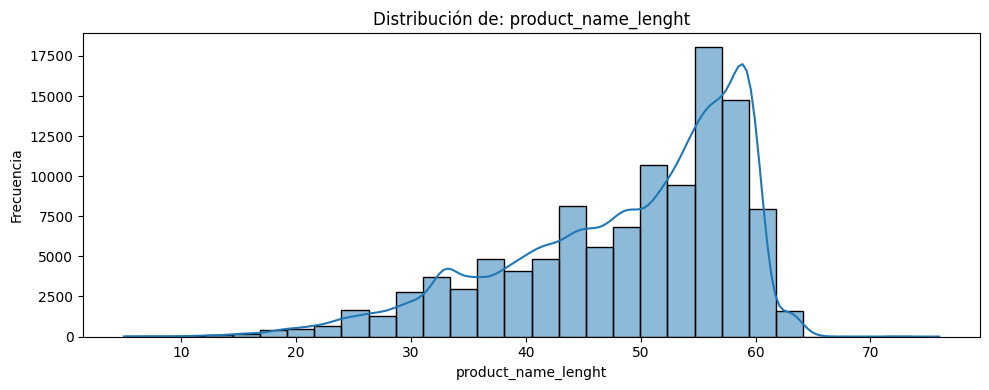

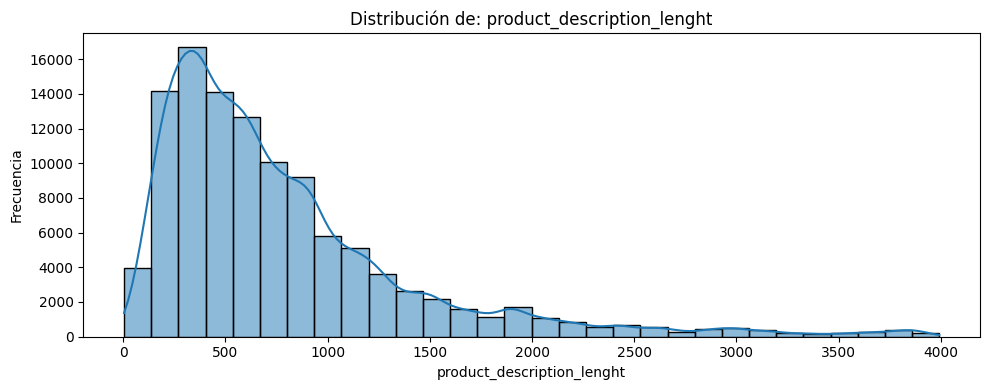

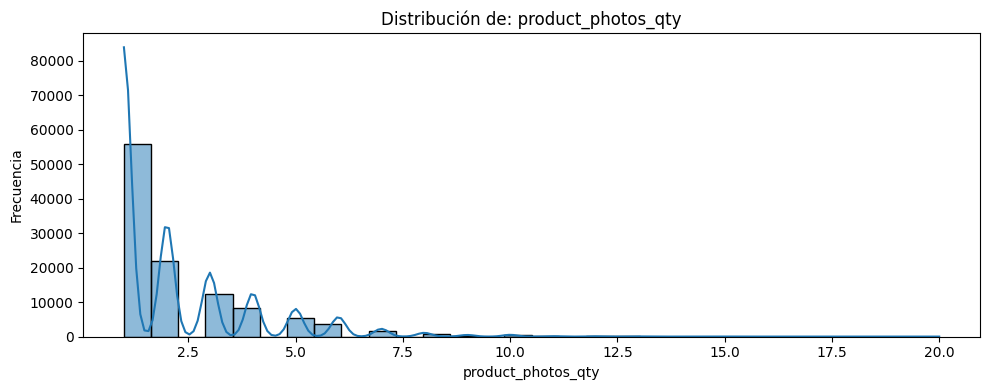

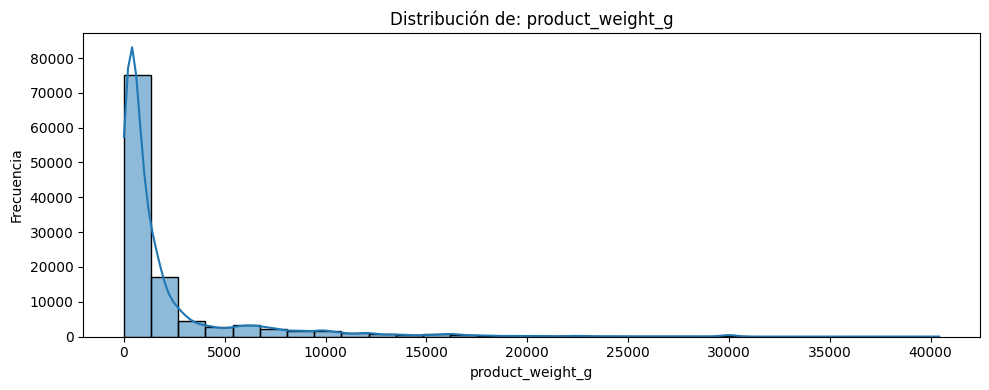

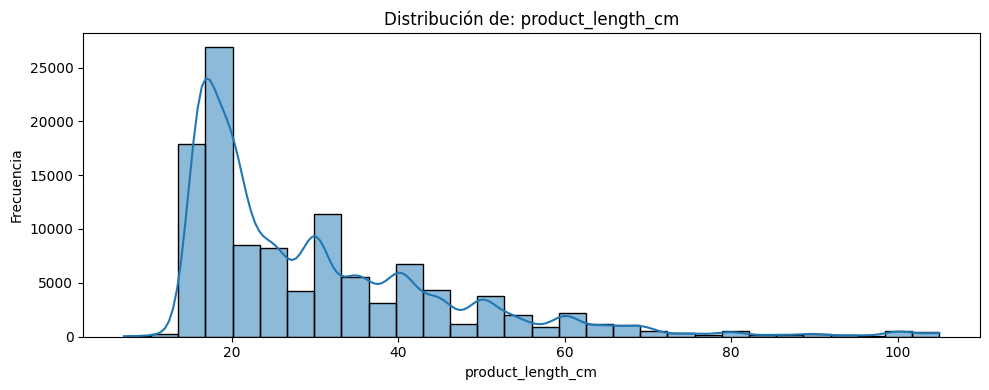

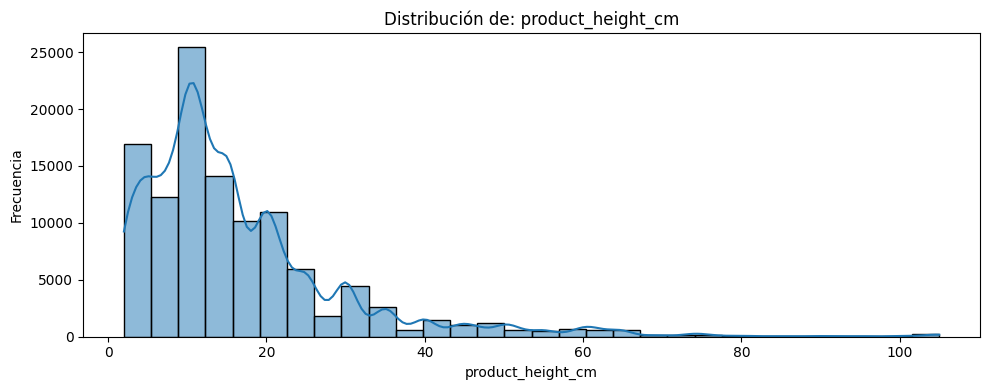

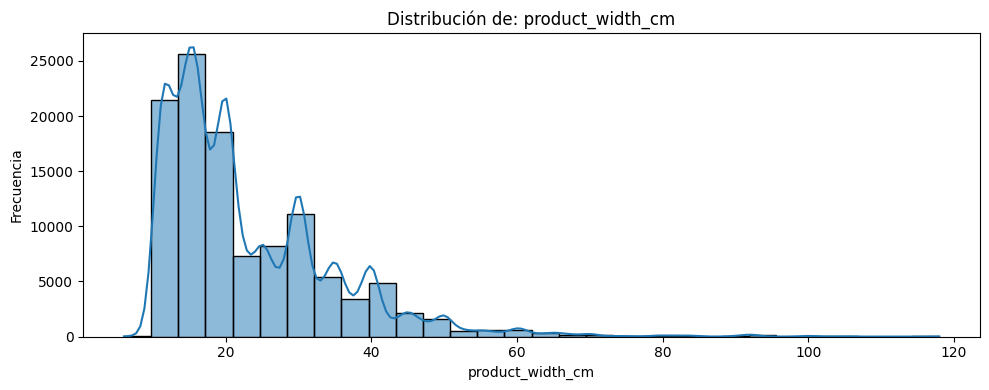

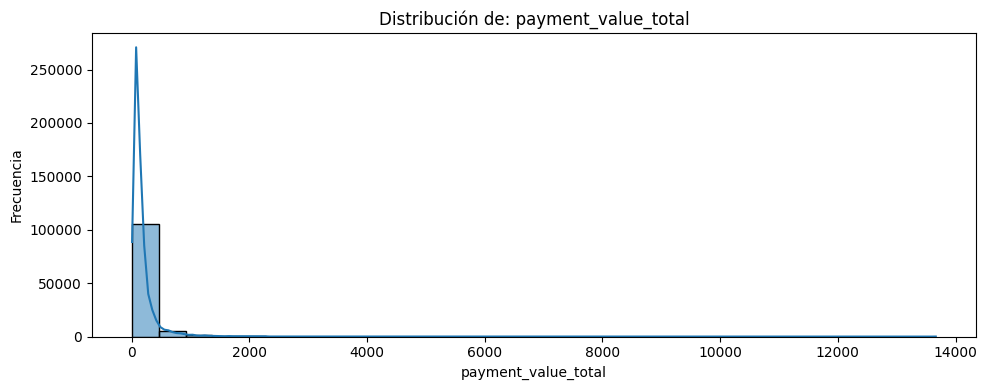

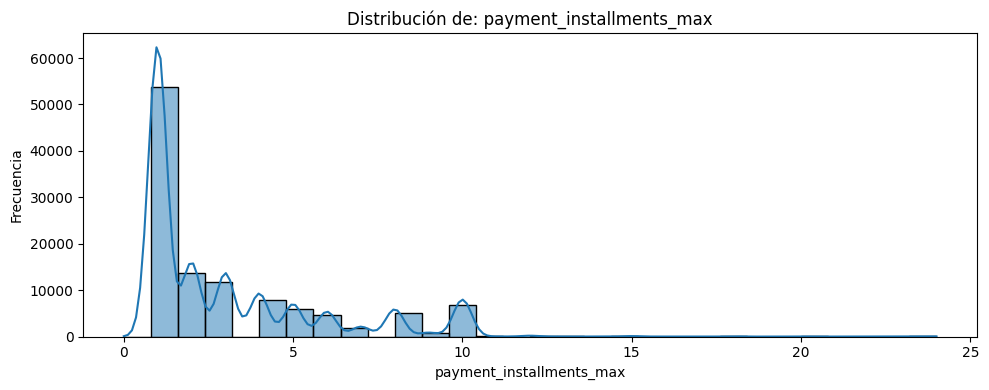

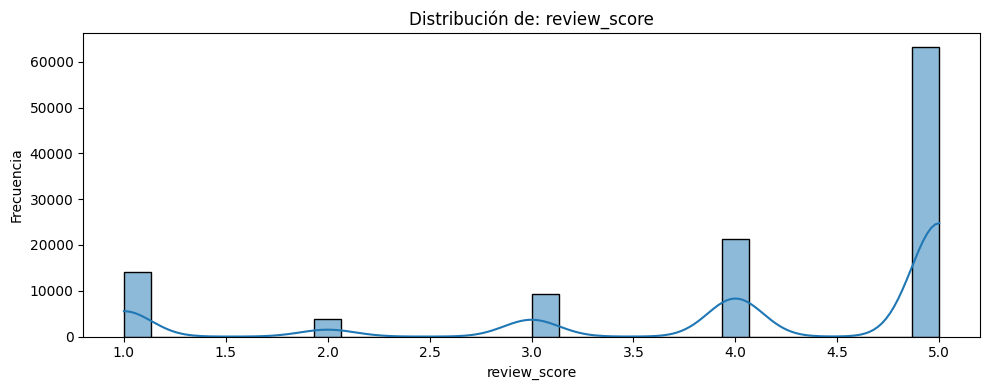

In [ ]:
# Define numerical columns for fact_order_items
cols_numericas_fact_order_items = fact_order_items.select_dtypes(include=['number']).columns.tolist()

# Exclude ID columns, binary variables, and transformation columns from fact_order_items
exclude_from_hist_items = [
    'order_id', 'order_item_id', 'product_id', 'seller_id', 'customer_id',
    'customer_zip_code_prefix', 'seller_zip_code_prefix',
    'boxcox_price', 'z_score_price_boxcox', 'z_score_price', 'boxcox_imputed_price', 'cleaned_price',
    'yeojohnson_freight_value', 'z_score_freight_value_yeojohnson', 'z_score_freight_value', 'freight_value_orig',
    'boxcox_product_name_lenght', 'z_score_product_name_lenght_boxcox', 'z_score_product_name_lenght', 'boxcox_imputed_product_name_lenght', 'cleaned_product_name_lenght',
    'boxcox_product_description_lenght', 'z_score_product_description_lenght_boxcox', 'z_score_product_description_lenght', 'boxcox_imputed_product_description_lenght', 'cleaned_product_description_lenght',
    'boxcox_product_photos_qty', 'z_score_product_photos_qty_boxcox', 'z_score_product_photos_qty', 'boxcox_imputed_product_photos_qty', 'cleaned_product_photos_qty',
    'yeojohnson_product_weight_g', 'z_score_product_weight_g_yeojohnson', 'z_score_product_weight_g', 'product_weight_g_orig',
    'boxcox_product_length_cm', 'z_score_product_length_cm_boxcox', 'z_score_product_length_cm', 'boxcox_imputed_product_length_cm', 'cleaned_product_length_cm',
    'boxcox_product_height_cm', 'z_score_product_height_cm_boxcox', 'z_score_product_height_cm', 'boxcox_imputed_product_height_cm', 'cleaned_product_height_cm',
    'boxcox_product_width_cm', 'z_score_product_width_cm_boxcox', 'z_score_product_width_cm', 'boxcox_imputed_product_width_cm', 'cleaned_product_width_cm',
    'boxcox_payment_value_total', 'z_score_payment_value_total_boxcox', 'z_score_payment_value_total', 'boxcox_imputed_payment_value_total', 'cleaned_payment_value_total',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'payment_value_total_orig',
    'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng', 'freight_percentage'
]

# Filter for relevant numerical columns
plot_cols_items = [col for col in cols_numericas_fact_order_items if col not in exclude_from_hist_items and not col.startswith(('boxcox_', 'yeojohnson_', 'z_score_', 'cleaned_', 'delivery_days_'))]

# histograma de variables numericas
for col in plot_cols_items:
    plt.figure(figsize=(10,4))
    sns.histplot(fact_order_items[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Bar charts for discrete numerical variables in fact_order_items:


/tmp/ipython-input-581830438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_order_items.dropna(subset=[col]), x=col, palette='magma')


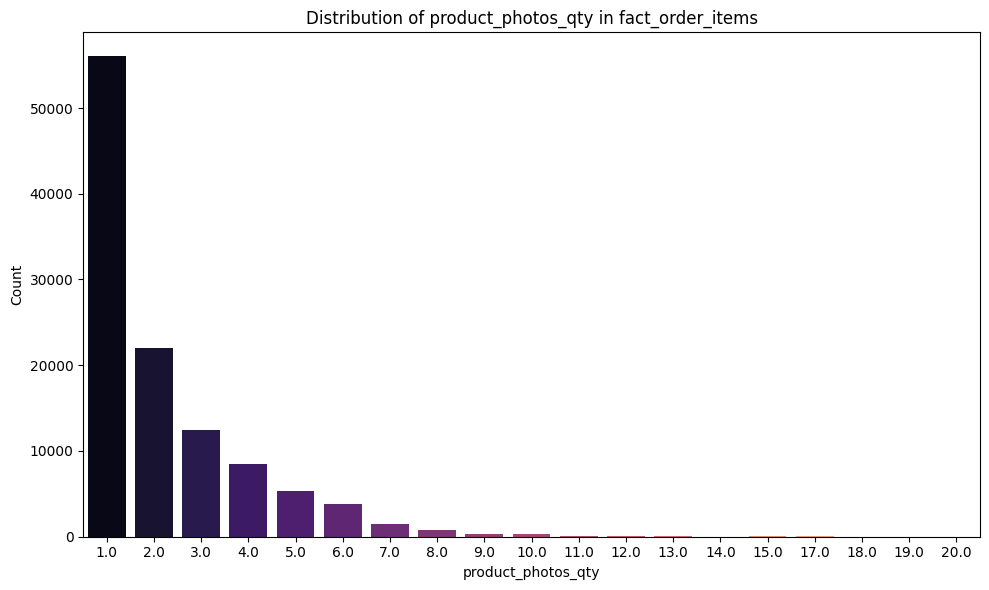

/tmp/ipython-input-581830438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_order_items.dropna(subset=[col]), x=col, palette='magma')


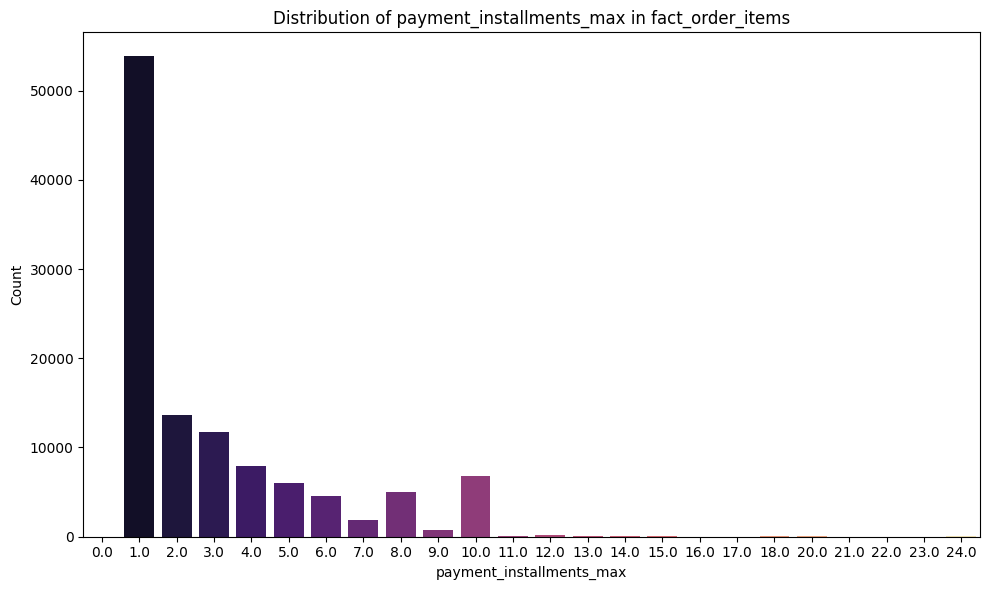

/tmp/ipython-input-581830438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_order_items.dropna(subset=[col]), x=col, palette='magma')


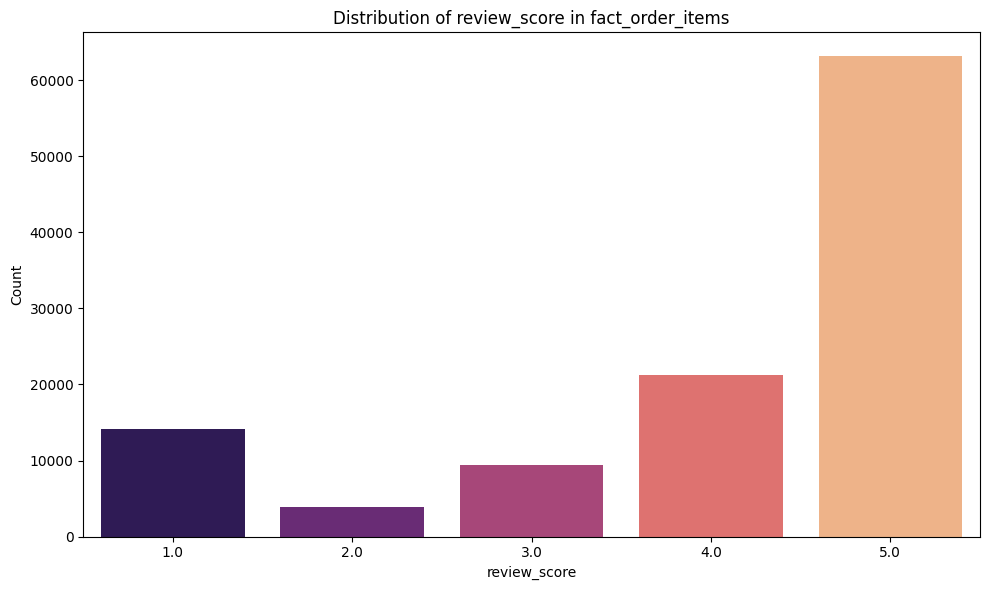

In [ ]:
discrete_for_bar_chart_items = ['product_photos_qty', 'payment_installments_max', 'review_score']

print("Bar charts for discrete numerical variables in fact_order_items:")
for col in discrete_for_bar_chart_items:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fact_order_items.dropna(subset=[col]), x=col, palette='magma')
    plt.title(f'Distribution of {col} in fact_order_items')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

###Análisis de duplicados, nulos y outliers.

In [ ]:
print("Checking for duplicates in original dataframes:")
print("Orders duplicates:", orders.duplicated().sum())
print("Items duplicates:", items.duplicated().sum())
print("Payments duplicates:", payments.duplicated().sum())
print("Reviews duplicates:", reviews.duplicated().sum())
print("Customers duplicates:", customers.duplicated().sum())
print("Sellers duplicates:", sellers.duplicated().sum())
print("Products duplicates:", products.duplicated().sum())
print("Geo duplicates:", geo.duplicated().sum())
print("Categories Translation duplicates:", cats_tr.duplicated().sum())

print("\nChecking for duplicates in aggregated dataframes:")
print("Fact Orders duplicates:", fact_orders.duplicated().sum())
print("Fact Order Items duplicates:", fact_order_items.duplicated().sum())

Checking for duplicates in original dataframes:
Orders duplicates: 0
Items duplicates: 0
Payments duplicates: 0
Reviews duplicates: 0
Customers duplicates: 0
Sellers duplicates: 0
Products duplicates: 0
Geo duplicates: 261831
Categories Translation duplicates: 0

Checking for duplicates in aggregated dataframes:
Fact Orders duplicates: 0
Fact Order Items duplicates: 0


In [ ]:
def top_nulls(df, k=10):
    return (df.isna().mean().mul(100).round(2)
            .sort_values(ascending=False).head(k))

print("Nulos fact_orders (top 10):\n", top_nulls(fact_orders))
print("\nNulos fact_order_items (top 10):\n", top_nulls(fact_order_items))

Nulos fact_orders (top 10):
 review_comment_title             88.38
review_comment_message           58.93
order_delivered_customer_date     2.98
delivery_days                     2.98
order_delivered_carrier_date      1.79
review_score                      0.77
review_answer_timestamp           0.77
review_creation_date              0.77
customer_lat                      0.28
customer_lng                      0.28
dtype: float64

Nulos fact_order_items (top 10):
 review_comment_title             88.09
review_comment_message           57.86
order_delivered_customer_date     2.18
product_category_name_english     1.44
product_category_name             1.42
product_description_lenght        1.42
product_name_lenght               1.42
product_photos_qty                1.42
review_answer_timestamp           0.84
review_creation_date              0.84
dtype: float64


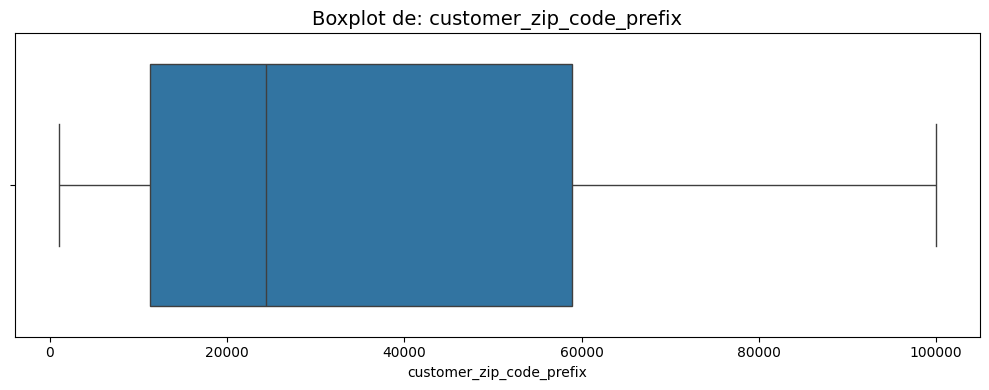

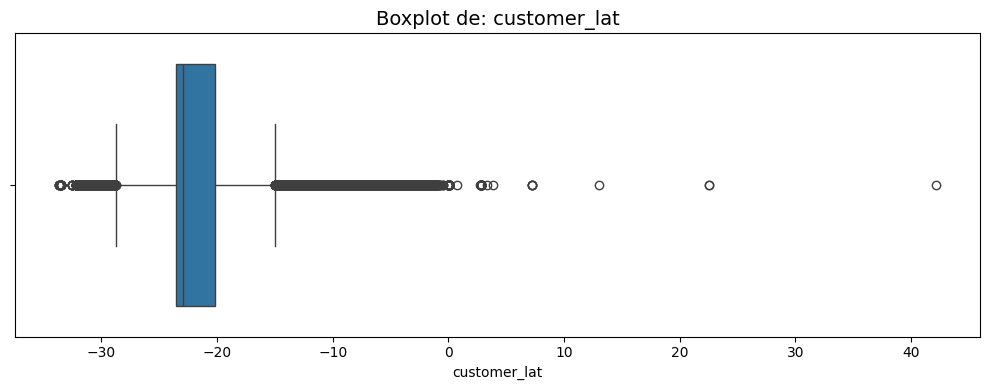

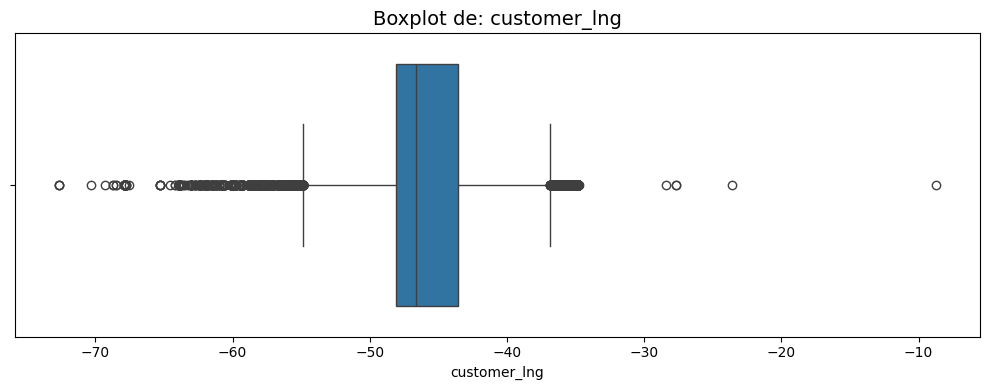

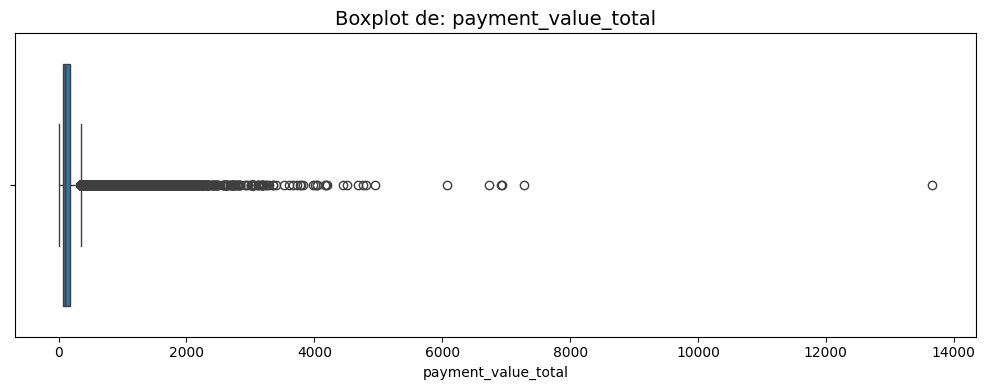

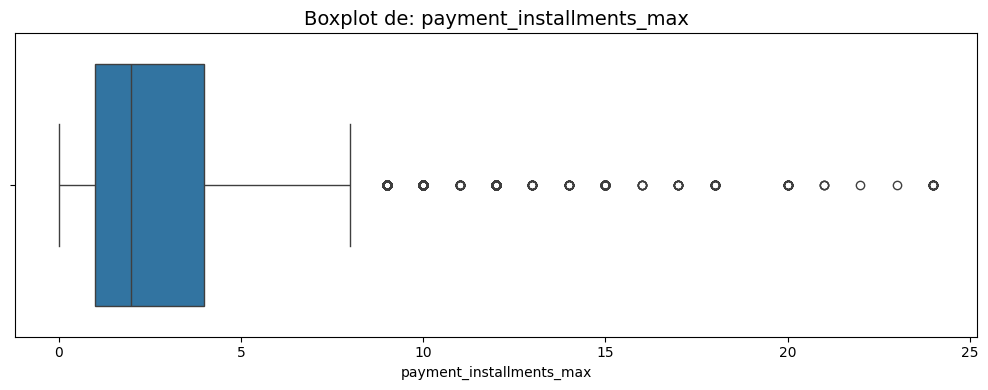

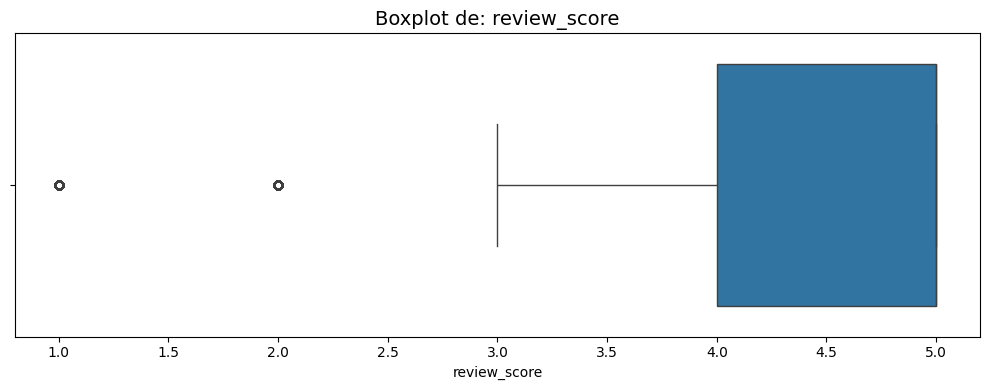

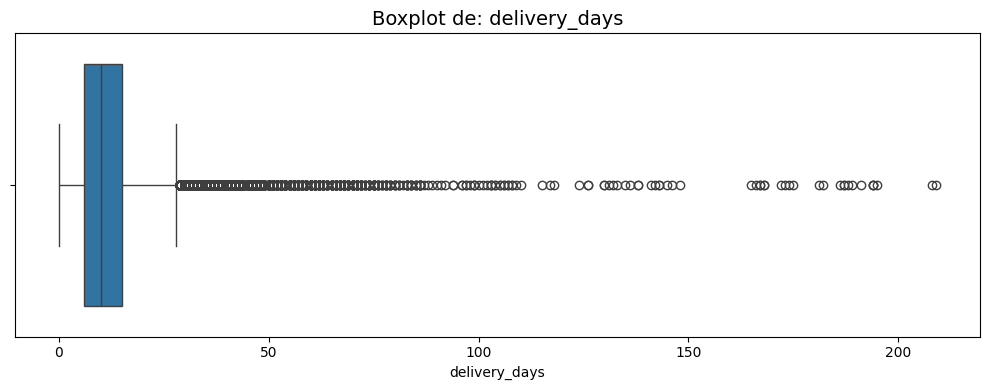

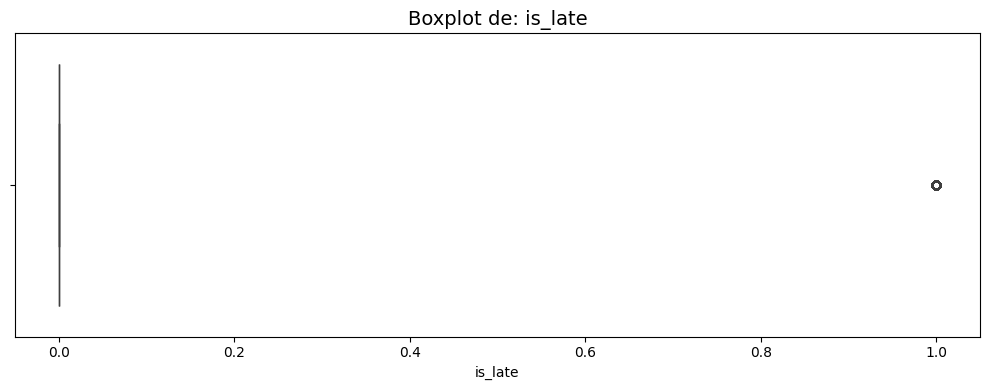

In [ ]:
# boxplots para detectar outliers y ver la distribucion de las variables

cols_numericas_fact_orders = fact_orders.select_dtypes(include='number').columns
cols_numericas_fact_order_items = fact_order_items.select_dtypes(include='number').columns

for col in cols_numericas_fact_orders:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=fact_orders, x=col)
    plt.title(f"Boxplot de: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

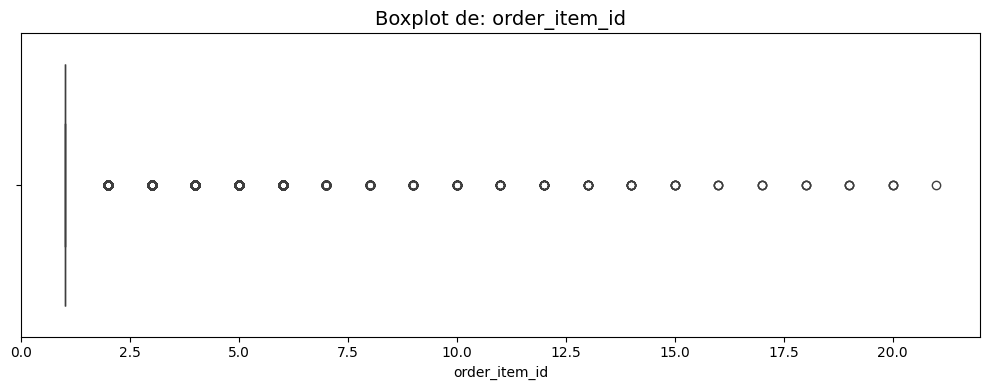

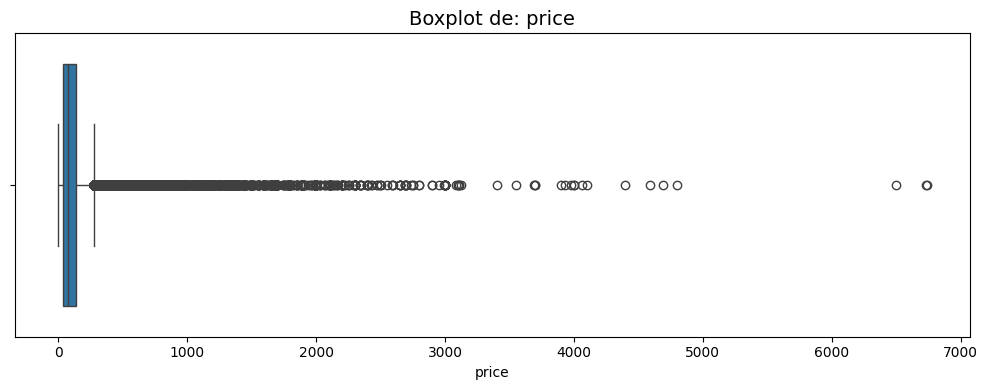

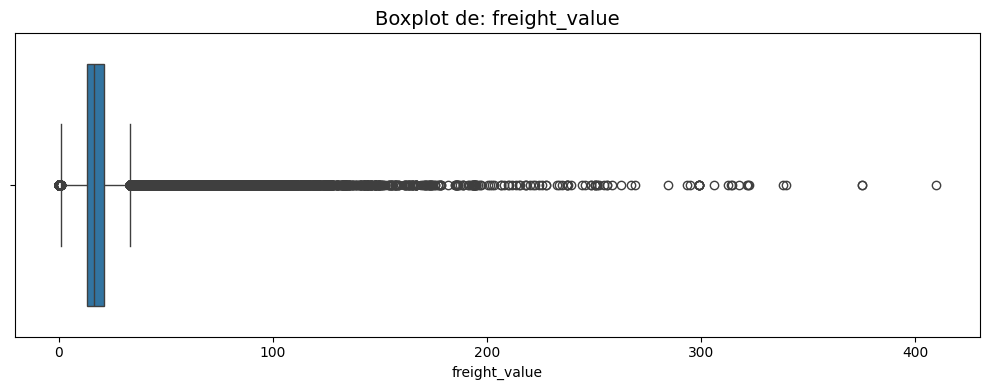

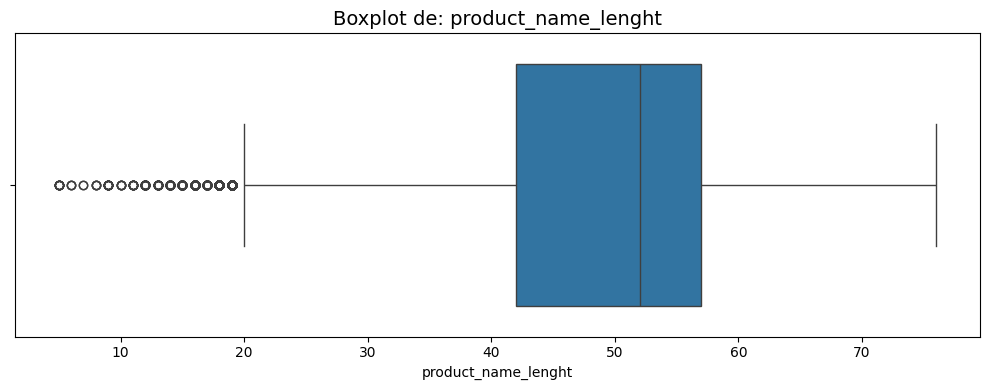

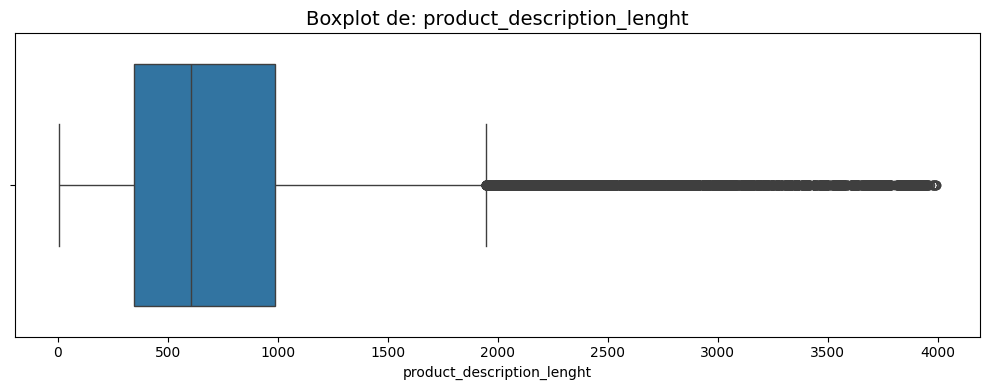

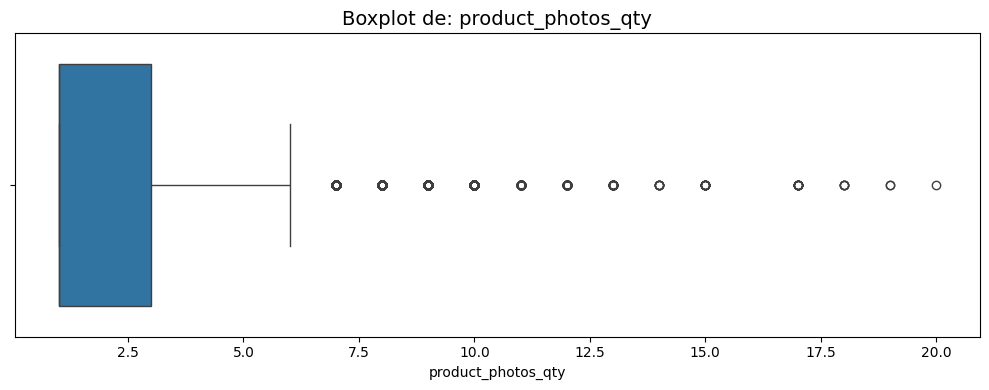

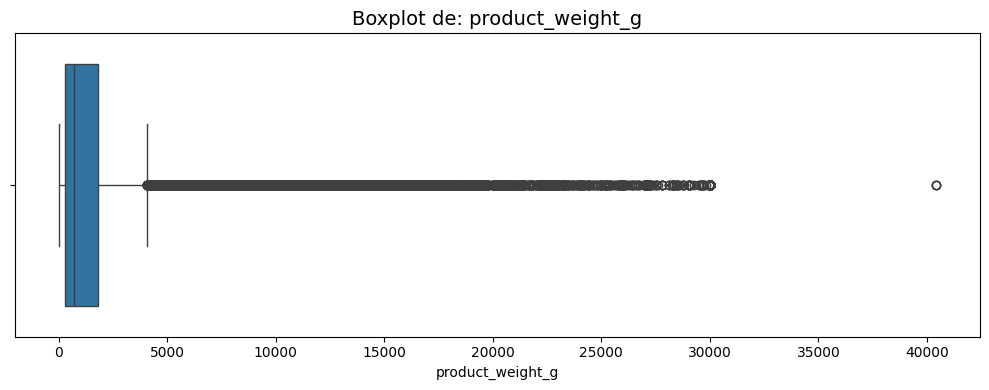

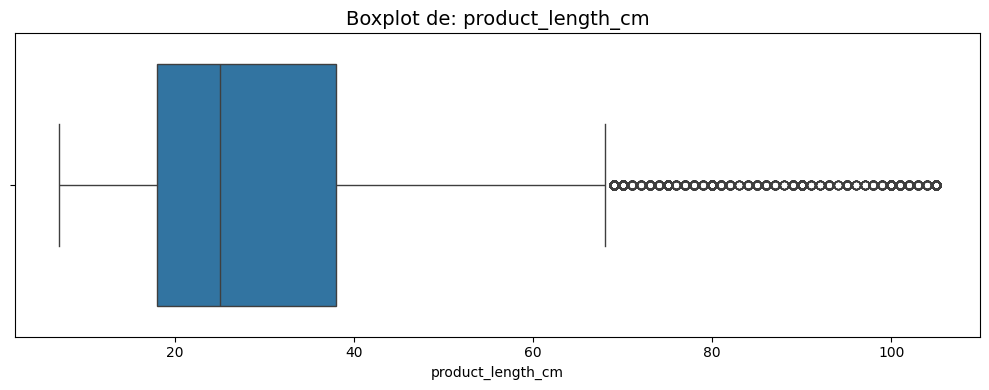

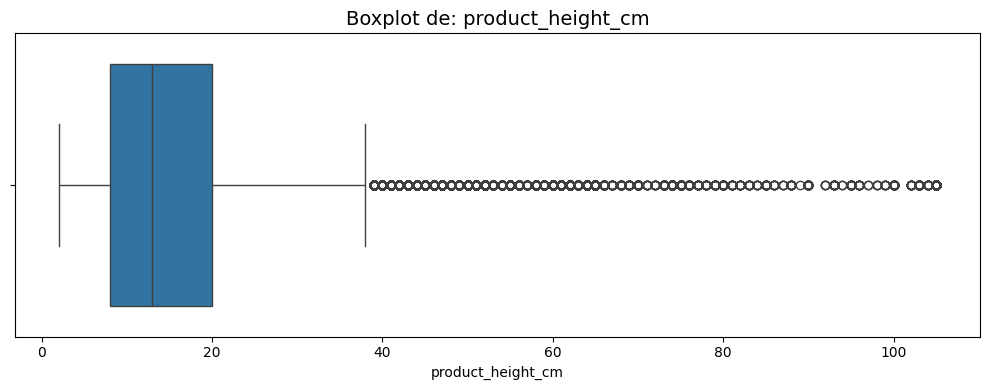

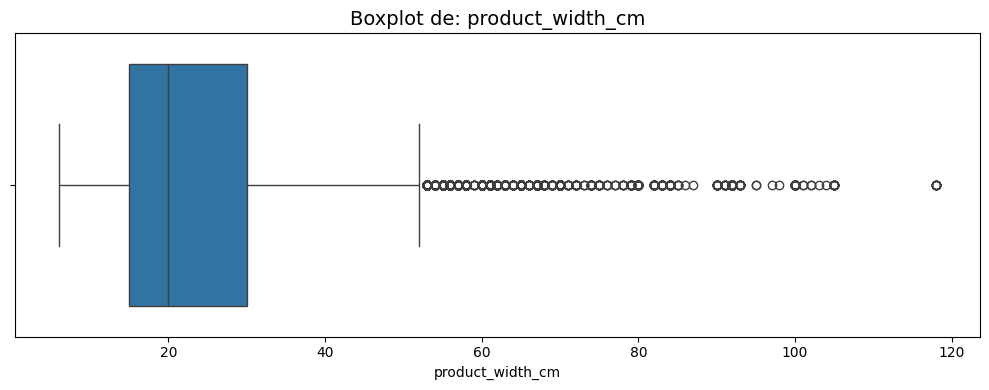

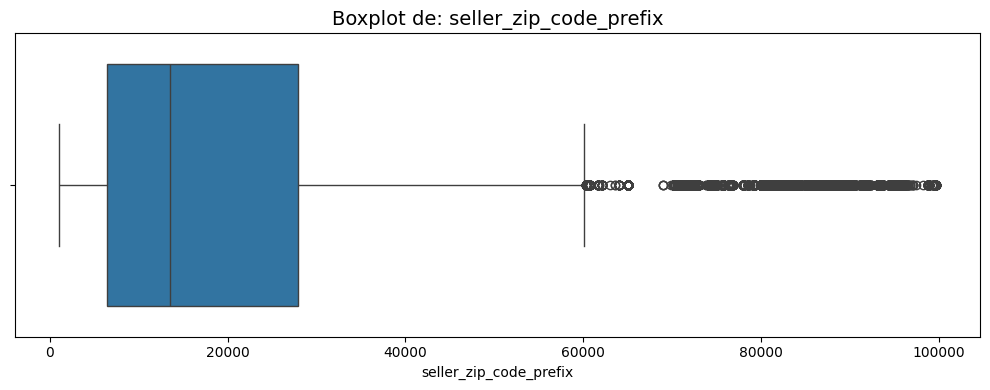

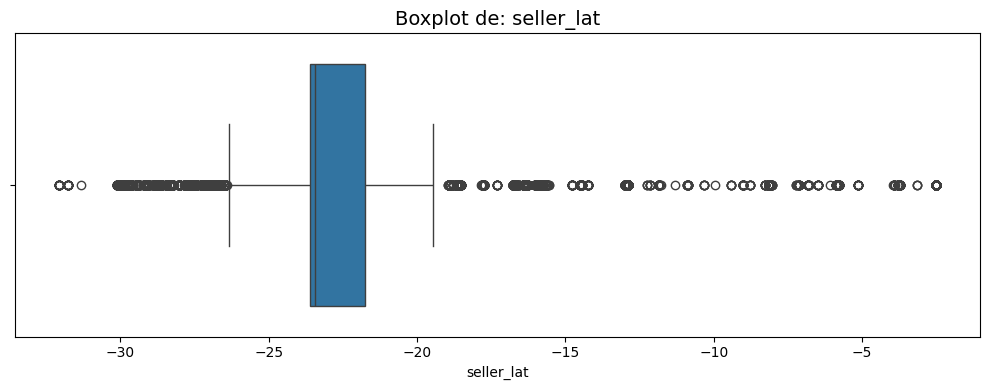

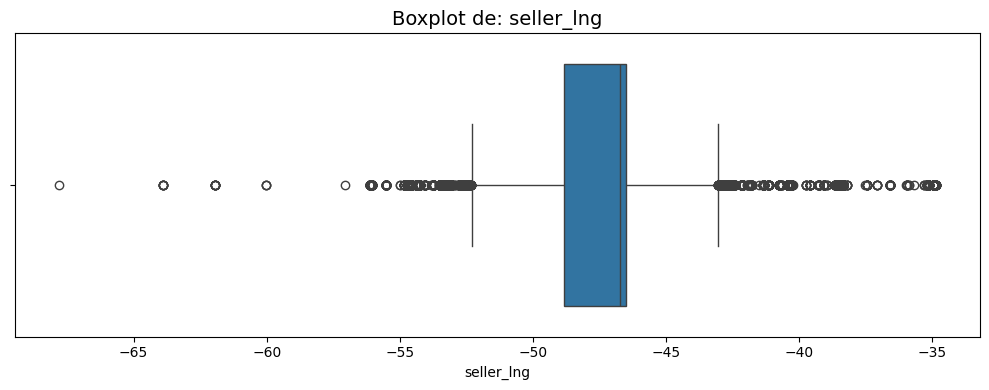

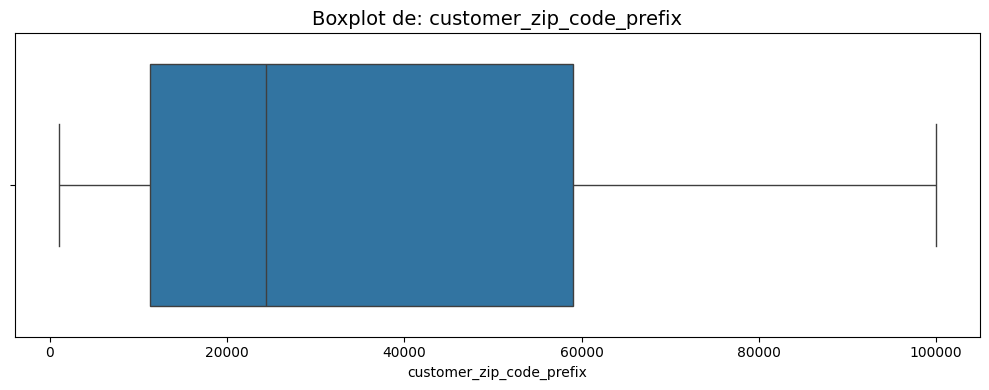

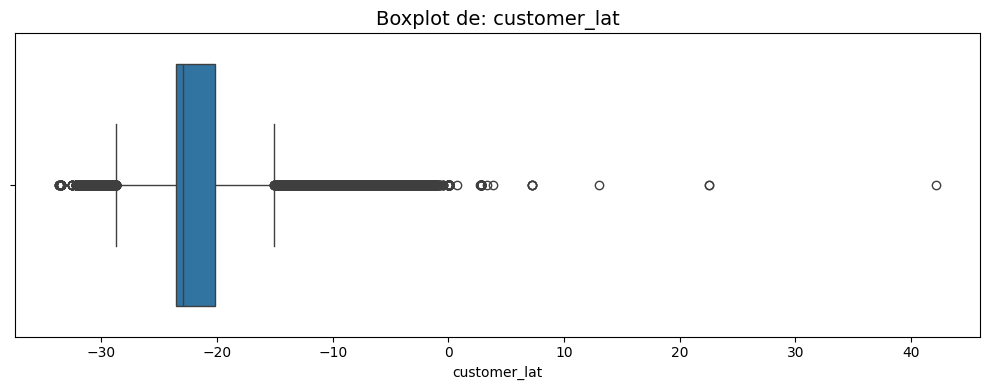

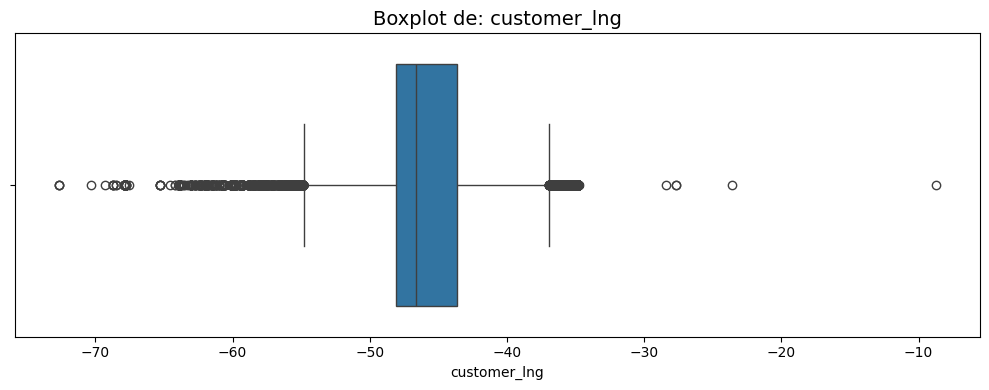

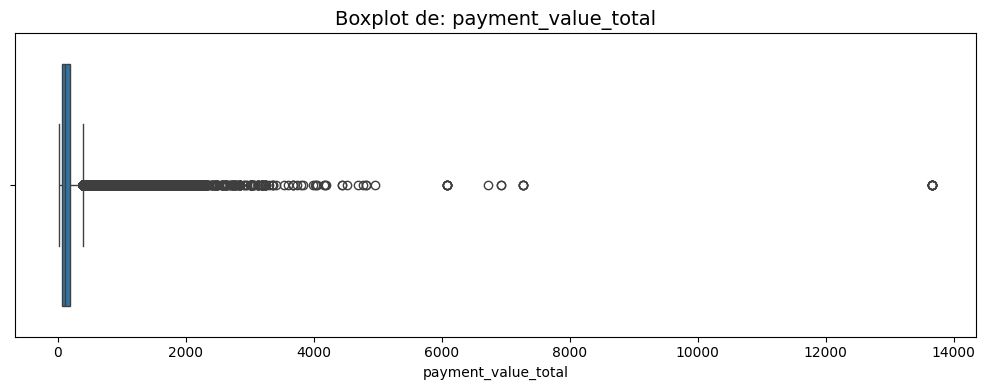

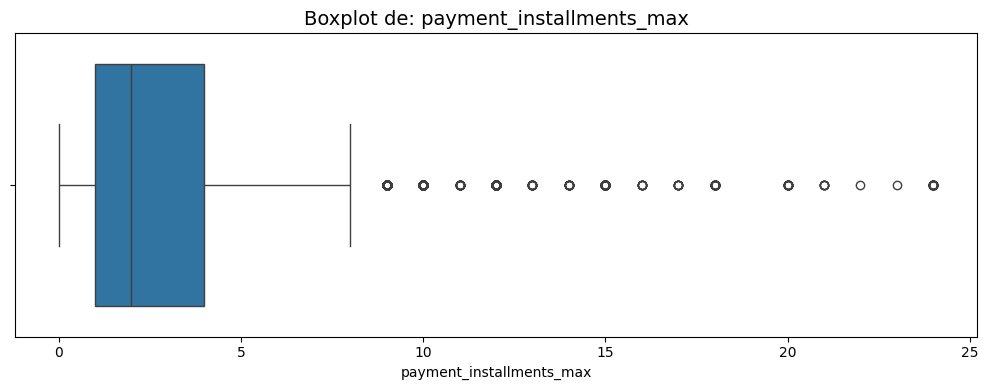

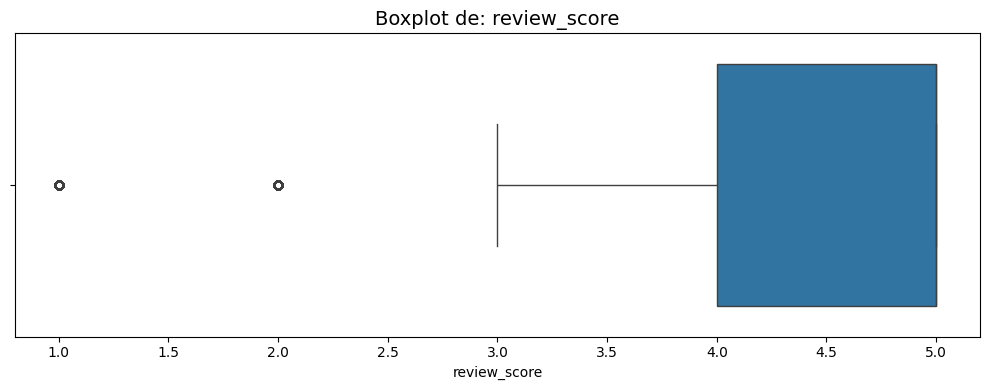

In [ ]:
for col in cols_numericas_fact_order_items:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=fact_order_items, x=col)
    plt.title(f"Boxplot de: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
# funcion para detectar outliers usando IQR
def detectar_outliers_iqr(df, columna, severos = False):
    if severos == True:
      sep = 3
    else:
      sep = 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - sep * IQR
    limite_superior = Q3 + sep * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers.index

qOutliers = 0
qOutliersSeveros = 0
df_outliers_severos = pd.DataFrame()

cols_numericas_fact_orders_no_geo = [col for col in cols_numericas_fact_orders if 'lat' not in col and 'lng' not in col]

for col in cols_numericas_fact_orders_no_geo:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    print(f"{col}: {len(outliers)} outliers totales ({len(outliers) / len(fact_orders) * 100:.2f}%)",
          f" y {len(outliers_severos)} outliers severos ({len(outliers_severos) / len(fact_orders) * 100:.2f}%)",sep='')
    qOutliers+= len(outliers)
    qOutliersSeveros+= len(outliers_severos)
    outliers_severos = pd.Series(outliers_severos.tolist())
    df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])

print(f'En total hay {qOutliers} outliers y {qOutliersSeveros} outliers severos')

customer_zip_code_prefix: 0 outliers totales (0.00%) y 0 outliers severos (0.00%)
payment_value_total: 7866 outliers totales (7.91%) y 3999 outliers severos (4.02%)
payment_installments_max: 6300 outliers totales (6.34%) y 169 outliers severos (0.17%)
review_score: 14493 outliers totales (14.57%) y 0 outliers severos (0.00%)
delivery_days: 5025 outliers totales (5.05%) y 1320 outliers severos (1.33%)
En total hay 33684 outliers y 5488 outliers severos


In [ ]:
qOutliers = 0
qOutliersSeveros = 0
df_outliers_severos = pd.DataFrame()

cols_numericas_fact_order_items_no_geo = [col for col in cols_numericas_fact_order_items if 'lat' not in col and 'lng' not in col]

for col in cols_numericas_fact_order_items_no_geo:
    outliers = detectar_outliers_iqr(fact_order_items, col)
    outliers_severos = detectar_outliers_iqr(fact_order_items, col, severos=True)
    print(f"{col}: {len(outliers)} outliers totales ({len(outliers) / len(fact_order_items) * 100:.2f}%)",
          f" y {len(outliers_severos)} outliers severos ({len(outliers_severos) / len(fact_order_items) * 100:.2f}%)",sep='')
    qOutliers+= len(outliers)
    qOutliersSeveros+= len(outliers_severos)
    outliers_severos = pd.Series(outliers_severos.tolist())
    df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])

print(f'En total hay {qOutliers} outliers y {qOutliersSeveros} outliers severos')

order_item_id: 13984 outliers totales (12.41%) y 13984 outliers severos (12.41%)
price: 8427 outliers totales (7.48%) y 4074 outliers severos (3.62%)
freight_value: 12134 outliers totales (10.77%) y 5538 outliers severos (4.92%)
product_name_lenght: 772 outliers totales (0.69%) y 0 outliers severos (0.00%)
product_description_lenght: 7011 outliers totales (6.22%) y 2285 outliers severos (2.03%)
product_photos_qty: 3073 outliers totales (2.73%) y 532 outliers severos (0.47%)
product_weight_g: 15807 outliers totales (14.03%) y 11106 outliers severos (9.86%)
product_length_cm: 3617 outliers totales (3.21%) y 988 outliers severos (0.88%)


/tmp/ipython-input-257585291.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])
/tmp/ipython-input-257585291.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])


product_height_cm: 7670 outliers totales (6.81%) y 2723 outliers severos (2.42%)
product_width_cm: 2563 outliers totales (2.28%) y 414 outliers severos (0.37%)
seller_zip_code_prefix: 17384 outliers totales (15.43%) y 1231 outliers severos (1.09%)
customer_zip_code_prefix: 0 outliers totales (0.00%) y 0 outliers severos (0.00%)
payment_value_total: 9200 outliers totales (8.17%) y 4911 outliers severos (4.36%)
payment_installments_max: 7985 outliers totales (7.09%) y 222 outliers severos (0.20%)
review_score: 17986 outliers totales (15.97%) y 0 outliers severos (0.00%)
En total hay 127613 outliers y 48008 outliers severos


/tmp/ipython-input-257585291.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])


##Preprocesamiento inicial

###Tratamiento de nulos, duplicados y outliers. Definición de criterios de imputación y justificación.

En el caso de la latitud y longitud, decidimos excluirlos del analisis de outliers porque son direcciones y consideramos que no debiamos incluirlos.

In [ ]:
fact_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  int64         
 10  customer_city                  99441 non-null  object        
 11  customer_state 

In [ ]:
fact_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  datetime64[ns]
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   product_category_name          111047 non-null  object        
 8   product_name_lenght            111047 non-null  float64       
 9   product_description_lenght     111047 non-null  float64       
 10  product_photos_qty             111047 non-null  float64       
 11  

Analyzing fact_orders:
Variable: payment_value_total
Shapiro-Wilk p-Valor: 4.035088331009864e-79
Variable: delivery_days
Shapiro-Wilk p-Valor: 4.856567782340027e-72


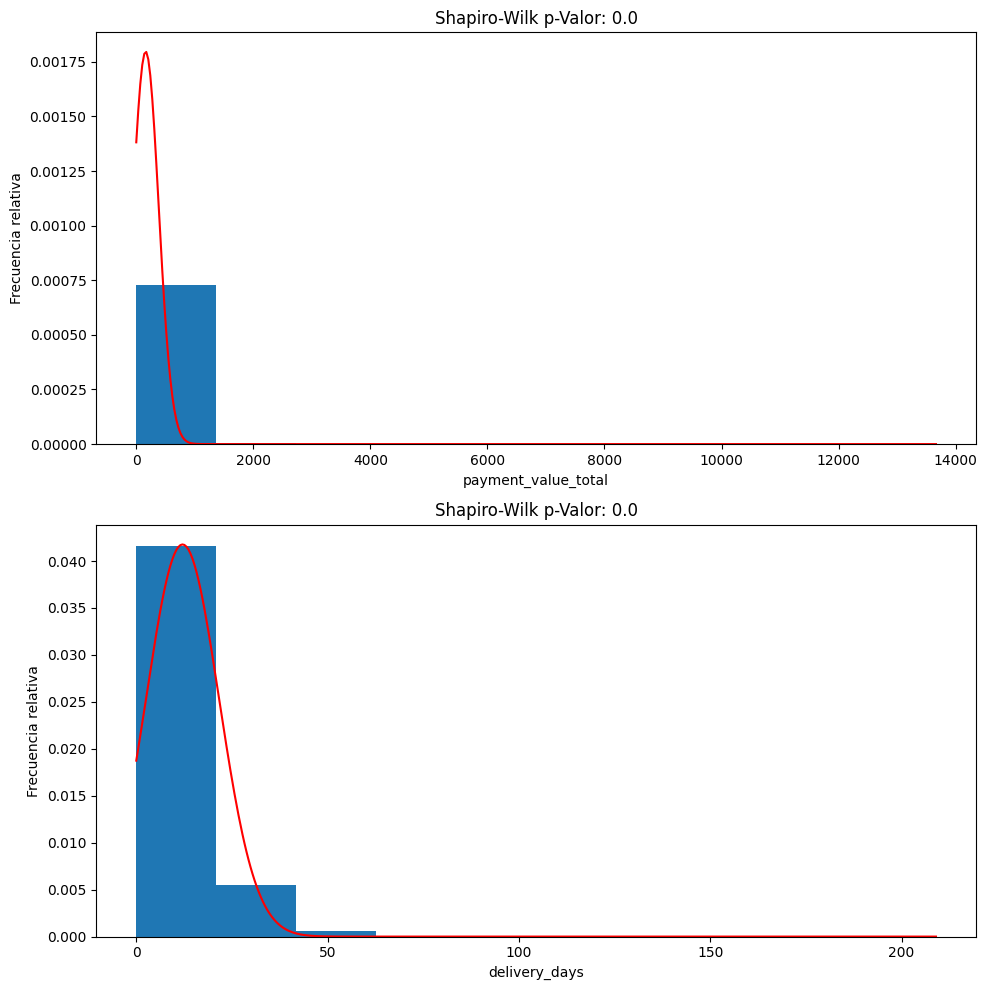


Analyzing fact_order_items:
Variable: price
Shapiro-Wilk p-Valor: 7.698705813401781e-83
Variable: freight_value
Shapiro-Wilk p-Valor: 3.5240030255072893e-75
Variable: product_name_lenght
Shapiro-Wilk p-Valor: 9.959865423568296e-48
Variable: product_description_lenght
Shapiro-Wilk p-Valor: 3.658990808675758e-61
Variable: product_photos_qty
Shapiro-Wilk p-Valor: 6.196933010587779e-67
Variable: product_weight_g
Shapiro-Wilk p-Valor: 1.0516169342551144e-77
Variable: product_length_cm
Shapiro-Wilk p-Valor: 2.4389832215581008e-60
Variable: product_height_cm
Shapiro-Wilk p-Valor: 2.2773813251694185e-61
Variable: product_width_cm
Shapiro-Wilk p-Valor: 8.923283940166571e-57
Variable: payment_value_total
Shapiro-Wilk p-Valor: 3.933306921559678e-80


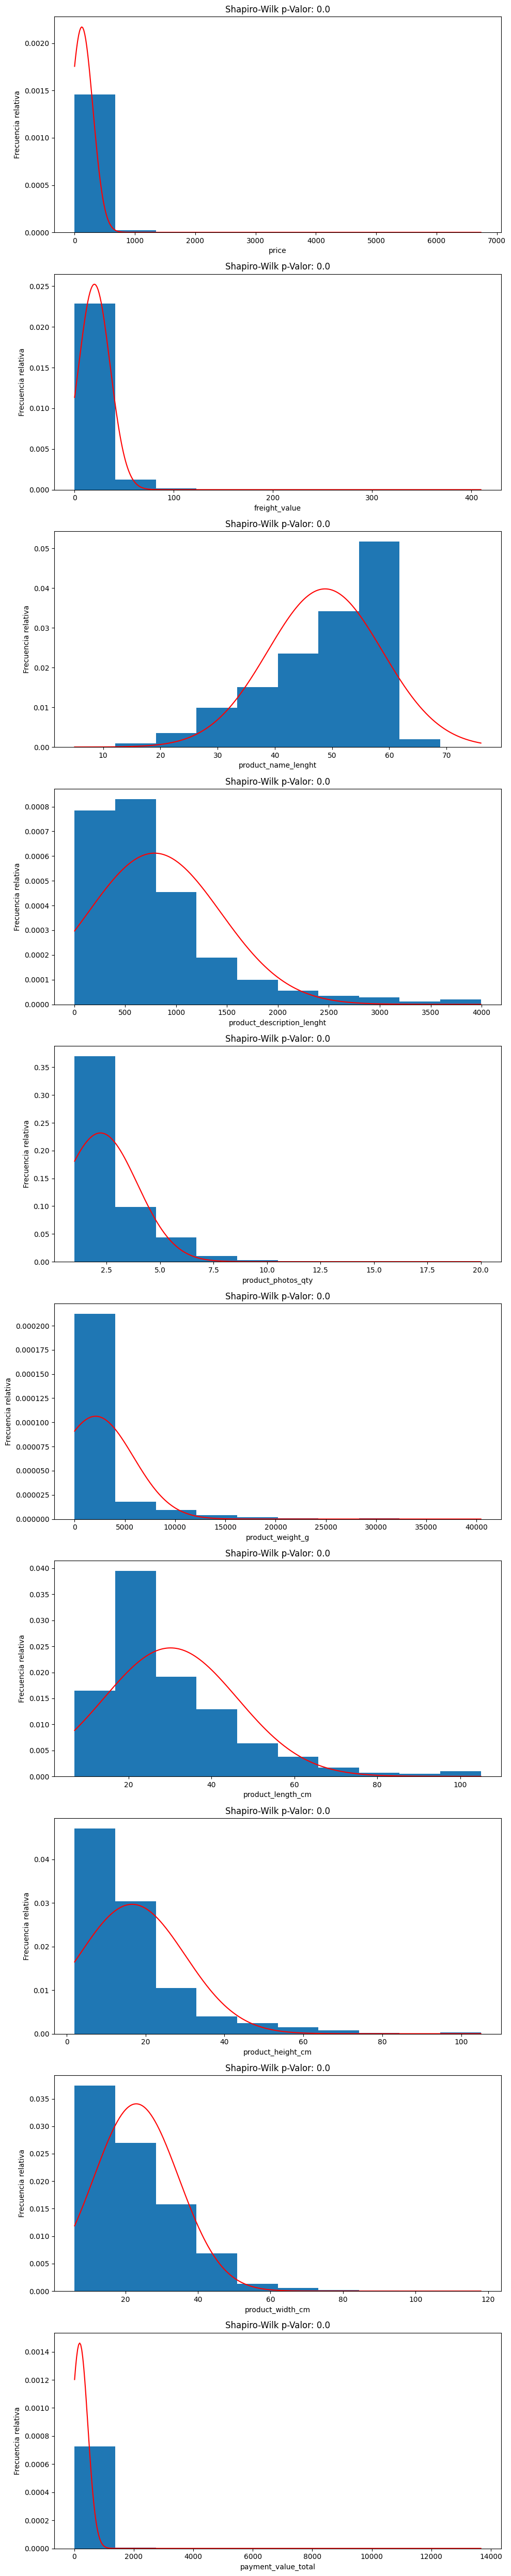

In [ ]:
# analizamos los outliers de las variables cuantitativas continuas
# para eso, primero tenemos que ver si son normales

# H0 es que la variable sigue una distribucion normal
# H1 es que no sigue una distribucion normal

# CONTINUAS:
continuous_cols_orders = ['payment_value_total', 'delivery_days']
continuous_cols_items = ['price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total']


print("Analyzing fact_orders:")
fig_orders, ax_orders = plt.subplots(len(continuous_cols_orders), 1, figsize=(10, 5 * len(continuous_cols_orders)))

for i, col in enumerate(continuous_cols_orders):
  data_filtered = fact_orders[col].replace([np.inf, -np.inf], np.nan).dropna()

  if len(data_filtered) > 0:
    muVar, sVar = stats.norm.fit(data_filtered)
    mAux = data_filtered.min()
    MAux = data_filtered.max()

    if len(data_filtered) > 5000:
        pvAux = stats.shapiro(data_filtered.sample(5000, random_state=42)).pvalue
    else:
        pvAux = stats.shapiro(data_filtered).pvalue

    print(f"Variable: {col}")
    print(f"Shapiro-Wilk p-Valor: {pvAux}")

    xseq = np.linspace(mAux, MAux, 400)
    yseq = stats.norm(muVar, sVar).pdf(xseq)

    ax_orders[i].hist(data_filtered, density=True)
    ax_orders[i].plot(xseq, yseq, c="r")
    ax_orders[i].set_ylabel("Frecuencia relativa")
    ax_orders[i].set_xlabel(col)
    ax_orders[i].set_title(f"Shapiro-Wilk p-Valor: {np.round(pvAux, 10)}")
  else:
      print(f"Variable: {col} has no valid data after filtering.")


fig_orders.tight_layout()
plt.show()

print("\nAnalyzing fact_order_items:")
fig_items, ax_items = plt.subplots(len(continuous_cols_items), 1, figsize=(10, 5 * len(continuous_cols_items)))

for i, col in enumerate(continuous_cols_items):
  data_filtered = fact_order_items[col].replace([np.inf, -np.inf], np.nan).dropna()

  if len(data_filtered) > 0:
    muVar, sVar = stats.norm.fit(data_filtered)
    mAux = data_filtered.min()
    MAux = data_filtered.max()

    if len(data_filtered) > 5000:
        pvAux = stats.shapiro(data_filtered.sample(5000, random_state=42)).pvalue
    else:
        pvAux = stats.shapiro(data_filtered).pvalue

    print(f"Variable: {col}")
    print(f"Shapiro-Wilk p-Valor: {pvAux}")

    xseq = np.linspace(mAux, MAux, 400)
    yseq = stats.norm(muVar, sVar).pdf(xseq)

    ax_items[i].hist(data_filtered, density=True)
    ax_items[i].plot(xseq, yseq, c="r")
    ax_items[i].set_ylabel("Frecuencia relativa")
    ax_items[i].set_xlabel(col)
    ax_items[i].set_title(f"Shapiro-Wilk p-Valor: {np.round(pvAux, 10)}")
  else:
      print(f"Variable: {col} has no valid data after filtering.")

fig_items.tight_layout()
plt.show()

In [ ]:
# analizamos los outliers de las variables cuantitativas continuas
# ahora, como NO son normales, aplicamos boxcox y luego buscamos los outliers con z score y umbral de 4 desviaciones estandar sobre la media

continuous_cols_orders = ['payment_value_total', 'delivery_days']
continuous_cols_items = ['price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total']


def aplicar_boxcox_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # 1) Transformación Box–Cox (requiere > 0)
        # Filter out non-positive values for Box-Cox
        data_positive = df[col].dropna()
        if (data_positive <= 0).any():
            print(f"Column '{col}' contains non-positive values. Cannot apply Box-Cox directly.")
            # You might consider a different transformation or handle these values
            continue

        sin_na = data_positive
        data_bc, lambda_bc = boxcox(sin_na)

        # Alinear índices
        df[f"boxcox_{col}"] = np.nan
        df.loc[sin_na.index, f"boxcox_{col}"] = data_bc

        # 2) Z-score en Box–Cox
        df[f"z_score_{col}_boxcox"] = zscore(df[f"boxcox_{col}"], nan_policy="omit")
        mask_out_bc = np.abs(df[f"z_score_{col}_boxcox"]) > z_thresh

        # 3) Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # 4) Imputación: mediana en espacio Box–Cox (sobre NO-outliers)
        median_bc = np.median(df.loc[~mask_out_bc, f"boxcox_{col}"].dropna()) #dropna() added
        df[f"boxcox_imputed_{col}"] = df[f"boxcox_{col}"].copy()
        df.loc[mask_out_bc, f"boxcox_imputed_{col}"] = median_bc

        # 5) Volver a escala original
        # Ensure lambda_bc is not close to zero before inverse transformation
        if abs(lambda_bc) > 1e-9:
             df[f"cleaned_{col}"] = inv_boxcox(df[f"boxcox_imputed_{col}"], lambda_bc)
        else:
             # Handle the case where lambda is close to zero (log transformation)
             df[f"cleaned_{col}"] = np.exp(df[f"boxcox_imputed_{col}"])


        # 6) Reemplazar en variable original SOLO donde había outliers (según Box–Cox)
        df.loc[mask_out_bc, col] = df.loc[mask_out_bc, f"cleaned_{col}"]

        print(f"Cantidad de outliers en {col} con Box–Cox (|z|>{z_thresh}): {int(mask_out_bc.sum())}")
        print(f"Cantidad de outliers en {col} sin Box–Cox (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

# Apply to fact_orders
print("Applying Box-Cox and Z-score outlier detection to fact_orders:")
aplicar_boxcox_z_score_outliers(fact_orders, [], z_thresh=4.0)

# Apply to fact_order_items
print("\nApplying Box-Cox and Z-score outlier detection to fact_order_items:")
aplicar_boxcox_z_score_outliers(fact_order_items, continuous_cols_items, z_thresh=4.0)

Applying Box-Cox and Z-score outlier detection to fact_orders:

Applying Box-Cox and Z-score outlier detection to fact_order_items:
Cantidad de outliers en price con Box–Cox (|z|>4.0): 1
Cantidad de outliers en price sin Box–Cox (|z|>4.0): 1268
--------------------------------------------------
Column 'freight_value' contains non-positive values. Cannot apply Box-Cox directly.
Cantidad de outliers en product_name_lenght con Box–Cox (|z|>4.0): 0
Cantidad de outliers en product_name_lenght sin Box–Cox (|z|>4.0): 18
--------------------------------------------------
Cantidad de outliers en product_description_lenght con Box–Cox (|z|>4.0): 0
Cantidad de outliers en product_description_lenght sin Box–Cox (|z|>4.0): 1109
--------------------------------------------------
Cantidad de outliers en product_photos_qty con Box–Cox (|z|>4.0): 0
Cantidad de outliers en product_photos_qty sin Box–Cox (|z|>4.0): 532
--------------------------------------------------
Column 'product_weight_g' contains 

Podemos ver que hay algunas variables que tienen valores negativos, por lo tanto aplicaremos Yeo Johnson en vez de Box Cox.

In [ ]:
# ahora usamos yeo johnson

continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']
continuous_cols_items_yeo = ['freight_value', 'product_weight_g', 'payment_value_total']

def aplicar_yeojohnson_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # Transformación Yeo–Johnson (admite <= 0)
        sin_na = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(sin_na) == 0:
            print(f"Column '{col}' has no valid data after dropping NaNs. Skipping.")
            continue

        data_yj, lambda_yj = yeojohnson(sin_na)

        # Alinear índices para guardar resultados
        df[f"yeojohnson_{col}"] = np.nan
        df.loc[sin_na.index, f"yeojohnson_{col}"] = data_yj

        # Z-score en Yeo–Johnson
        df[f"z_score_{col}_yeojohnson"] = zscore(df[f"yeojohnson_{col}"], nan_policy="omit")
        mask_out_yj = np.abs(df[f"z_score_{col}_yeojohnson"]) > z_thresh

        # Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # Mediana en escala original usando NO-outliers (según YJ)
        med_orig = df.loc[~mask_out_yj, col].median()
        # Respaldo
        df[f"{col}_orig"] = df[col].copy()
        # Si la columna es entera, mantener tipo
        med_use = int(round(med_orig)) if pd.api.types.is_integer_dtype(df[col].dtype) else med_orig
        # Reemplazo en la variable ORIGINAL solo donde hay outliers (según YJ)
        df.loc[mask_out_yj, col] = med_use

        print(f"Cantidad de outliers en {col} con Yeo–Johnson (|z|>{z_thresh}): {int(mask_out_yj.sum())}")
        print(f"Cantidad de outliers en {col} sin transformación (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

# Apply to fact_orders the columns that could not be processed by Box-Cox
print("Applying Yeo-Johnson and Z-score outlier detection to fact_orders:")
aplicar_yeojohnson_z_score_outliers(fact_orders, continuous_cols_orders_yeo, z_thresh=4.0)

# Apply to fact_order_items the columns that could not be processed by Box-Cox
print("\nApplying Yeo-Johnson and Z-score outlier detection to fact_order_items:")
aplicar_yeojohnson_z_score_outliers(fact_order_items, continuous_cols_items_yeo, z_thresh=4.0)

Applying Yeo-Johnson and Z-score outlier detection to fact_orders:
Cantidad de outliers en payment_value_total con Yeo–Johnson (|z|>4.0): 0
Cantidad de outliers en payment_value_total sin transformación (|z|>4.0): 1034
--------------------------------------------------
Cantidad de outliers en delivery_days con Yeo–Johnson (|z|>4.0): 3
Cantidad de outliers en delivery_days sin transformación (|z|>4.0): 694
--------------------------------------------------

Applying Yeo-Johnson and Z-score outlier detection to fact_order_items:
Cantidad de outliers en freight_value con Yeo–Johnson (|z|>4.0): 311
Cantidad de outliers en freight_value sin transformación (|z|>4.0): 1364
--------------------------------------------------
Cantidad de outliers en product_weight_g con Yeo–Johnson (|z|>4.0): 0
Cantidad de outliers en product_weight_g sin transformación (|z|>4.0): 1422
--------------------------------------------------
Cantidad de outliers en payment_value_total con Yeo–Johnson (|z|>4.0): 0
Cant

Aplicamos BoxCox y Yeo Johnson. Ahora vamos a imputar los outliers detectados.

In [ ]:
def chequear_outliers_post(df, cols_boxcox, cols_yeo, z_thresh=4.0):

    for col in cols_boxcox + cols_yeo:
        # b) Escala original (ya reemplazada)
        z_raw = zscore(pd.to_numeric(df[col], errors="coerce"), nan_policy="omit")
        rem_raw = int(np.nansum(np.abs(z_raw) > z_thresh))

        # a) Box–Cox imputado (si existe la columna)
        rem_bc = None
        bc_col = f"boxcox_imputed_{col}"
        if bc_col in df.columns:
            z_bc_imp = zscore(pd.to_numeric(df[bc_col], errors="coerce"), nan_policy="omit")
            rem_bc = int(np.nansum(np.abs(z_bc_imp) > z_thresh))

        # c) Yeo–Johnson (recalcular sobre la columna actual para chequear)
        x = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(x) >= 3 and x.std(ddof=1) > 0:
            yj_vals, _ = yeojohnson(x)              # solo para detección
            z_yj = zscore(yj_vals, nan_policy="omit")
            rem_yj = int(np.sum(np.abs(z_yj) > z_thresh))
        else:
            rem_yj = 0

        # Prints
        if rem_bc is not None:
            print(f"[{col}] Restantes en Box–Cox imputado (|z|>{z_thresh}): {rem_bc}")
        else:
            print(f"[{col}] Box–Cox imputado no disponible (no se encontró '{bc_col}').")

        print(f"[{col}] Restantes en Yeo–Johnson (|z|>{z_thresh}): {rem_yj}")
        print(f"[{col}] Restantes en escala original (|z|>{z_thresh}): {rem_raw}")
        print("-"*50)

continuous_cols_orders_boxcox = [] # No columns in fact_orders were processed with Box-Cox due to non-positive values
continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']

continuous_cols_items_boxcox = ['price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'product_width_cm']
continuous_cols_items_yeo = ['freight_value', 'product_weight_g', 'payment_value_total']


print("Checking remaining outliers in fact_orders:")
chequear_outliers_post(fact_orders, continuous_cols_orders_boxcox, continuous_cols_orders_yeo, z_thresh=4.0)

print("\nChecking remaining outliers in fact_order_items:")
chequear_outliers_post(fact_order_items, continuous_cols_items_boxcox, continuous_cols_items_yeo, z_thresh=4.0)

Checking remaining outliers in fact_orders:
[payment_value_total] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_payment_value_total').
[payment_value_total] Restantes en Yeo–Johnson (|z|>4.0): 0
[payment_value_total] Restantes en escala original (|z|>4.0): 1034
--------------------------------------------------
[delivery_days] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_delivery_days').
[delivery_days] Restantes en Yeo–Johnson (|z|>4.0): 0
[delivery_days] Restantes en escala original (|z|>4.0): 757
--------------------------------------------------

Checking remaining outliers in fact_order_items:
[price] Restantes en Box–Cox imputado (|z|>4.0): 0
[price] Restantes en Yeo–Johnson (|z|>4.0): 0
[price] Restantes en escala original (|z|>4.0): 1268
--------------------------------------------------
[product_name_lenght] Restantes en Box–Cox imputado (|z|>4.0): 0
[product_name_lenght] Restantes en Yeo–Johnson (|z|>4.0): 0
[product_name_lenght] Restantes e

Luego de imputar con la mediana, podemos ver que la cantidad de outliers queda en 0 en casi todos los casos o se reduce.

In [ ]:
##AHORA ANALIZAMOS LAS DISCRETAS

In [ ]:
# Identify discrete numerical columns in fact_orders
discrete_cols_orders = fact_orders.select_dtypes(include=['int64', 'Int8']).columns.tolist()
exclude_cols_orders = ['customer_zip_code_prefix', 'is_late'] # Exclude zip codes and binary variable

discrete_cols_to_analyze_orders = [col for col in discrete_cols_orders if col not in exclude_cols_orders]

print("Analyzing outliers in discrete numerical columns of fact_orders:")
discrete_cols_with_outliers_orders = []
for col in discrete_cols_to_analyze_orders:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    num_outliers = len(outliers)
    num_outliers_severos = len(outliers_severos)

    print(f"{col}: {num_outliers} outliers totales ({num_outliers / len(fact_orders) * 100:.2f}%)",
          f" y {num_outliers_severos} outliers severos ({num_outliers_severos / len(fact_orders) * 100:.2f}%)",sep='')

    if num_outliers > 0:
        discrete_cols_with_outliers_orders.append(col)

print("\nDiscrete columns in fact_orders identified with outliers:", discrete_cols_with_outliers_orders)

print("\n" + "="*50 + "\n")

# Identify discrete numerical columns in fact_order_items
discrete_cols_items = fact_order_items.select_dtypes(include=['int64', 'Int8']).columns.tolist()
exclude_cols_items = ['order_item_id', 'customer_zip_code_prefix', 'seller_zip_code_prefix'] # Exclude IDs and zip codes

discrete_cols_to_analyze_items = [col for col in discrete_cols_items if col not in exclude_cols_items]

print("Analyzing outliers in discrete numerical columns of fact_order_items:")
discrete_cols_with_outliers_items = []
for col in discrete_cols_to_analyze_items:
    outliers = detectar_outliers_iqr(fact_order_items, col)
    outliers_severos = detectar_outliers_iqr(fact_order_items, col, severos=True)
    num_outliers = len(outliers)
    num_outliers_severos = len(outliers_severos)
    print(f"{col}: {num_outliers} outliers totales ({num_outliers / len(fact_order_items) * 100:.2f}%)",
          f" y {num_outliers_severos} outliers severos ({num_outliers_severos / len(fact_order_items) * 100:.2f}%)",sep='')

    if num_outliers > 0:
        discrete_cols_with_outliers_items.append(col)

print("\nDiscrete columns in fact_order_items identified with outliers:", discrete_cols_with_outliers_items)

Analyzing outliers in discrete numerical columns of fact_orders:

Discrete columns in fact_orders identified with outliers: []


Analyzing outliers in discrete numerical columns of fact_order_items:

Discrete columns in fact_order_items identified with outliers: []


In [ ]:
fact_tables = {
    "fact_orders": fact_orders,
    "fact_order_items": fact_order_items
}

print("Checking for missing values in fact tables:")

for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]
    falt_pct = (falt / n) * 100

    faltantes_df = (
        pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
        .sort_values("Porcentaje", ascending=False)
    )

    if not faltantes_df.empty:
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nMissing values in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo missing values found in '{df_name}' dataframe.")

Checking for missing values in fact tables:

Missing values in 'fact_orders' dataframe:


Cantidad_faltantes Porcentaje
review_comment_title                                 87888     88.38%
review_comment_message                               58605     58.93%
order_delivered_customer_date                         2965      2.98%
z_score_delivery_days                                 2965      2.98%
delivery_days_orig                                    2965      2.98%
delivery_days                                         2965      2.98%
z_score_delivery_days_yeojohnson                      2965      2.98%
yeojohnson_delivery_days                              2965      2.98%
order_delivered_carrier_date                          1783      1.79%
review_creation_date                                   768      0.77%
review_answer_timestamp                                768      0.77%
review_score                                           768      0.77%
customer_lng                                           278      0.28%
customer_lat                                           278      0.28%
customer_geo_city                                      278      0.28%
customer_geo_state                                     278      0.28%
order_approved_at                                      160      0.16%
payment_value_total                                      1      0.00%
payment_type_mode                                        1      0.00%
payment_installments_max                                 1      0.00%
payment_value_total_orig                                 1      0.00%
z_score_payment_value_total                              1      0.00%
z_score_payment_value_total_yeojohnson                   1      0.00%
yeojohnson_payment_value_total                           1      0.00%


Missing values in 'fact_order_items' dataframe:


Cantidad_faltantes Porcentaje
review_comment_title                                    99232     88.09%
review_comment_message                                  65179     57.86%
order_delivered_customer_date                            2454      2.18%
product_category_name_english                            1627      1.44%
product_name_lenght                                      1603      1.42%
product_category_name                                    1603      1.42%
cleaned_product_description_lenght                       1603      1.42%
boxcox_imputed_product_description_lenght                1603      1.42%
product_photos_qty                                       1603      1.42%
product_description_lenght                               1603      1.42%
z_score_product_name_lenght                              1603      1.42%
boxcox_imputed_product_name_lenght                       1603      1.42%
cleaned_product_name_lenght                              1603      1.42%
boxcox_product_description_lenght                        1603      1.42%
z_score_product_name_lenght_boxcox                       1603      1.42%
boxcox_product_name_lenght                               1603      1.42%
z_score_product_description_lenght                       1603      1.42%
z_score_product_description_lenght_boxcox                1603      1.42%
boxcox_imputed_product_photos_qty                        1603      1.42%
z_score_product_photos_qty                               1603      1.42%
z_score_product_photos_qty_boxcox                        1603      1.42%
cleaned_product_photos_qty                               1603      1.42%
boxcox_product_photos_qty                                1603      1.42%
review_score                                              942      0.84%
review_answer_timestamp                                   942      0.84%
review_creation_date                                      942      0.84%
customer_lng                                              302      0.27%
customer_lat                                              302      0.27%
seller_lat                                                253      0.22%
seller_lng                                                253      0.22%
seller_geo_city                                           253      0.22%
seller_geo_state                                          253      0.22%
product_length_cm                                          18      0.02%
product_weight_g                                           18      0.02%
z_score_product_width_cm_boxcox                            18      0.02%
z_score_product_width_cm                                   18      0.02%
boxcox_imputed_product_width_cm                            18      0.02%
product_width_cm                                           18      0.02%
product_height_cm                                          18      0.02%
boxcox_product_length_cm                                   18      0.02%
z_score_product_length_cm_boxcox                           18      0.02%
z_score_product_length_cm                                  18      0.02%
boxcox_imputed_product_length_cm                           18      0.02%
cleaned_product_length_cm                                  18      0.02%
boxcox_product_height_cm                                   18      0.02%
z_score_product_height_cm_boxcox                           18      0.02%
z_score_product_height_cm                                  18      0.02%
boxcox_imputed_product_height_cm                           18      0.02%
cleaned_product_height_cm                                  18      0.02%
boxcox_product_width_cm                                    18      0.02%
product_weight_g_orig                                      18      0.02%
z_score_product_weight_g                                   18      0.02%
z_score_product_weight_g_yeojohnson                        18      0.02%
cleaned_product_width_cm                                   18      0.02%
yeojohnson_product_weight_g 


Missing value matrix for 'fact_orders' dataframe:


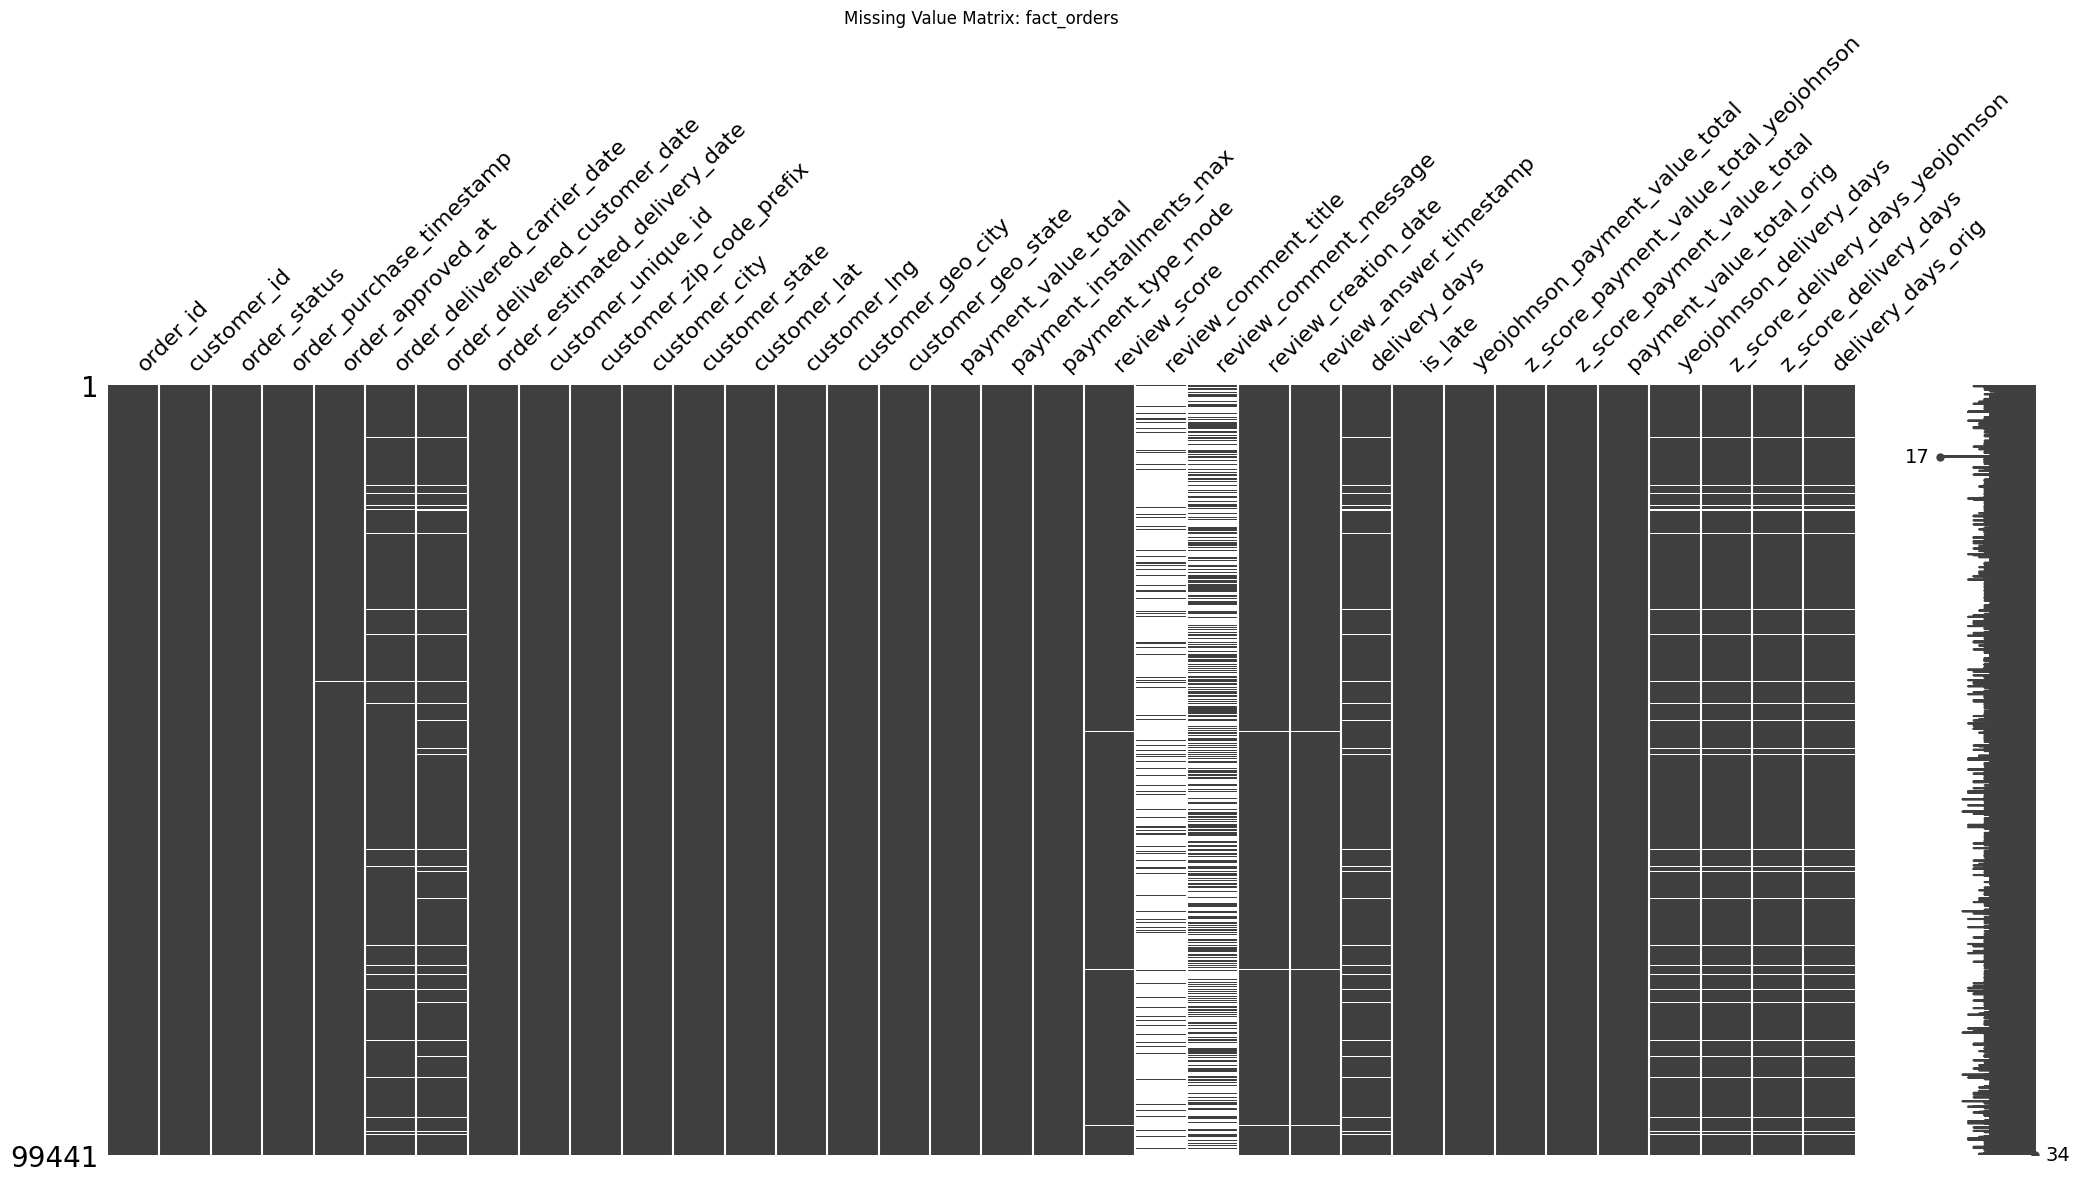


Missing value matrix for 'fact_order_items' dataframe:


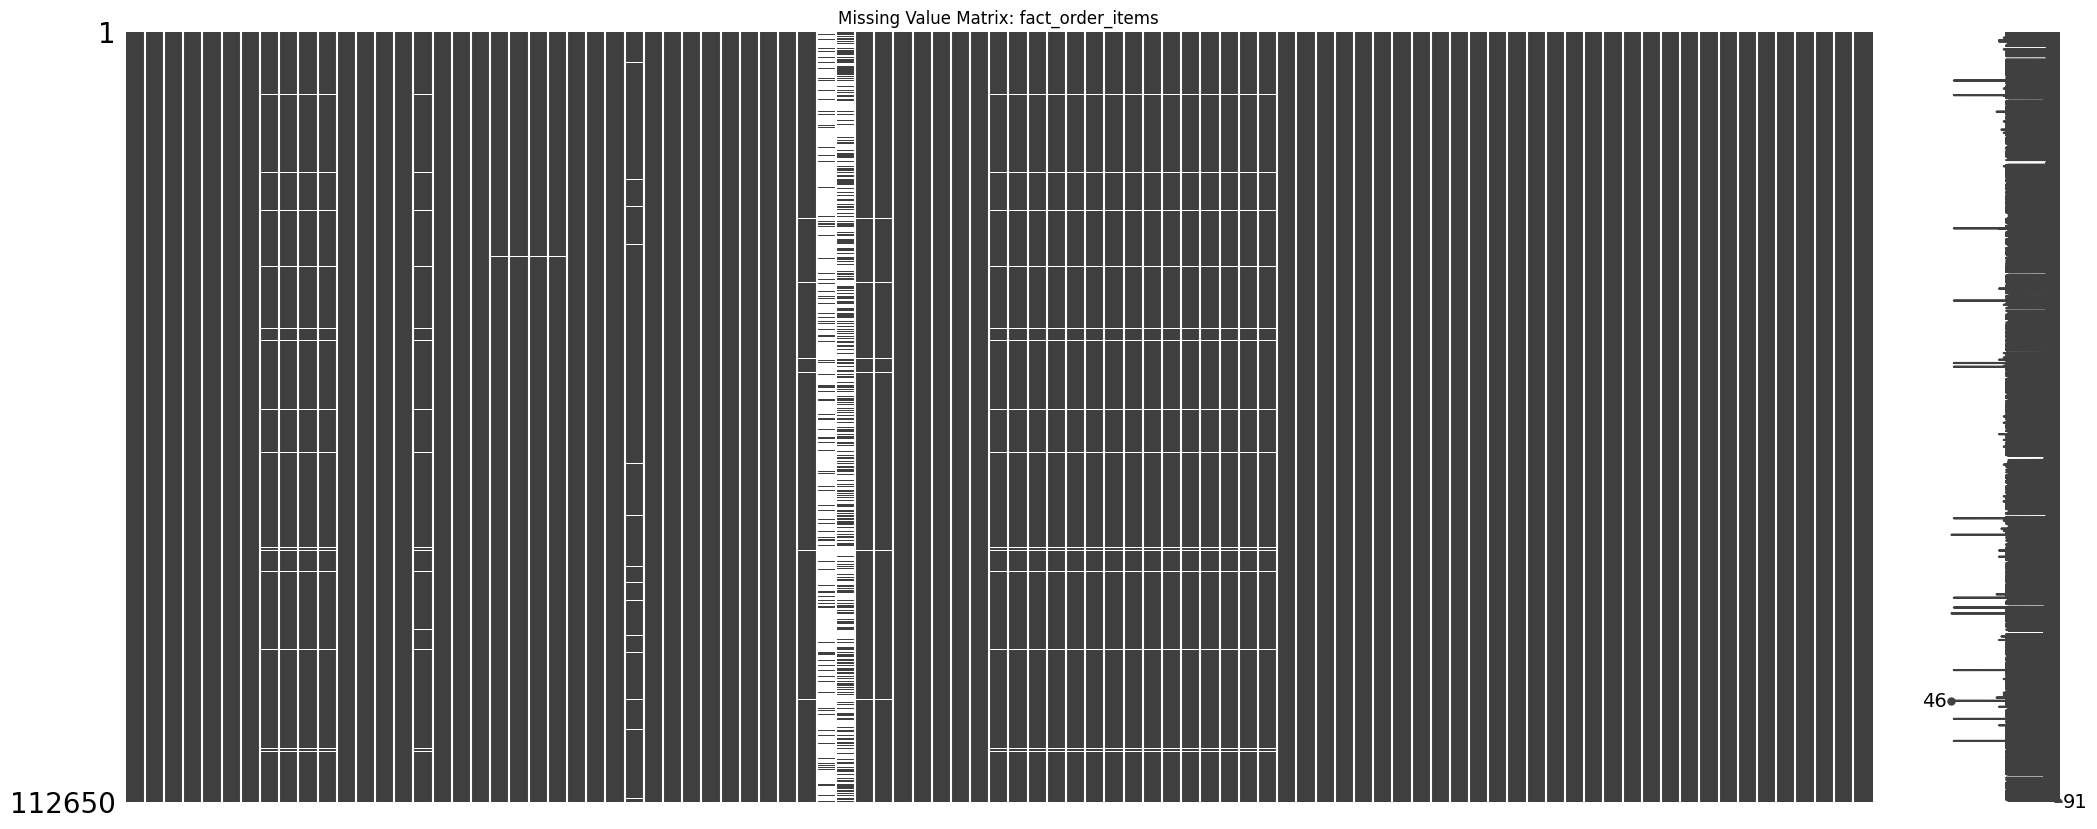

In [ ]:
try:

    fact_tables = {
        "fact_orders": fact_orders,
        "fact_order_items": fact_order_items
    }

    for df_name, df in fact_tables.items():
        print(f"\nMissing value matrix for '{df_name}' dataframe:")
        msno.matrix(df)
        plt.title(f"Missing Value Matrix: {df_name}")
        plt.show()

except ImportError:
    print("The 'missingno' library is not installed. Please install it using: pip install missingno")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()
except Exception as e:
    print(f"An error occurred while generating the missing value matrix: {e}")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()

Podemos ver que las columnas de titulo de la review y la review en si tienen muchos valores nulos, y como no vamos a hacer analisis de texto, decidimos eliminarlas.

In [ ]:
columns_to_drop = ['review_comment_title', 'review_comment_message']

fact_orders = fact_orders.drop(columns=columns_to_drop)
fact_order_items = fact_order_items.drop(columns=columns_to_drop)

print("Columns dropped successfully.")
print("Shape of fact_orders after dropping columns:", fact_orders.shape)
print("Shape of fact_order_items after dropping columns:", fact_order_items.shape)

Columns dropped successfully.
Shape of fact_orders after dropping columns: (99441, 32)
Shape of fact_order_items after dropping columns: (112650, 89)


In [ ]:
def littles_mcar_test(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = ['order_id', 'customer_id', 'review_comment_title', 'review_comment_message',
                    'order_item_id', 'product_id', 'seller_id', 'customer_unique_id',
                    'customer_zip_code_prefix', 'seller_zip_code_prefix']

    use_cols = [col for col in numerical_cols if col not in exclude_cols]

    if not use_cols:
        print("No suitable numerical columns found for MCAR test.")
        return np.nan, 0, np.nan


    X = df[use_cols].copy().replace({pd.NA: np.nan})

    missing_mask = X.isna()

    imp_mean = SimpleImputer(strategy="mean")
    X_imp = pd.DataFrame(imp_mean.fit_transform(X), columns=use_cols, index=X.index)

    patterns = missing_mask.drop_duplicates()
    chi_square = 0.0
    dof = 0

    for _, pattern in patterns.iterrows():
        rows = missing_mask.eq(pattern, axis=1).all(axis=1)
        subset = X.loc[rows]
        if subset.empty:
            continue

        means = X_imp.loc[rows, use_cols].mean()
        diffs = subset[use_cols].fillna(0) - means

        chi_square += (diffs**2).to_numpy().sum()
        dof += diffs.size

    p_value = 1 - chi2.cdf(chi_square, dof) if dof > 0 else np.nan
    return chi_square, dof, p_value

print("Performing Little's MCAR test on fact_orders:")
chi2_stat_orders, dof_orders, p_orders = littles_mcar_test(fact_orders)
print(f"Chi2: {chi2_stat_orders:.2f}")
print(f"Grados de libertad: {dof_orders}")
print(f"p-valor: {p_orders:.4f}")

if np.isnan(p_orders):
    print("Could not calculate p-value for fact_orders (dof=0).")
elif p_orders < 0.05:
    print("Reject H0 (Missingness is NOT MCAR) for fact_orders.")
else:
    print("Fail to reject H0 (Missingness is MCAR) for fact_orders.")

print("\n" + "="*50 + "\n")

print("Performing Little's MCAR test on fact_order_items:")
chi2_stat_items, dof_items, p_items = littles_mcar_test(fact_order_items)
print(f"Chi2: {chi2_stat_items:.2f}")
print(f"Grados de libertad: {dof_items}")
print(f"p-valor: {p_items:.4f}")

if np.isnan(p_items):
     print("Could not calculate p-value for fact_order_items (dof=0).")
elif p_items < 0.05:
    print("Reject H0 (Missingness is NOT MCAR) for fact_order_items.")
else:
    print("Fail to reject H0 (Missingness is MCAR) for fact_order_items.")

Performing Little's MCAR test on fact_orders:
Chi2: 9809803029.42
Grados de libertad: 1491615
p-valor: 0.0000
Reject H0 (Missingness is NOT MCAR) for fact_orders.


Performing Little's MCAR test on fact_order_items:
Chi2: 15759867354814.82
Grados de libertad: 7547550
p-valor: 0.0000
Reject H0 (Missingness is NOT MCAR) for fact_order_items.


In [ ]:
# se rechaza que sean MCAR, ahora vamos a ver si hay indicios de MAR
# para eso hacemos regresion

def logit_missing(df, target_col, original_numerical_cols):
    y = df[target_col].isna().astype(int)

    exclude_cols_predictors = [target_col, 'order_id', 'customer_id', 'order_item_id',
                               'product_id', 'seller_id', 'customer_unique_id',
                               'customer_zip_code_prefix', 'seller_zip_code_prefix',
                               'delivery_days', 'delivery_days_real',
                               'delivery_delay_orig']


    use_cols_predictors = [col for col in original_numerical_cols if col != target_col and col not in exclude_cols_predictors]

    if not use_cols_predictors:
        print(f"No suitable original numerical columns found to use as predictors for {target_col}.")
        return None

    X_num = df[use_cols_predictors].apply(pd.to_numeric, errors="coerce").astype(float)

    X = sm.add_constant(X_num, has_constant="add")

    mask = X.notna().all(axis=1) & y.notna()
    X2, y2 = X.loc[mask], y.loc[mask]

    if X2.empty or len(X2.columns) < 2:
         print(f"Not enough valid data or predictors to build a model for {target_col}.")
         return None


    # Logit model fitting
    try:
        X2 = X2.dropna(axis=1)
        if X2.empty:
            print(f"No valid predictor columns remaining after dropping NaNs for {target_col}.")
            return None
        y2 = y.loc[X2.index].astype(int)
        modelo = sm.Logit(y2, X2).fit(disp=0)
        print(f"\n=== Logit missing({target_col}) ===")
        print(modelo.summary())
        return modelo
    except Exception as e:
        print(f"Could not build Logit model for {target_col}: {e}")
        return None


current_numerical_cols_orders = fact_orders.select_dtypes(include=np.number).columns.tolist()
original_numerical_cols_orders = [col for col in current_numerical_cols_orders if not any(keyword in col for keyword in ['boxcox', 'yeojohnson', 'z_score', 'cleaned', '_orig', 'delivery_days', 'delivery_delay', 'delivery_days_real', 'delivery_delay_orig'])]

current_numerical_cols_items = fact_order_items.select_dtypes(include=np.number).columns.tolist()
original_numerical_cols_items = [col for col in current_numerical_cols_items if not any(keyword in col for keyword in ['boxcox', 'yeojohnson', 'z_score', 'cleaned', '_orig', 'delivery_days', 'delivery_delay', 'delivery_days_real', 'delivery_delay_orig'])]

missing_cols_orders_numerical_original = [col for col in fact_orders.columns[fact_orders.isna().any()].tolist() if col in original_numerical_cols_orders]
missing_cols_items_numerical_original = [col for col in fact_order_items.columns[fact_order_items.isna().any()].tolist() if col in original_numerical_cols_items]


print("Analyzing missingness in fact_orders using only original non-date numerical predictors:")
logit_models_orders = {}
for col in missing_cols_orders_numerical_original:
    model = logit_missing(fact_orders, col, original_numerical_cols_orders)
    if model:
        logit_models_orders[col] = model

print("\n" + "="*50 + "\n")

print("Analyzing missingness in fact_order_items using only original non-date numerical predictors:")
logit_models_items = {}
for col in missing_cols_items_numerical_original:
    model = logit_missing(fact_order_items, col, original_numerical_cols_items)
    if model:
        logit_models_items[col] = model

Analyzing missingness in fact_orders using only original non-date numerical predictors:


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Could not build Logit model for customer_lat: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(customer_lng) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:           customer_lng   No. Observations:                98396
Model:                          Logit   Df Residuals:                    98390
Method:                           MLE   Df Model:                            5
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:08   Log-Likelihood:            -3.3322e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -22.8700   3.93e+04     -0.001      1.000    -7.7e+04    7.69e+04
customer_lat                 0.0365   1035.344   3.53e-05      1.000   -2029.200    2029.

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(payment_value_total) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                            Logit Regression Results                           
Dep. Variable:     payment_value_total   No. Observations:                98396
Model:                           Logit   Df Residuals:                    98390
Method:                            MLE   Df Model:                            5
Date:                 Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                         20:29:10   Log-Likelihood:            -1.4645e-10
converged:                       False   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -12.3563   1.59e+06  -7.79e-06      1.000   -3.11e+06    3.11e+06
customer_lat                -0.3509   3.69e+04  -9.52e-06      1.000   -7.22e+04 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Logit missing(payment_installments_max) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                              Logit Regression Results                              
Dep. Variable:     payment_installments_max   No. Observations:                98396
Model:                                Logit   Df Residuals:                    98390
Method:                                 MLE   Df Model:                            5
Date:                      Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                              20:29:11   Log-Likelihood:            -3.5332e-05
converged:                            False   LL-Null:                        0.0000
Covariance Type:                  nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -11.9107   4.08e+05  -2.92e-05      1.000      -8e+05       8e+05
customer_lat           -0.6604    2.3e+04  -2.87e-05    

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

Could not build Logit model for product_name_lenght: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(product_description_lenght) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                               Logit Regression Results                               
Dep. Variable:     product_description_lenght   No. Observations:               109570
Model:                                  Logit   Df Residuals:                   109554
Method:                                   MLE   Df Model:                           15
Date:                        Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                                20:29:18   Log-Likelihood:            -7.8772e-10
converged:                              False   LL-Null:                        0.0000
Covariance Type:                    nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -17.0318   1.72e+06  -9.88e-06      1.000   -3.38e+06    3.38e+06
price                    

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

Could not build Logit model for product_photos_qty: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(product_weight_g) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:       product_weight_g   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:20   Log-Likelihood:            -0.00043206
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -17.0787   1.93e+04     -0.001      0.999   -3.78e+04    3.78e+04
price                          0.0058      8.800      0.001      0.999     -17.242 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(product_length_cm) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:      product_length_cm   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:22   Log-Likelihood:            -9.8434e-10
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -17.0958   6.74e+05  -2.54e-05      1.000   -1.32e+06    1.32e+06
price                         -0.0003     68.596  -4.09e-06      1.000    -134.446 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(product_height_cm) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:      product_height_cm   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:24   Log-Likelihood:             -0.0024240
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.8558    410.306     -0.007      0.994    -807.041     801.329
price                          0.0006      0.214      0.003      0.998      -0.419 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(product_width_cm) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:       product_width_cm   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:26   Log-Likelihood:            -5.8926e-09
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -17.0789   3.43e+05  -4.98e-05      1.000   -6.73e+05    6.73e+05
price                          0.0005     82.418   5.68e-06      1.000    -161.537 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

Could not build Logit model for seller_lat: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(seller_lng) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:             seller_lng   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:31   Log-Likelihood:                -736.27
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -19.7831      6.556     -3.017      0.003     -32.634      -6.933
price                          0.0122      0.002      5.691      0.000       0.008 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

Could not build Logit model for customer_lat: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(customer_lng) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:           customer_lng   No. Observations:               109570
Model:                          Logit   Df Residuals:                   109554
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                        20:29:34   Log-Likelihood:             -0.0030479
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -15.1641    7.4e+04     -0.000      1.000   -1.45e+05    1.45e+05
price                         -0.0005      7.514  -6.68e-05      1.000     -14.727 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(payment_value_total) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                            Logit Regression Results                           
Dep. Variable:     payment_value_total   No. Observations:               109570
Model:                           Logit   Df Residuals:                   109554
Method:                            MLE   Df Model:                           15
Date:                 Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                         20:29:36   Log-Likelihood:            -1.6757e-08
converged:                       False   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -17.0895   4.55e+05  -3.75e-05      1.000   -8.92e+05    8.92e+05
price                          0.0014     21.337   6.64e-05      1.000     

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(payment_installments_max) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                              Logit Regression Results                              
Dep. Variable:     payment_installments_max   No. Observations:               109570
Model:                                Logit   Df Residuals:                   109554
Method:                                 MLE   Df Model:                           15
Date:                      Sun, 12 Oct 2025   Pseudo R-squ.:                     inf
Time:                              20:29:38   Log-Likelihood:            -6.6270e-06
converged:                            False   LL-Null:                        0.0000
Covariance Type:                  nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -17.0722   1.23e+04     -0.001      0.999   -2.41e+04     2.4e+04
price                          0.00

In [ ]:
def interpret_mar_logit_results(model, col_name, alpha=0.05):
    if model is None:
        print("Model was not successfully fitted, cannot interpret results for", col_name)
        return

    print(f"\nInterpretation for missingness in '{col_name}':")

    significant_predictors = []
    for param, p_value in model.pvalues.items():
        if param != 'const' and p_value < alpha:
            significant_predictors.append(param)

    if significant_predictors:
        print(f"Evidence for MAR: Missingness in '{col_name}' is significantly related to the following predictors (p < {alpha}):")
        for predictor in significant_predictors:
            print(f"- {predictor} (p-value: {model.pvalues[predictor]:.4f})")
    else:
        print(f"No significant relationship found between missingness in '{col_name}' and the included numerical predictors (at alpha={alpha}).")
        print("This *could* be an indication of MNAR for this column, but it's not conclusive.")
        print("Missingness might be related to other variables not included or the missing value itself.")

print("Interpreting MAR analysis results for fact_orders:")
for col, model in logit_models_orders.items():
    interpret_mar_logit_results(model, col)
    print("-" * 50)

print("\nInterpreting MAR analysis results for fact_order_items:")
for col, model in logit_models_items.items():
    interpret_mar_logit_results(model, col)
    print("-" * 50)

Interpreting MAR analysis results for fact_orders:

Interpretation for missingness in 'customer_lng':
No significant relationship found between missingness in 'customer_lng' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'payment_value_total':
No significant relationship found between missingness in 'payment_value_total' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'payment_installments_max':
No significant relationship found between missingness in 'payment_installm

Hicimos la regresión logística sobre las variables numéricas. En la mayoría de los casos,no rechazamos H0 (todos los p valores eran grandes), por lo que no podíamos afirmar que los datos fueran MAR.

Entonces, consideramos que al tratarse de una cantidad menor al 3% de faltantes por columna, aplicamos KNN en todos los casos porque no consideramos que el test fuera tan concluyente ya que la cantidad de datos faltantes era poca.

En conclusión, aplicamos KNN en todos los casos, en las columnas no numéricas de texto imputamos con la moda y en las de fecha y hora rellenamos con NaT, que es un dato nulo pero de tiempo.

In [ ]:

numerical_cols_with_missing_orders = fact_orders.select_dtypes(include=np.number).columns[fact_orders.select_dtypes(include=np.number).isna().any()].tolist()
exclude_cols_impute_orders = ['customer_zip_code_prefix']

numerical_cols_to_impute_knn_orders = [col for col in numerical_cols_with_missing_orders if col not in exclude_cols_impute_orders]


numerical_cols_with_missing_items = fact_order_items.select_dtypes(include=np.number).columns[fact_order_items.select_dtypes(include=np.number).isna().any()].tolist()
exclude_cols_impute_items = ['order_item_id', 'customer_zip_code_prefix', 'seller_zip_code_prefix']

numerical_cols_to_impute_knn_items = [col for col in numerical_cols_with_missing_items if col not in exclude_cols_impute_items]


print("Applying KNN imputation to numerical columns in fact_orders:")
if numerical_cols_to_impute_knn_orders:
    imputer_orders = KNNImputer(n_neighbors=5)
    fact_orders[numerical_cols_to_impute_knn_orders] = imputer_orders.fit_transform(fact_orders[numerical_cols_to_impute_knn_orders])
    print("KNN imputation applied to:", numerical_cols_to_impute_knn_orders)
else:
    print("No suitable numerical columns found in fact_orders for KNN imputation.")


print("\nApplying KNN imputation to numerical columns in fact_order_items:")
if numerical_cols_to_impute_knn_items:
    imputer_items = KNNImputer(n_neighbors=5)
    fact_order_items[numerical_cols_to_impute_knn_items] = imputer_items.fit_transform(fact_order_items[numerical_cols_to_impute_knn_items])
    print("KNN imputation applied to:", numerical_cols_to_impute_knn_items)
else:
    print("No suitable numerical columns found in fact_order_items for KNN imputation.")

Applying KNN imputation to numerical columns in fact_orders:
KNN imputation applied to: ['customer_lat', 'customer_lng', 'payment_value_total', 'payment_installments_max', 'review_score', 'delivery_days', 'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total', 'payment_value_total_orig', 'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'z_score_delivery_days', 'delivery_days_orig']

Applying KNN imputation to numerical columns in fact_order_items:
KNN imputation applied to: ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng', 'payment_value_total', 'payment_installments_max', 'review_score', 'boxcox_product_name_lenght', 'z_score_product_name_lenght_boxcox', 'z_score_product_name_lenght', 'boxcox_imputed_product_name_lenght', 'cleaned_product_name_lenght', 'b

In [ ]:
categorical_cols_to_impute_mode_orders = ['customer_geo_city', 'customer_geo_state', 'payment_type_mode']
categorical_cols_to_impute_mode_items = ['product_category_name_english', 'product_category_name', 'seller_geo_city', 'seller_geo_state', 'payment_type_mode']

print("Applying mode imputation to categorical columns in fact_orders:")
for col in categorical_cols_to_impute_mode_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        mode_value = fact_orders[col].mode()[0]
        fact_orders[col] = fact_orders[col].fillna(mode_value)
        print(f"Mode imputation applied to '{col}' in fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Column '{col}' not found in fact_orders. Skipping mode imputation.")
    else:
         print(f"Column '{col}' in fact_orders has no missing values. Skipping mode imputation.")


print("\nApplying mode imputation to categorical columns in fact_order_items:")
for col in categorical_cols_to_impute_mode_items:
    if col in fact_order_items.columns and fact_order_items[col].isna().any():
        mode_value = fact_order_items[col].mode()[0]
        fact_order_items[col] = fact_order_items[col].fillna(mode_value)
        print(f"Mode imputation applied to '{col}' in fact_order_items.")
    elif col not in fact_order_items.columns:
         print(f"Column '{col}' not found in fact_order_items. Skipping mode imputation.")
    else:
         print(f"Column '{col}' in fact_order_items has no missing values. Skipping mode imputation.")

Applying mode imputation to categorical columns in fact_orders:
Mode imputation applied to 'customer_geo_city' in fact_orders.
Mode imputation applied to 'customer_geo_state' in fact_orders.
Mode imputation applied to 'payment_type_mode' in fact_orders.

Applying mode imputation to categorical columns in fact_order_items:
Mode imputation applied to 'product_category_name_english' in fact_order_items.
Mode imputation applied to 'product_category_name' in fact_order_items.
Mode imputation applied to 'seller_geo_city' in fact_order_items.
Mode imputation applied to 'seller_geo_state' in fact_order_items.
Mode imputation applied to 'payment_type_mode' in fact_order_items.


In [ ]:
date_cols_to_impute_orders = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'review_creation_date', 'review_answer_timestamp']
date_cols_to_impute_items = ['order_delivered_customer_date', 'review_creation_date', 'review_answer_timestamp']

print("Applying NaT imputation to date/time columns in fact_orders:")
for col in date_cols_to_impute_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        fact_orders[col] = pd.to_datetime(fact_orders[col], errors='coerce')
        fact_orders[col] = fact_orders[col].fillna(pd.NaT)
        print(f"NaT imputation applied to '{col}' in fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Column '{col}' not found in fact_orders. Skipping NaT imputation.")
    else:
        print(f"Column '{col}' in fact_orders has no missing values. Skipping NaT imputation.")


print("\nApplying NaT imputation to date/time columns in fact_order_items:")
for col in date_cols_to_impute_items:
     if col in fact_order_items.columns and fact_order_items[col].isna().any():
        fact_order_items[col] = pd.to_datetime(fact_order_items[col], errors='coerce')
        fact_order_items[col] = fact_order_items[col].fillna(pd.NaT)
        print(f"NaT imputation applied to '{col}' in fact_order_items.")
     elif col not in fact_order_items.columns:
        print(f"Column '{col}' not found in fact_order_items. Skipping NaT imputation.")
     else:
        print(f"Column '{col}' in fact_order_items has no missing values. Skipping NaT imputation.")

Applying NaT imputation to date/time columns in fact_orders:
NaT imputation applied to 'order_delivered_customer_date' in fact_orders.
NaT imputation applied to 'order_delivered_carrier_date' in fact_orders.
NaT imputation applied to 'order_approved_at' in fact_orders.
NaT imputation applied to 'review_creation_date' in fact_orders.
NaT imputation applied to 'review_answer_timestamp' in fact_orders.

Applying NaT imputation to date/time columns in fact_order_items:
NaT imputation applied to 'order_delivered_customer_date' in fact_order_items.
NaT imputation applied to 'review_creation_date' in fact_order_items.
NaT imputation applied to 'review_answer_timestamp' in fact_order_items.


In [ ]:
fact_tables = {
    "fact_orders": fact_orders,
    "fact_order_items": fact_order_items
}

print("Checking for any remaining missing values in fact tables after imputation:")

all_missing_handled = True
for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]

    if not falt.empty:
        all_missing_handled = False
        falt_pct = (falt / n) * 100
        faltantes_df = (
            pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
            .sort_values("Porcentaje", ascending=False)
        )
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nRemaining missing values found in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo remaining missing values found in '{df_name}' dataframe.")

if all_missing_handled:
    print("\nAll intended missing values appear to have been handled.")
else:
    print("\nThere are still some missing values that may need further attention.")

Checking for any remaining missing values in fact tables after imputation:

Remaining missing values found in 'fact_orders' dataframe:


Cantidad_faltantes Porcentaje
order_delivered_customer_date                2965      2.98%
order_delivered_carrier_date                 1783      1.79%
review_creation_date                          768      0.77%
review_answer_timestamp                       768      0.77%
order_approved_at                             160      0.16%


Remaining missing values found in 'fact_order_items' dataframe:


Cantidad_faltantes Porcentaje
order_delivered_customer_date                2454      2.18%
review_creation_date                          942      0.84%
review_answer_timestamp                       942      0.84%


There are still some missing values that may need further attention.


##Análisis exploratorio inicial con visualizaciones.

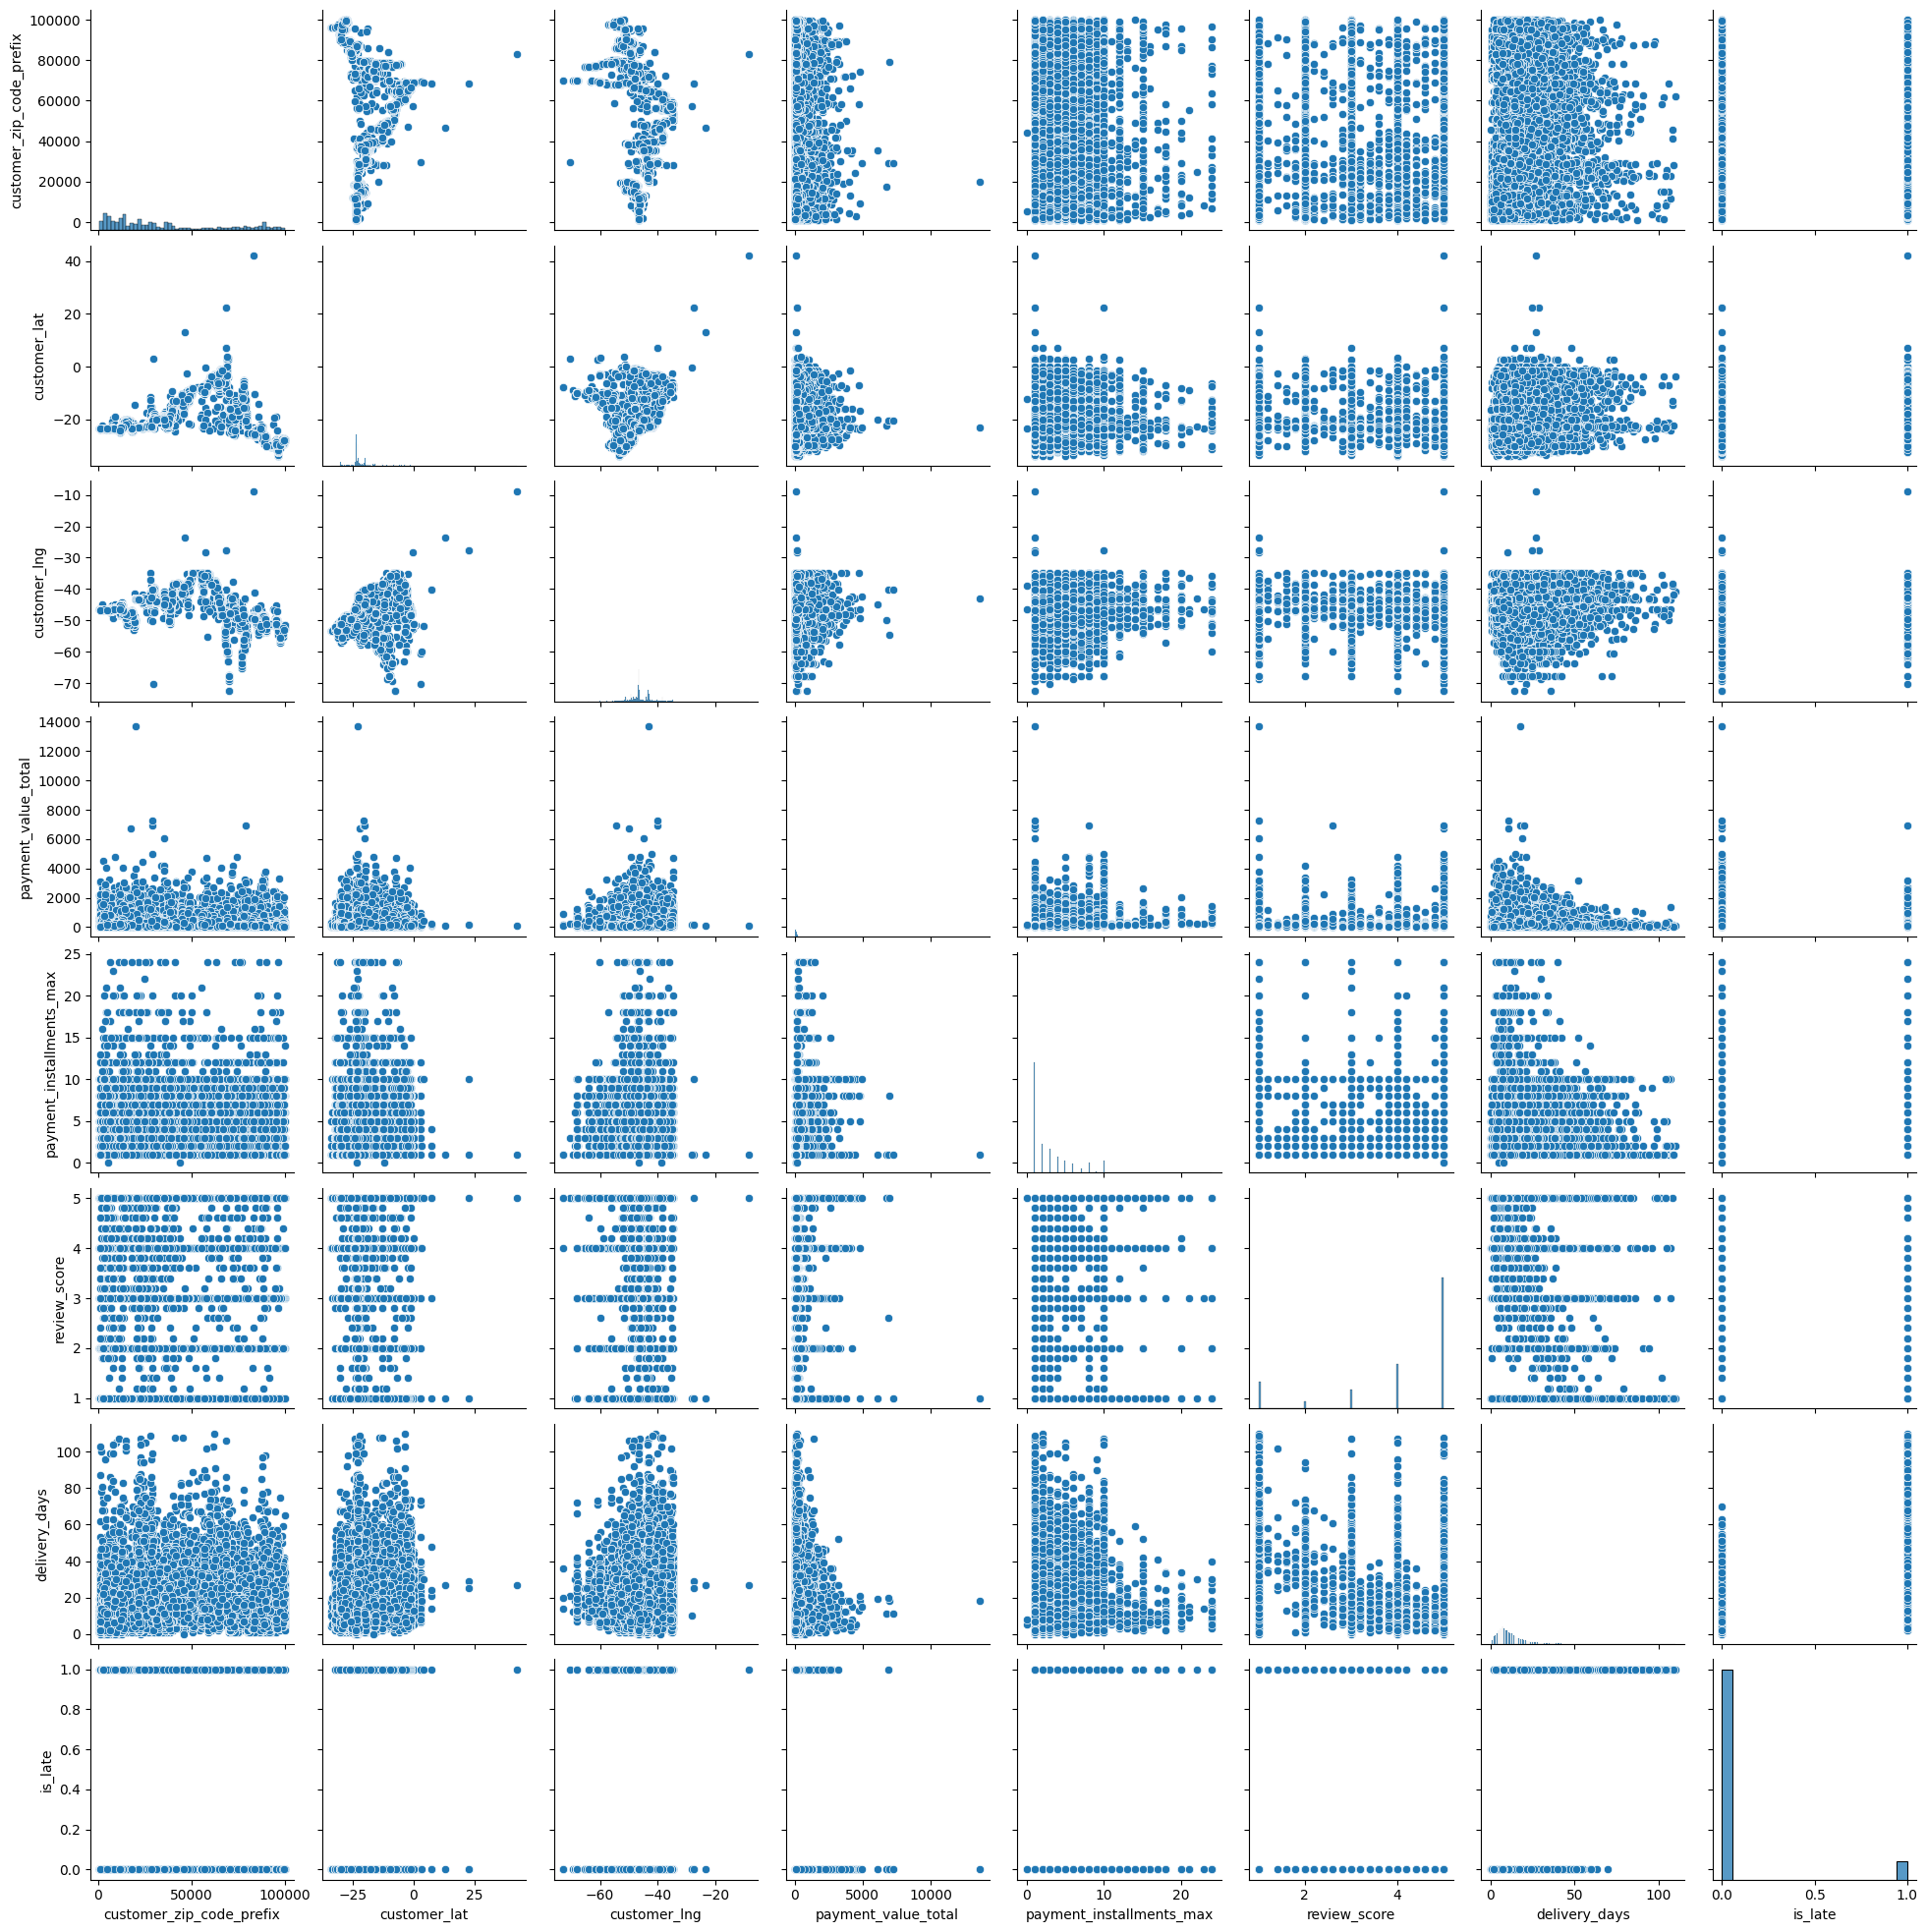

In [ ]:
sns.pairplot(fact_orders[cols_numericas_fact_orders])

In [ ]:
sns.pairplot(fact_order_items[cols_numericas_fact_order_items])

Output hidden; open in https://colab.research.google.com to view.

customer_zip_code_prefix  \
customer_zip_code_prefix                                1.000000   
customer_lat                                            0.125489   
customer_lng                                           -0.304206   
payment_value_total                                     0.057796   
payment_installments_max                                0.055179   
review_score                                           -0.015824   
delivery_days                                           0.283643   
is_late                                                 0.024429   
yeojohnson_payment_value_total                          0.102579   
z_score_payment_value_total_yeojohnson                  0.102579   
z_score_payment_value_total                             0.057796   
payment_value_total_orig                                0.057796   
yeojohnson_delivery_days                                0.359241   
z_score_delivery_days_yeojohnson                        0.359241   
z_score_delivery_days                                   0.282902   
delivery_days_orig                                      0.282902   

                                        customer_lat  customer_lng  \
customer_zip_code_prefix                    0.125489     -0.304206   
customer_lat                                1.000000      0.450092   
customer_lng                                0.450092      1.000000   
payment_value_total                         0.069126      0.019481   
payment_installments_max                    0.063711      0.040253   
review_score                               -0.041961     -0.052200   
delivery_days                               0.265719      0.120455   
is_late                                     0.055467      0.072232   
yeojohnson_payment_value_total              0.105867      0.040335   
z_score_payment_value_total_yeojohnson      0.105867      0.040335   
z_score_payment_value_total                 0.069126      0.019481   
payment_value_total_orig                    0.069126      0.019481   
yeojohnson_delivery_days                    0.277871      0.109635   
z_score_delivery_days_yeojohnson            0.277871      0.109635   
z_score_delivery_days                       0.265125      0.120337   
delivery_days_orig                          0.265125      0.120337   

                                        payment_value_total  \
customer_zip_code_prefix                           0.057796   
customer_lat                                       0.069126   
customer_lng                                       0.019481   
payment_value_total                                1.000000   
payment_installments_max                           0.319077   
review_score                                      -0.048888   
delivery_days                                      0.071802   
is_late                                            0.015454   
yeojohnson_payment_value_total                     0.685188   
z_score_payment_value_total_yeojohnson             0.685188   
z_score_payment_value_total                        1.000000   
payment_value_total_orig                           1.000000   
yeojohnson_delivery_days                           0.079951   
z_score_delivery_days_yeojohnson                   0.079951   
z_score_delivery_days                              0.071604   
delivery_days_orig                                 0.071604   

                                        payment_installments_max  \
customer_zip_code_prefix                                0.055179   
customer_lat                                            0.063711   
customer_lng                                            0.040253   
payment_value_total                                     0.319077   
payment_installments_max                                1.000000   
review_score                                           -0.031000   
delivery_days                                           0.052479   
is_late                                                 0.008553   
yeojohns

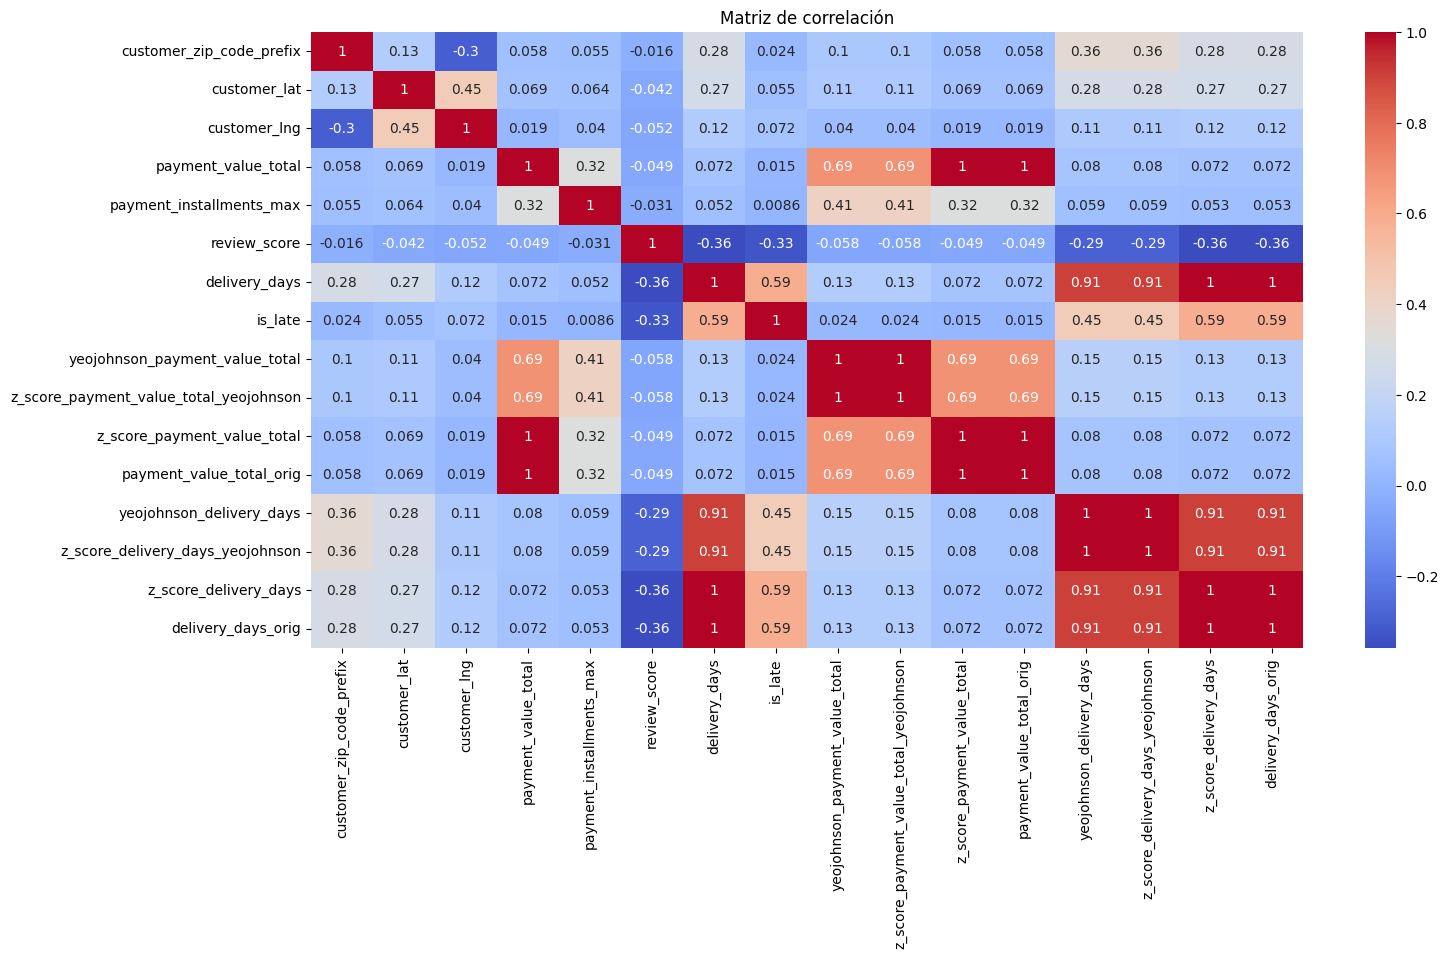

In [ ]:
# calcular correlaciones
corr = fact_orders.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

In [ ]:
# calcular correlaciones
corr = fact_order_items.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Consideramos que las variables están altamente correlaciones si la correlación es 0.8 o 80%. No se ven variables altamente correlacionadas, entonces no eliminamos.

###Gráficos básicos que permitan contrastar hipótesis de la entrega 1. Conclusiones preliminares.

**Hipótesis 1**: Los clientes pueden agruparse en clusters diferenciados en función de variables como ticket promedio, frecuencia de compra, categorías preferidas y métodos de pago.

**Conclusiones**: Podemos ver que ticket promedio y frecuencia no muestran que haya evidencia para decir que hay clusters separados. La mayoría de los consumidores tiene una frecuencia de compra muy baja (muchas veces por única vez) y la distribución del ticket promedio es asimétrica.

Podemos ver que categoría preferida y método de pago no muestran que haya evidencia para decir que hay clusters separados.

En conclusión, a simple vista no se ve una separación de grupos de clientes que permita realizar clustering, será analizado en profunidad más adelante.

In [ ]:
order_total_payment = fact_orders.groupby('order_id')['payment_value_total'].sum().reset_index()
order_total_payment.rename(columns={'payment_value_total': 'order_total_value'}, inplace=True)

fact_orders_with_value = pd.merge(fact_orders, order_total_payment, on='order_id', how='left')

customer_avg_ticket = fact_orders_with_value.groupby('customer_unique_id')['order_total_value'].mean().reset_index()
customer_avg_ticket.rename(columns={'order_total_value': 'avg_ticket_price'}, inplace=True)

customer_purchase_frequency = fact_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_purchase_frequency.rename(columns={'order_id': 'purchase_frequency'}, inplace=True)

items_with_customers = pd.merge(fact_order_items, fact_orders[['order_id', 'customer_unique_id']], on='order_id', how='left')

customer_category_counts = items_with_customers.groupby(['customer_unique_id', 'product_category_name_english']).size().reset_index(name='count')

customer_preferred_category = customer_category_counts.loc[customer_category_counts.groupby('customer_unique_id')['count'].idxmax()].reset_index(drop=True)
customer_preferred_category.rename(columns={'product_category_name_english': 'preferred_product_category'}, inplace=True)


customer_payment_counts = fact_orders.groupby(['customer_unique_id', 'payment_type_mode']).size().reset_index(name='count')

customer_preferred_payment = customer_payment_counts.loc[customer_payment_counts.groupby('customer_unique_id')['count'].idxmax()].reset_index(drop=True)
customer_preferred_payment.rename(columns={'payment_type_mode': 'preferred_payment_type'}, inplace=True)

customer_metrics = pd.merge(customer_avg_ticket, customer_purchase_frequency, on='customer_unique_id', how='left')
customer_metrics = pd.merge(customer_metrics, customer_preferred_category[['customer_unique_id', 'preferred_product_category']], on='customer_unique_id', how='left')
customer_metrics = pd.merge(customer_metrics, customer_preferred_payment[['customer_unique_id', 'preferred_payment_type']], on='customer_unique_id', how='left')


print("Customer-level metrics calculated:")
display(customer_metrics.head())

Customer-level metrics calculated:


customer_unique_id  avg_ticket_price  purchase_frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2            141.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f             27.19                   1   
2  0000f46a3911fa3c0805444483337064             86.22                   1   
3  0000f6ccb0745a6a4b88665a16c9f078             43.62                   1   
4  0004aac84e0df4da2b147fca70cf8255            196.89                   1   

  preferred_product_category preferred_payment_type  
0             bed_bath_table            credit_card  
1              health_beauty            credit_card  
2                 stationery            credit_card  
3                  telephony            credit_card  
4                  telephony            credit_card

Visualizing the distribution of Average Ticket Price:


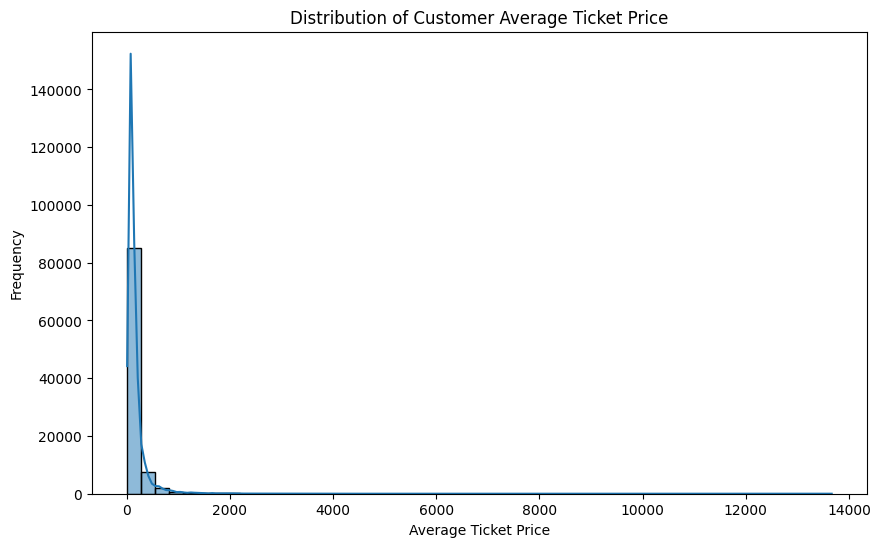


Visualizing the distribution of Purchase Frequency:


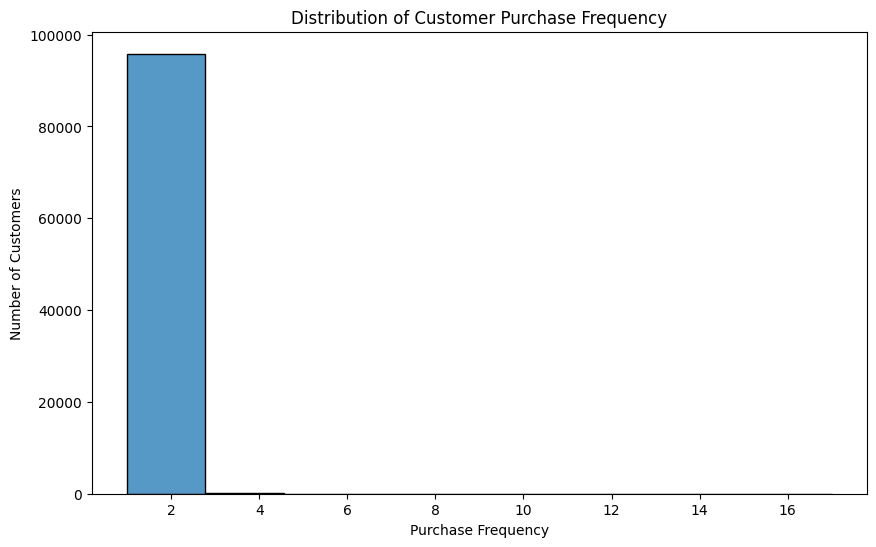

In [ ]:
print("Visualizing the distribution of Average Ticket Price:")
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['avg_ticket_price'], bins=50, kde=True)
plt.title('Distribution of Customer Average Ticket Price')
plt.xlabel('Average Ticket Price')
plt.ylabel('Frequency')
plt.show()

print("\nVisualizing the distribution of Purchase Frequency:")
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['purchase_frequency'], bins=customer_metrics['purchase_frequency'].nunique(), kde=False) # Use unique values as bins for frequency
plt.title('Distribution of Customer Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Number of Customers')
plt.show()

Visualizing the distribution of Preferred Product Category:


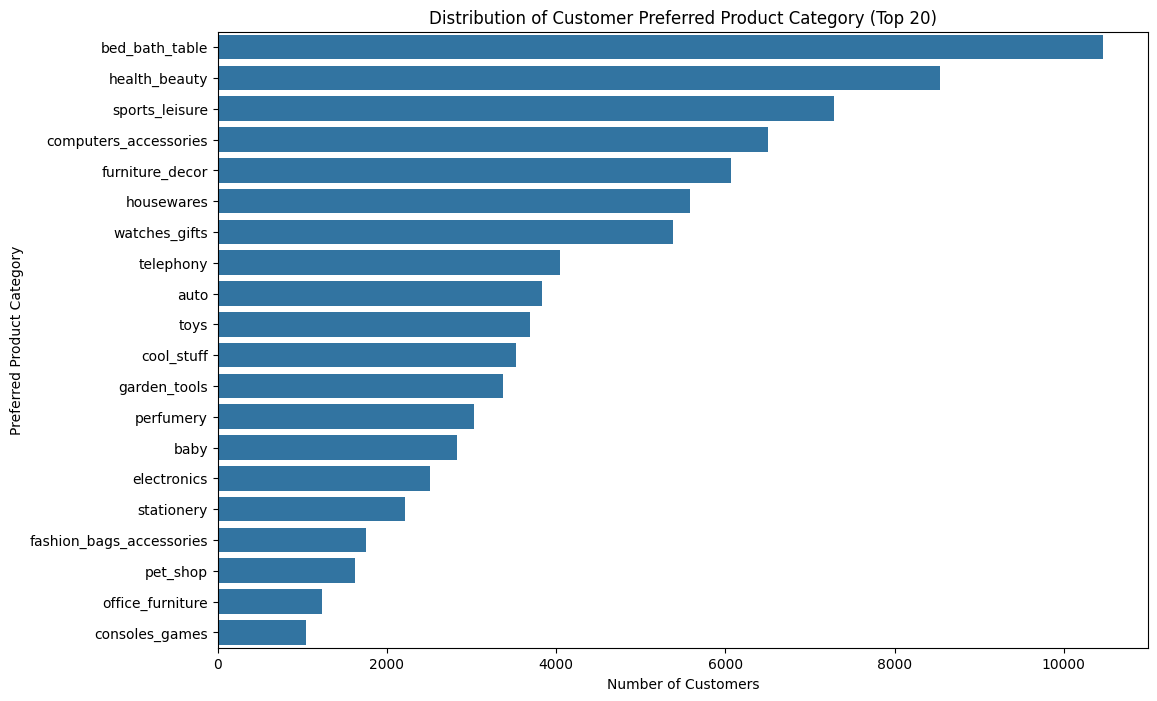


Visualizing the distribution of Preferred Payment Type:


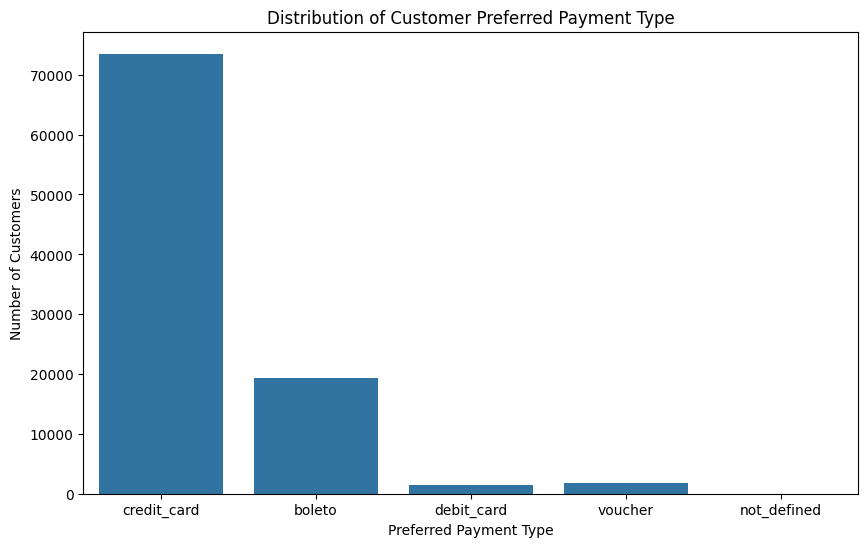

In [ ]:
print("Visualizing the distribution of Preferred Product Category:")
plt.figure(figsize=(12, 8))

top_n_categories = customer_metrics['preferred_product_category'].value_counts().nlargest(20).index
sns.countplot(data=customer_metrics[customer_metrics['preferred_product_category'].isin(top_n_categories)], y='preferred_product_category', order=top_n_categories)
plt.title('Distribution of Customer Preferred Product Category (Top 20)')
plt.xlabel('Number of Customers')
plt.ylabel('Preferred Product Category')
plt.show()


print("\nVisualizing the distribution of Preferred Payment Type:")
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_metrics, x='preferred_payment_type')
plt.title('Distribution of Customer Preferred Payment Type')
plt.xlabel('Preferred Payment Type')
plt.ylabel('Number of Customers')
plt.show()

Exploring relationship between Average Ticket Price and Purchase Frequency:


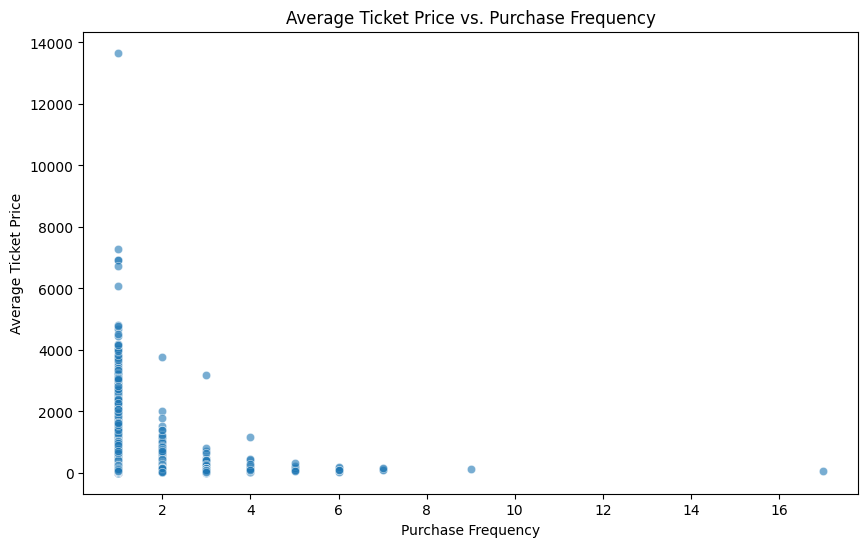


Exploring relationship between Preferred Payment Type and Average Ticket Price:


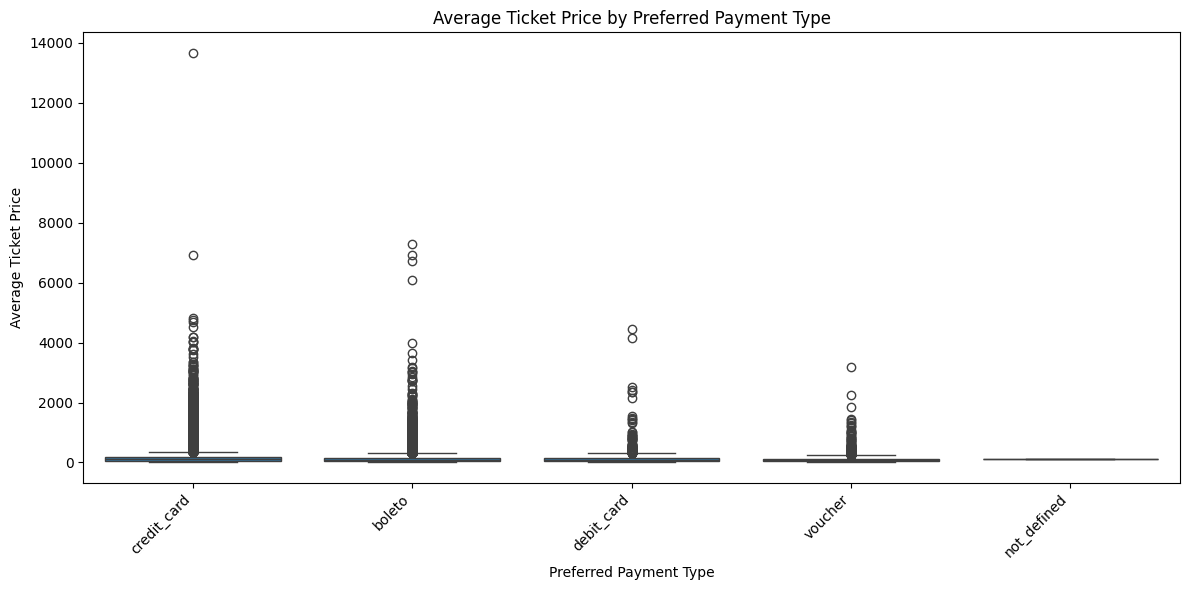


Exploring relationship between Preferred Product Category and Average Ticket Price (Top 10 Categories):


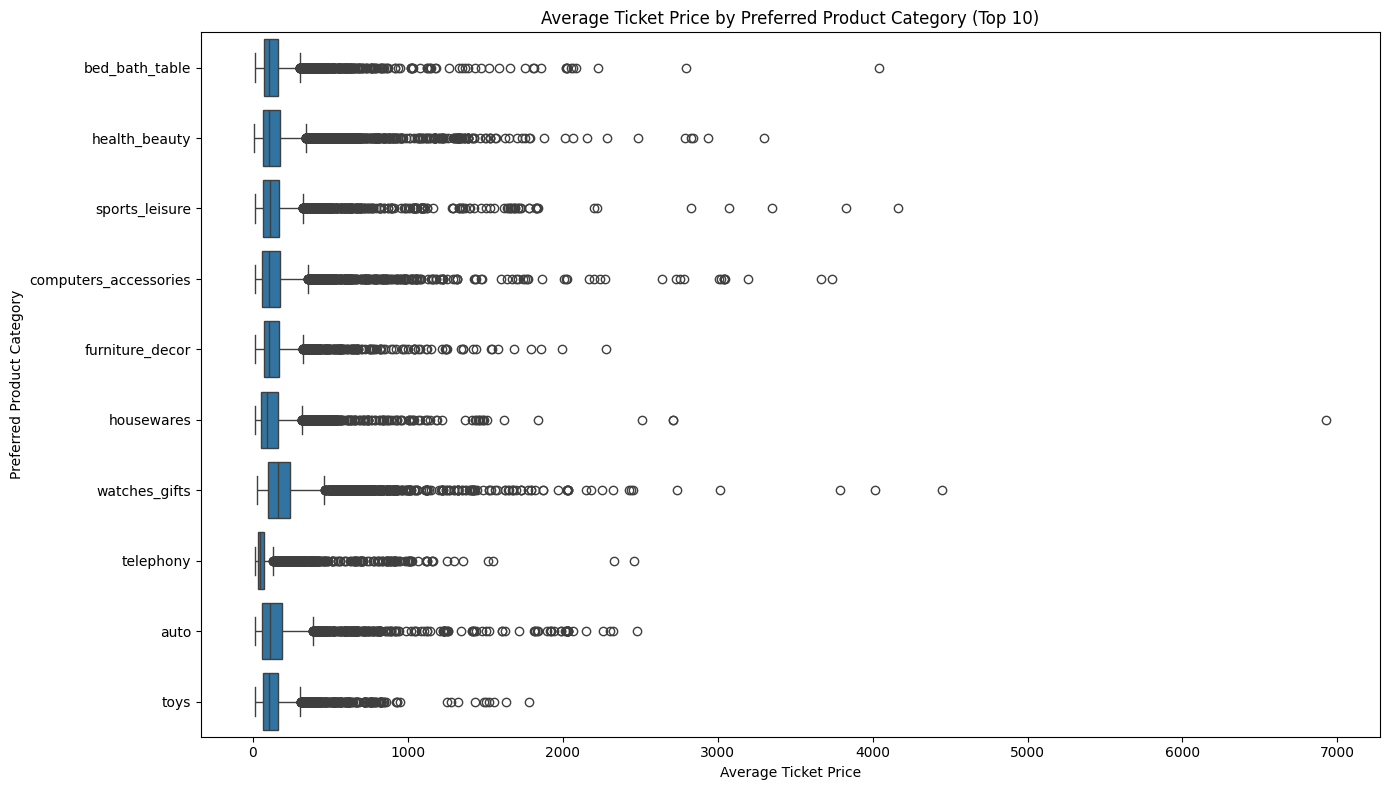

In [ ]:
print("Exploring relationship between Average Ticket Price and Purchase Frequency:")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_metrics, x='purchase_frequency', y='avg_ticket_price', alpha=0.6)
plt.title('Average Ticket Price vs. Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Ticket Price')
plt.show()

print("\nExploring relationship between Preferred Payment Type and Average Ticket Price:")
plt.figure(figsize=(12, 6))
sns.boxplot(data=customer_metrics, x='preferred_payment_type', y='avg_ticket_price')
plt.title('Average Ticket Price by Preferred Payment Type')
plt.xlabel('Preferred Payment Type')
plt.ylabel('Average Ticket Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nExploring relationship between Preferred Product Category and Average Ticket Price (Top 10 Categories):")
plt.figure(figsize=(14, 8))

top_10_categories = customer_metrics['preferred_product_category'].value_counts().nlargest(10).index
sns.boxplot(data=customer_metrics[customer_metrics['preferred_product_category'].isin(top_10_categories)],
            y='preferred_product_category', x='avg_ticket_price', order=top_10_categories)
plt.title('Average Ticket Price by Preferred Product Category (Top 10)')
plt.xlabel('Average Ticket Price')
plt.ylabel('Preferred Product Category')
plt.tight_layout()
plt.show()



**Hipótesis 2**: Los distintos clusters de clientes muestran comportamientos de compra y niveles de fidelidad diferentes, lo cual permite diseñar estrategias de marketing personalizadas (por ejemplo retención para clientes frecuentes, descuentos para clientes esporádicos).

**Conclusiones**: Podemos ver que hay diferencias notables entre el ticket promedio mediano de consumidores que compraron una única vez y consumidores recurrentes.

Podemos ver que los compradores recurrentes tienden a preferir ciertos tipos de pago más que los compradores únicos.

Podemos ver que los compradores recurrentes están más concentrados en ciertas categorías de productos en comparación con los compradores únicos.

En resumen, las métricas de comportamiento de compra (ticket promedio, categoría/método de pago preferido) difieren según un nivel de fidelidad simple (frecuencia de compra). Si bien estos gráficos no prueban definitivamente la hipótesis para todos los posibles clusters, demuestran que existen diferencias de comportamiento entre al menos dos grupos de clientes definidos por su frecuencia de compra.

Comparing Average Ticket Price by Loyalty Level:


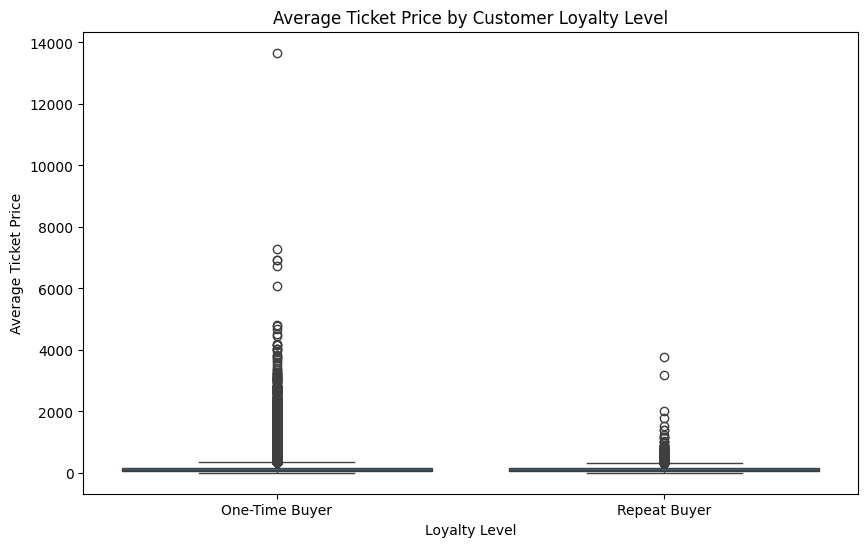


Comparing Preferred Payment Type by Loyalty Level:


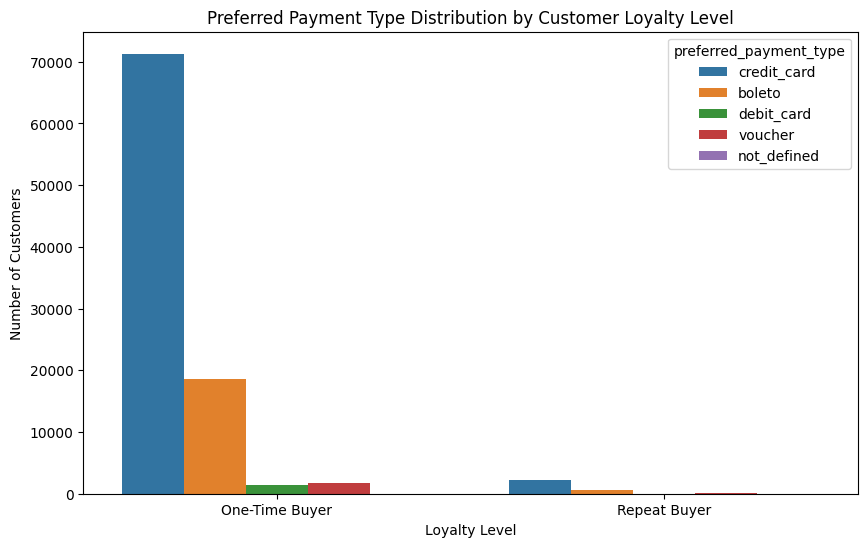


Comparing Preferred Product Category by Loyalty Level (Top 10 Categories):


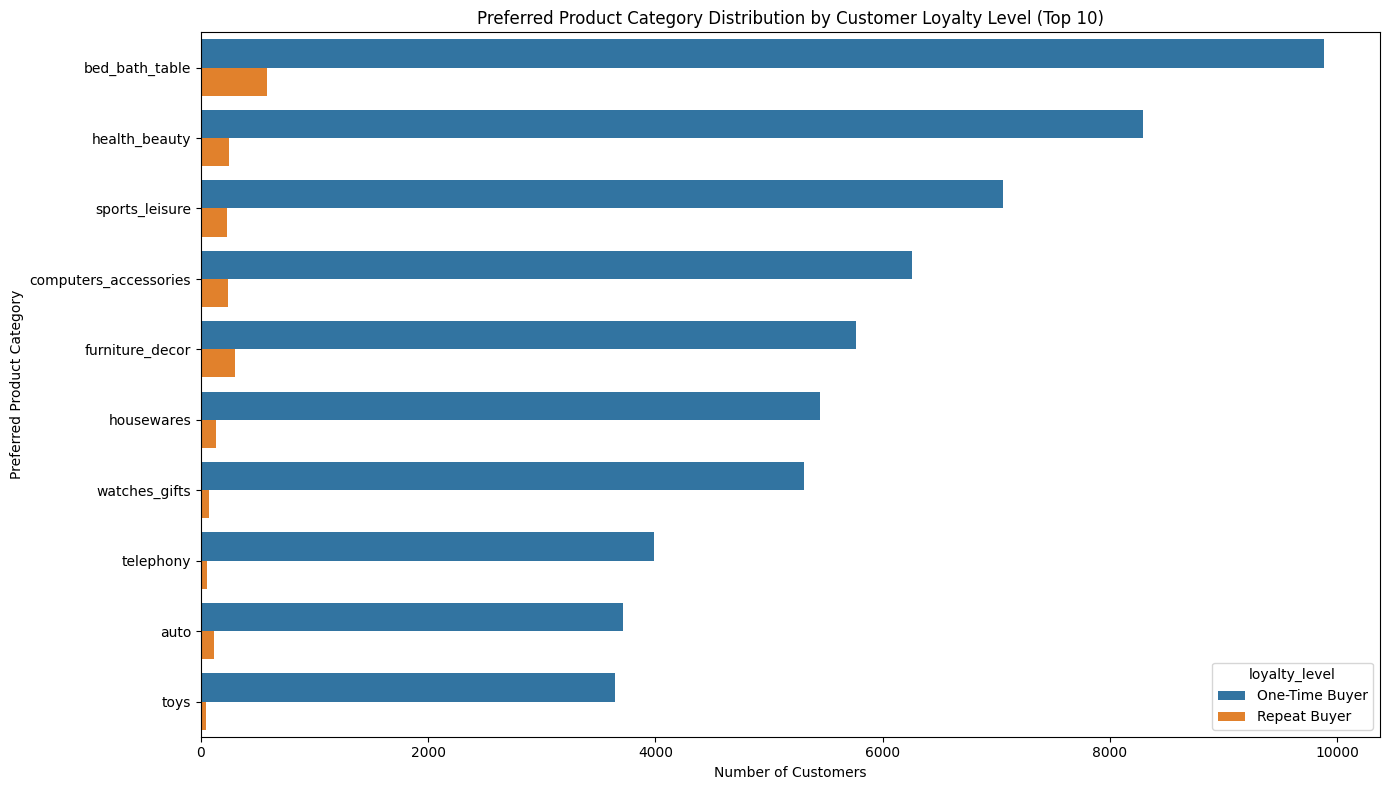

In [ ]:
customer_metrics['loyalty_level'] = customer_metrics['purchase_frequency'].apply(lambda x: 'Repeat Buyer' if x > 1 else 'One-Time Buyer')

print("Comparing Average Ticket Price by Loyalty Level:")
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_metrics, x='loyalty_level', y='avg_ticket_price')
plt.title('Average Ticket Price by Customer Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Average Ticket Price')
plt.show()

print("\nComparing Preferred Payment Type by Loyalty Level:")
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_metrics, x='loyalty_level', hue='preferred_payment_type')
plt.title('Preferred Payment Type Distribution by Customer Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Number of Customers')
plt.show()

print("\nComparing Preferred Product Category by Loyalty Level (Top 10 Categories):")
plt.figure(figsize=(14, 8))

top_10_categories_overall = customer_metrics['preferred_product_category'].value_counts().nlargest(10).index

sns.countplot(data=customer_metrics[customer_metrics['preferred_product_category'].isin(top_10_categories_overall)],
              y='preferred_product_category', hue='loyalty_level', order=top_10_categories_overall)
plt.title('Preferred Product Category Distribution by Customer Loyalty Level (Top 10)')
plt.xlabel('Number of Customers')
plt.ylabel('Preferred Product Category')
plt.tight_layout()
plt.show()

**Hipótesis 3**: A mayor demora de entrega, mayor probabilidad reviews <= 3 (impacto en satisfacción).

**Conclusiones**: Al observar este gráfico de caja, vemos la distribución de la demora de entrega para los pedidos que recibieron una puntuación de reseña baja (<= 3) en comparación con los que recibieron una puntuación de reseña alta (> 3).

Compara la mediana de la demora de entrega (la línea dentro de la caja) entre los dos grupos.
Compara el rango intercuartílico (RIC) (la caja en sí), que muestra la dispersión del 50% central de los datos.
Observa los bigotes y los posibles puntos atípicos (outliers) para comprender el rango completo y los valores extremos de la demora de entrega en cada grupo.
Basándote en estas comparaciones visuales, puedes evaluar si los pedidos con menor satisfacción tienden a tener mayores demoras de entrega en comparación con los pedidos con mayor satisfacción.

Podemos concluir que parece haber una relación entre la demora de entrega y la satisfacción del cliente. La demora en satisfacción alta es menor en promedio que la de satisfacción baja.

In [ ]:
# Demora (puede ser negativa si llegó antes de la fecha estimada)
fact_orders["delivery_delay"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_estimated_delivery_date"]
).dt.days

Visualizing the relationship between Delivery Delay and Satisfaction Level:


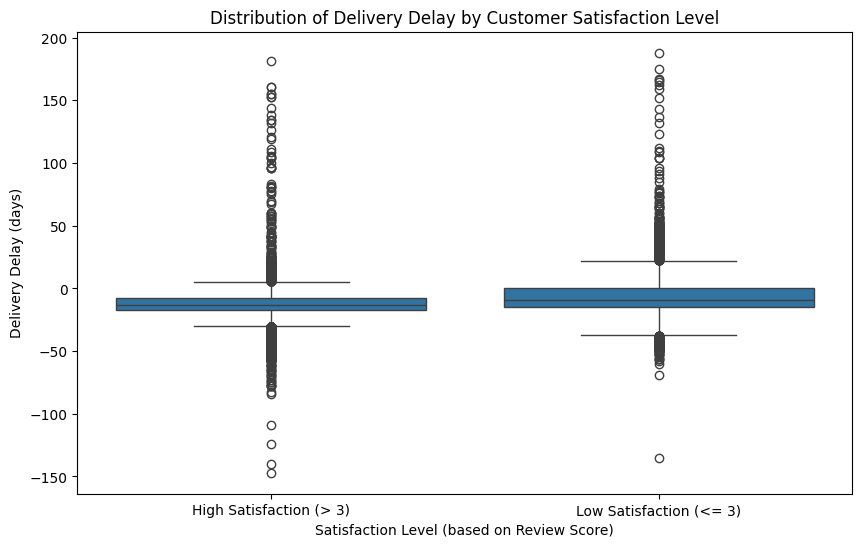

In [ ]:
if 'review_score' in fact_orders.columns:
    fact_orders_for_hypothesis_3 = fact_orders.dropna(subset=['review_score']).copy()
    fact_orders_for_hypothesis_3['satisfaction_level'] = fact_orders_for_hypothesis_3['review_score'].apply(lambda score: 'Low Satisfaction (<= 3)' if score <= 3 else 'High Satisfaction (> 3)')

    print("Visualizing the relationship between Delivery Delay and Satisfaction Level:")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fact_orders_for_hypothesis_3, x='satisfaction_level', y='delivery_delay')
    plt.title('Distribution of Delivery Delay by Customer Satisfaction Level')
    plt.xlabel('Satisfaction Level (based on Review Score)')
    plt.ylabel('Delivery Delay (days)')
    plt.show()


else:
    print("The 'review_score' column is not available in fact_orders to test Hypothesis 3.")

**Hipótesis 4**: Un % de flete alto (sobre el precio) incrementa las cancelaciones y baja la satisfacción.

**Conclusiones**: Podemos ver que hay diferencia entre el % de flete sobre el precio según el estado del envío, si fue enviado o cancelado.

Podemos ver que no se pueden sacar conclusiones a la vista acerca de si un mayor % de flete alto baja la satisfacción. Hay muchos casos de reviews altas con % de flete altos.

Las visualizaciones proporcionan cierta evidencia visual que apoya la idea de que un porcentaje de flete más alto podría estar relacionado con las cancelaciones. Sin embargo, la relación entre un porcentaje de flete alto y una menor satisfacción del cliente (basada en la puntuación de la reseña) no parece ser tan clara a simple vista y puede que no haya suficiente evidencia visual para respaldar esa parte de la hipótesis. Se necesitaría un análisis estadístico más riguroso para confirmar estas observaciones preliminares.

In [ ]:
fact_order_items['freight_percentage'] = (fact_order_items['freight_value'] / (fact_order_items['price'] + 1e-6)) * 100

print("Freight percentage calculated and added to fact_order_items.")
display(fact_order_items[['price', 'freight_value', 'freight_percentage']].head())

Freight percentage calculated and added to fact_order_items.


price  freight_value  freight_percentage
0   58.90          13.29           22.563667
1  239.90          19.93            8.307628
2  199.00          17.87            8.979899
3   12.99          12.79           98.460347
4  199.90          18.14            9.074537

Exploring relationship between Freight Percentage and Order Status:


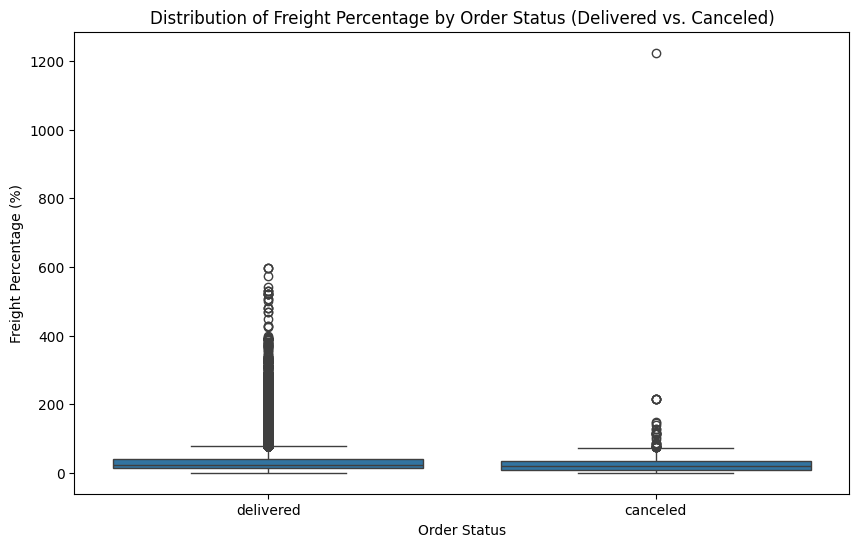

In [ ]:
order_status_subset = fact_orders[['order_id', 'order_status']]
items_with_status = pd.merge(fact_order_items, order_status_subset, on='order_id', how='left')

relevant_statuses = ['delivered', 'canceled']
items_relevant_status = items_with_status[items_with_status['order_status'].isin(relevant_statuses)].copy()

print("Exploring relationship between Freight Percentage and Order Status:")
plt.figure(figsize=(10, 6))
sns.boxplot(data=items_relevant_status, x='order_status', y='freight_percentage')
plt.title('Distribution of Freight Percentage by Order Status (Delivered vs. Canceled)')
plt.xlabel('Order Status')
plt.ylabel('Freight Percentage (%)')
plt.show()



Exploring relationship between Freight Percentage and Satisfaction Level (Review Score):


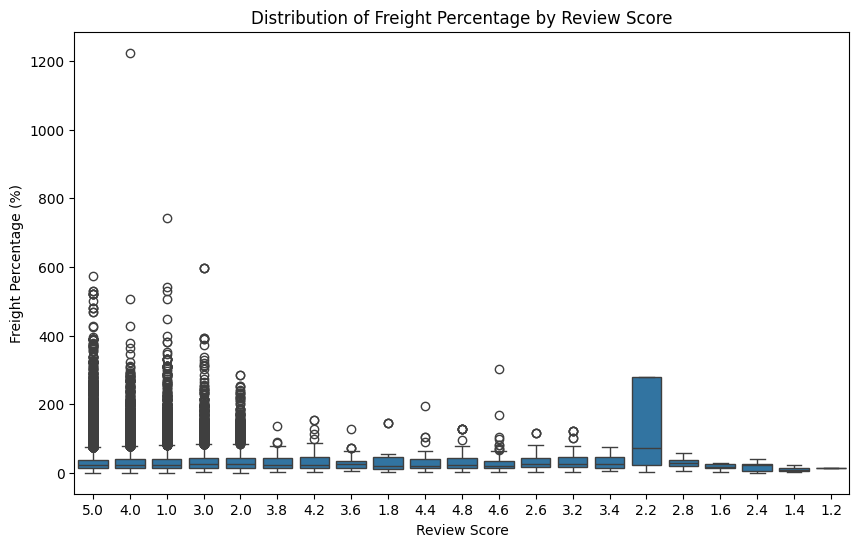

In [ ]:
if 'review_score' in fact_order_items.columns:
    items_for_satisfaction = fact_order_items.dropna(subset=['review_score']).copy()

    print("\nExploring relationship between Freight Percentage and Satisfaction Level (Review Score):")
    plt.figure(figsize=(10, 6))
    items_for_satisfaction['review_score_str'] = items_for_satisfaction['review_score'].astype(str)
    sns.boxplot(data=items_for_satisfaction, x='review_score_str', y='freight_percentage')
    plt.title('Distribution of Freight Percentage by Review Score')
    plt.xlabel('Review Score')
    plt.ylabel('Freight Percentage (%)')
    plt.show()

else:
    print("The 'review_score' column is not available in fact_order_items to explore this relationship.")